# Trajectory Tracking with discrete actions in Reinforcement Learning

The following is an implementation of an environment that allows traejctory tracking for a given trajectory. <br />
The trajectory is defined as follows: <br />

$$
f(t) = \sin(t) + \cos(4 * t)
$$

The actions space is discretee and defined as following:

$$
\mathrm action = \begin{cases}
    0 & \text{direction is down} \\
    1 & \text{no direction} \\
    2 & \text{direction is up}
\end{cases}
$$

That is the agent needs to track trajectory only using the discrete actions. <br />
In order to do that, we define an margin (m), step (s), up and low boundaries ( $f^{up}$ and $f^{down}$ ) and agent value ( $A^{v}$ ): <br />

$$
m = 0.15 \\
s = 0.08 \\
\\
f^{up} = f(t) * (1 + m) \\
f^{down} = f(t) * (1 - m) \\
$$

$$
\mathrm A^{v}(t) = \begin{cases}
    A^{v}(t) + s * | f(t) - f^{up} | & \text{if direction is up} \\
    A^{v}(t) - s * | f(t) - f^{down} | & \text{if direction is down} \\
    A^{v}(t) & \text{no direction}
\end{cases}
$$

The purpose of the agent is to choose the right direction and keep $A^{v}$ into the boundaries. The following is an example:

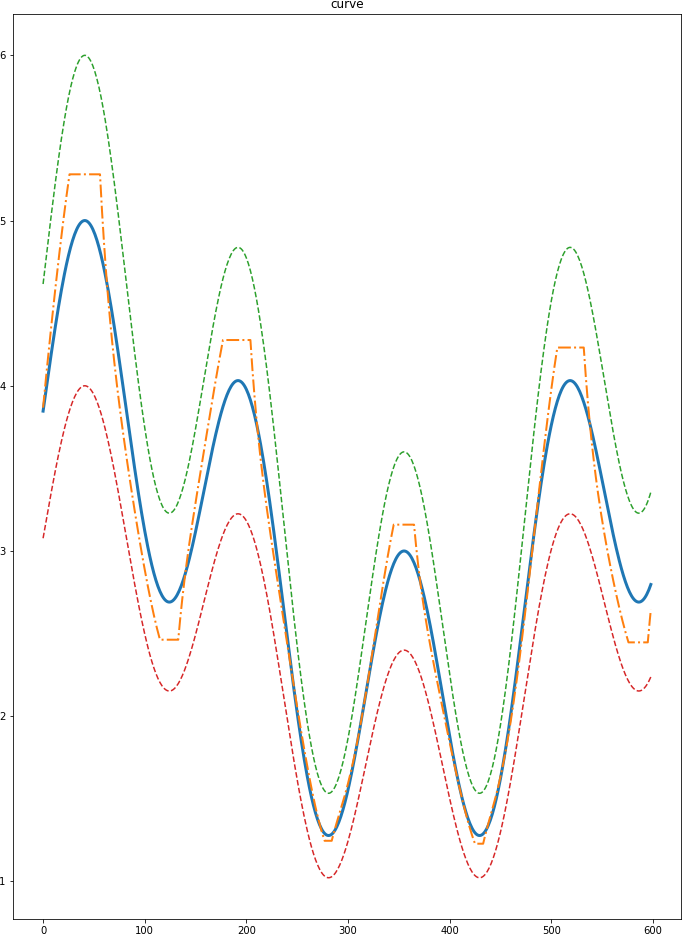

We also define a agent reward as follows:

$$
r(t) = 1 - | A^{v}(t) - f(t) | / ( m * f(t))
$$

We apply a cost every time the action changes it value. For direct transition from Up to Down and vie-versa the cost is double:

$$
cost(t) = - fee * | a(t) - a(t-1) |
$$

where a is the action.

In [1]:
import numpy as np
import pandas as pd
import random
from mpmath import mp, mpf
import math
import traceback
import sys
import os

### data factory

In [2]:
class DataSetSine:
    def __init__(self, config):
        self.episode = config.get('episode',600)
        self.is_training = config.get('is_training', True)
        self.is_testing = config.get('is_testing', False)
        self.normalizing = config.get('normalizing', False)
        self.normalize_window = config.get('normalize_window', 100)

        self.T = 1e6
        self.x = np.linspace(0, 1e4, int(self.T))
        self.data =  np.array([math.sin(i)+math.cos(4*i)+3. for i in self.x])

        self._init_dataset()

    def _init_dataset(self):
        self.dataset_len = self.data.shape[0]
        self.split_rate = .9
        train_set = int(math.ceil(self.data.shape[0] * self.split_rate))
        self.data_train = self.data[:train_set]
        self.data_test = self.data[train_set:]
        if self.is_training:
            self.data = self.data_train.copy()
        elif self.is_testing:
            self.data = self.data_test.copy()

    def set_testing(self):
        self.data = self.data_test.copy()
        self.is_training = False
        self.is_testing = True

    def set_training(self):
        self.data = self.data_train.copy()
        self.is_training = True
        self.is_testing = False

    def next(self):
        current_value = self.data[self.position]
        self.position += 1
        self.to_end -= 1
        # only executed if self.normalizing
        if self.normalizing:
            rolling_data = self.data[self.position-self.normalize_window-1:self.position].to_numpy()
            rolling_data_shifted = np.roll(rolling_data, 1, axis=0)
            norm_dataset = np.concatenate((rolling_data, rolling_data_shifted),axis=1)[1:,:]
            percentage_data = (norm_dataset[:,0]-norm_dataset[:,1])/norm_dataset[:,0]
            self.stddev = np.std(percentage_data)
            self.mean = np.mean(percentage_data)
            percentage_abs = np.array([np.abs(x) for x in percentage_data])
            self.mean_abs = np.mean(percentage_abs)

        if self.position >= self.end_tick or self.to_end <= 0:
            return .0, .0, True
        else:
            new_value = self.data[self.position]
            rew = (new_value - current_value)/current_value
            return rew, new_value, False

    def get_samples(self):
        c = self.data[self.position]
        c1 = self.data[self.position-1]
        c2 = self.data[self.position-2]
        c3 = self.data[self.position-3]
        return np.array(((c-c1)/c1,(c-c2)/c2,(c-c3)/c3))

    def get_current_value(self):
        return(self.data[self.position])

    def dataset_len(self):
        return(self.data.shape[0])

    def reset(self, position=None):
        cut_param = 50 + self.normalize_window

        if self.is_training:
            self.end_tick = self.data.shape[0] - self.episode - cut_param
            if position is not None:
                self.position = position
            else:
                self.position = self.start_tick = random.randint(cut_param, self.end_tick)
            self.to_end = self.episode
        else:
            self.position = self.start_tick = cut_param
            self.end_tick = self.data.shape[0] - cut_param
            self.to_end = self.end_tick - self.start_tick


### gym environment

In [6]:

import random
import json
import gym
from gym import spaces
from enum import Enum
from gym.utils import seeding

class FollowingActions(Enum):
    Down = 0
    Stay = 1
    Up = 2

class TrajectoryTrackingEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, config={}):

        self.seed()

        self.episode = config.get("episode_len", 600)
        self.features = config.get("features", 3)
        self.stop_out_boundaries = config.get("stop_out_boundaries", False)
        self.normalizing = config.get("normalizing", False)
        self.bound_value = config.get("bound_value", 20e-2) # m
        self.step_value = config.get("step_value", 8e-2) # s
        self.fee = config.get("fee", 1.) # fee

        self.dataset = DataSetSine(config={'episode':self.episode})

        self.action_space = gym.spaces.Discrete(3)
        high=np.array([1.,1.,1.])
        self.observation_space=spaces.Box(-high, high)

        self.info = dict()
        self.infos = []

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def switch_to_train_dataset(self):
        self.dataset.set_training()

    def switch_to_test_dataset(self):
        self.dataset.set_testing()

    def reset(self, position=None):
        self.info = dict()
        self.infos = []
        self.dataset.reset(position)

        self.agent_value = self.dataset.get_current_value()
        self.target_value = self.dataset.get_current_value()
        self.up_bound = self.target_value * (1 + self.bound_value)
        self.lower_bound = self.target_value * (1 - self.bound_value)
        self.cost = 0.

        return self.dataset.get_samples()

    def step(self, action):
        completion_reward = 100.

        self.raw_reward, value, done = self.dataset.next()
        if done:
            if self.stop_out_boundaries:
                return np.zeros(self.features), self.raw_reward+completion_reward, done, self.info
            else:
                return np.zeros(self.features), self.raw_reward, done, self.info

        self.target_value = self.dataset.get_current_value()
        self.up_bound = self.target_value * (1 + self.bound_value)
        self.lower_bound = self.target_value * (1 - self.bound_value)

        # only executed if self.stop_out_boundaries
        if self.agent_value > self.up_bound and self.stop_out_boundaries:
            self.agent_value = self.up_bound
            if self.dataset.is_training and self.stop_out_boundaries:
                return np.zeros(self.features), self.raw_reward-completion_reward, True, self.info
        elif self.agent_value < self.lower_bound and self.stop_out_boundaries:
            self.agent_value = self.lower_bound
            if self.dataset.is_training and self.stop_out_boundaries:
                return np.zeros(self.features), self.raw_reward-completion_reward, True, self.info

        if action == FollowingActions.Up.value:
            self.agent_value += self.step_value * np.abs(self.agent_value - self.up_bound)
        elif action == FollowingActions.Down.value:
            self.agent_value -= self.step_value * np.abs(self.agent_value - self.lower_bound)
            self.raw_reward = -self.raw_reward
        elif action == FollowingActions.Stay.value:
            self.raw_reward = .0

        self.agent_reward = 1. - np.abs(self.agent_value - value)/(self.bound_value * value)

        if "action" in self.info:
            self.cost = -self.fee * np.abs((action - 1) - (self.info["action"] - 1))
        else:
            self.cost = 0.

        self.total_reward = self.agent_reward + self.cost
        if self.normalizing:
            self.total_reward *= self.dataset.mean_abs / self.dataset.stddev

        obs = self.dataset.get_samples()
        f1 = obs[0]
        f2 = obs[1]
        f3 = obs[2]


        self.info = dict(
            value = value,
            agent_value = self.agent_value,
            up_bound = self.up_bound,
            lower_bound = self.lower_bound,
            raw_reward = self.raw_reward,
            agent_reward = self.agent_reward,
            total_reward = self.total_reward,
            cost = self.cost,
            action = action,
            f1 = f1,
            f2 = f2,
            f3 = f3
        )

        self.infos.append(self.info)

        return obs, self.total_reward, done, self.info

    def render(self, mode='human'):
        fig, axs = plt.subplots(3,4)
        fig.set_figheight(40)
        fig.set_figwidth(40)
        fig.suptitle('FXTrailEnv')

        val = [d['value'] for d in self.infos]
        ag_val = [d['agent_value'] for d in self.infos]
        up_pr = [d['up_bound'] for d in self.infos]
        lower_pr = [d['lower_bound'] for d in self.infos]
        rew = [d['raw_reward'] for d in self.infos]
        agent_rew = [d['agent_reward'] for d in self.infos]
        cost = [d['cost'] for d in self.infos]
        tot_rew = [d['total_reward'] for d in self.infos]
        ac = [d['action'] for d in self.infos]
        f1 = [d['f1'] for d in self.infos]
        f2 = [d['f2'] for d in self.infos]
        f3 = [d['f3'] for d in self.infos]

        axs[0,0].plot(val, linewidth=3)
        axs[0,0].plot(ag_val, '-.', linewidth=2)
        axs[0,0].plot(up_pr, '--')
        axs[0,0].plot(lower_pr, '--')
        axs[0,0].set_title('curve')

        axs[0,1].plot(ac, color='green')
        axs[0,1].set_title('agent positions')

        axs[0,2].plot(rew)
        axs[0,2].set_title('raw rewards')

        N = 100
        axs[1,0].plot(f1[:N])
        axs[1,0].plot(f2[:N])
        axs[1,0].plot(f3[:N])
        axs[1,0].set_title('features')

        axs[1,1].plot(agent_rew)
        axs[1,1].set_title('agent rewards')

        axs[1,2].plot(tot_rew)
        axs[1,2].set_title('total rewards')

        axs[1,3].plot(cost)
        axs[1,3].set_title('total costs')

        agentrew = np.cumsum(agent_rew)
        axs[2,0].plot(agentrew)
        axs[2,0].set_title('cumulative agent rewards')

        totrew = np.cumsum(tot_rew)
        axs[2,1].plot(totrew)
        axs[2,1].set_title('cumulative total rewards')

        totrew = np.cumsum(rew)
        axs[2,2].plot(totrew)
        axs[2,2].set_title('cumulative raw rewards')

        axs[2,3].plot(np.cumsum(cost))
        axs[2,3].set_title('total costs')

        fig.tight_layout()

### get observations

In [7]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import sys

env = TrajectoryTrackingEnv()

observation = env.reset()

print(observation)

[0.00961533 0.01898079 0.02806503]


### data leak example

In the following example the agent knows thge value of the trajectory in advance and it tries to figure out what action to use on this basis. We basically have two simple policy, the first uses also the **stay** action while the second does not use. We can see the reward is bigger in the first case.

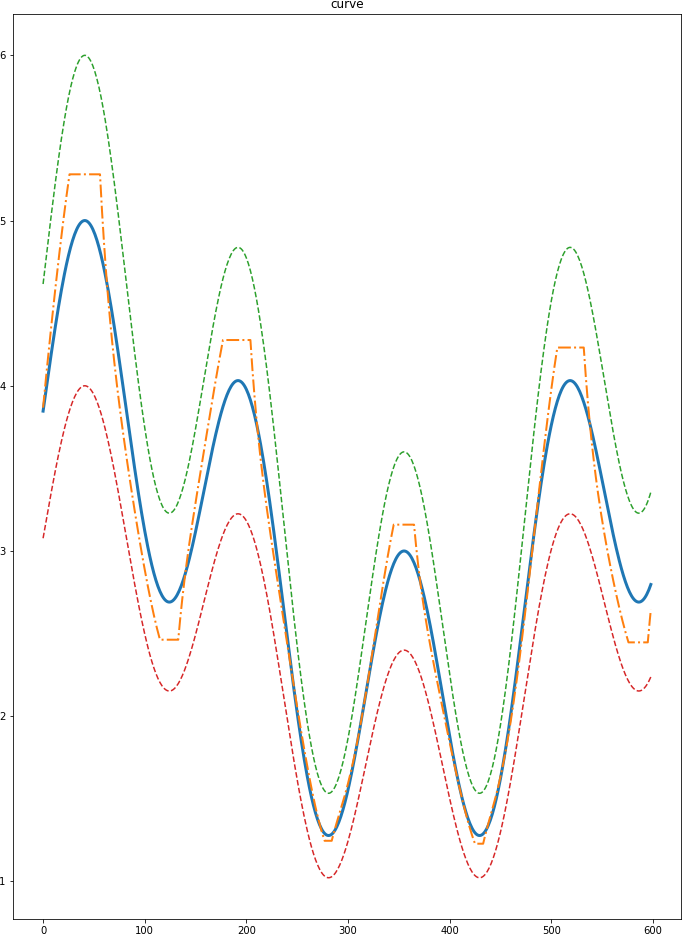

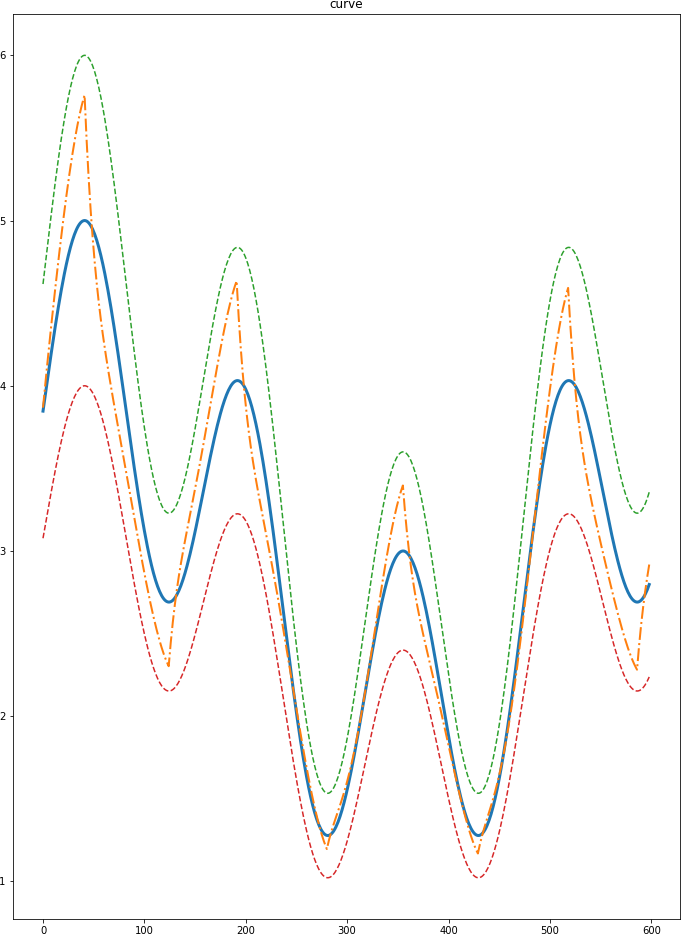


tested environment: #1, timesteps: 600, reward: 436.5314690189648
tested environment: #1, timesteps: 600, reward: 393.5003840585277


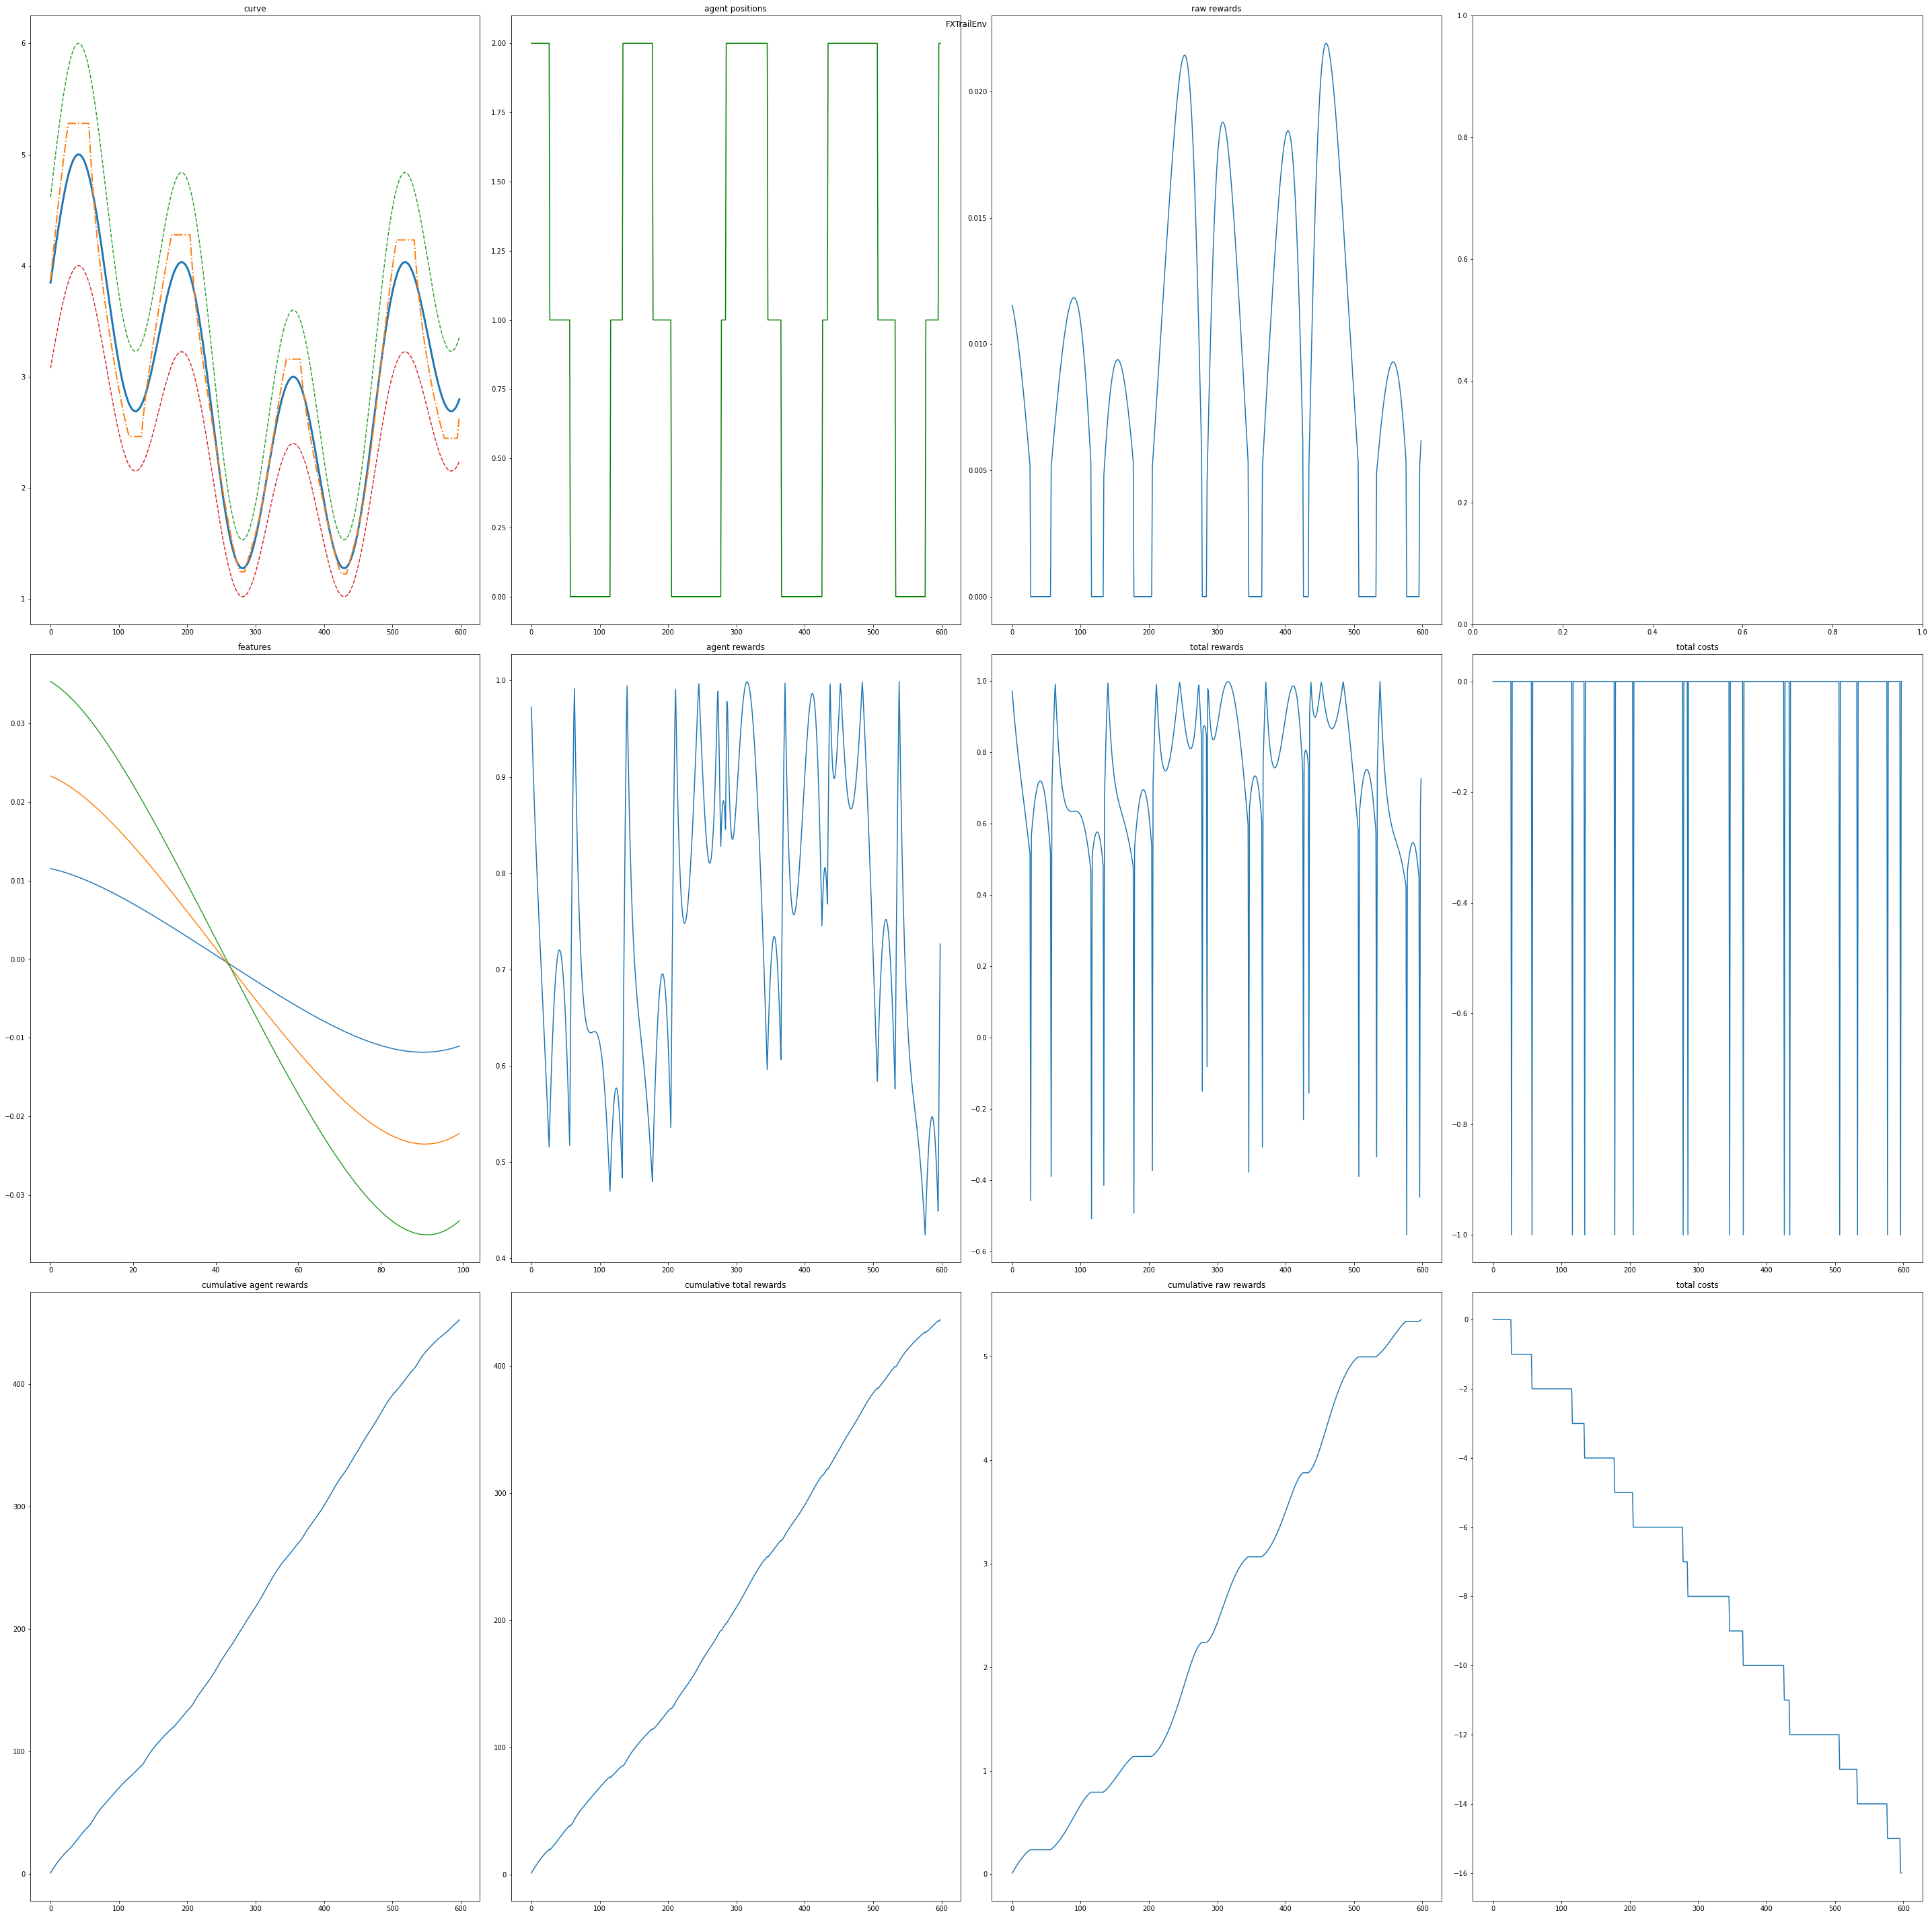

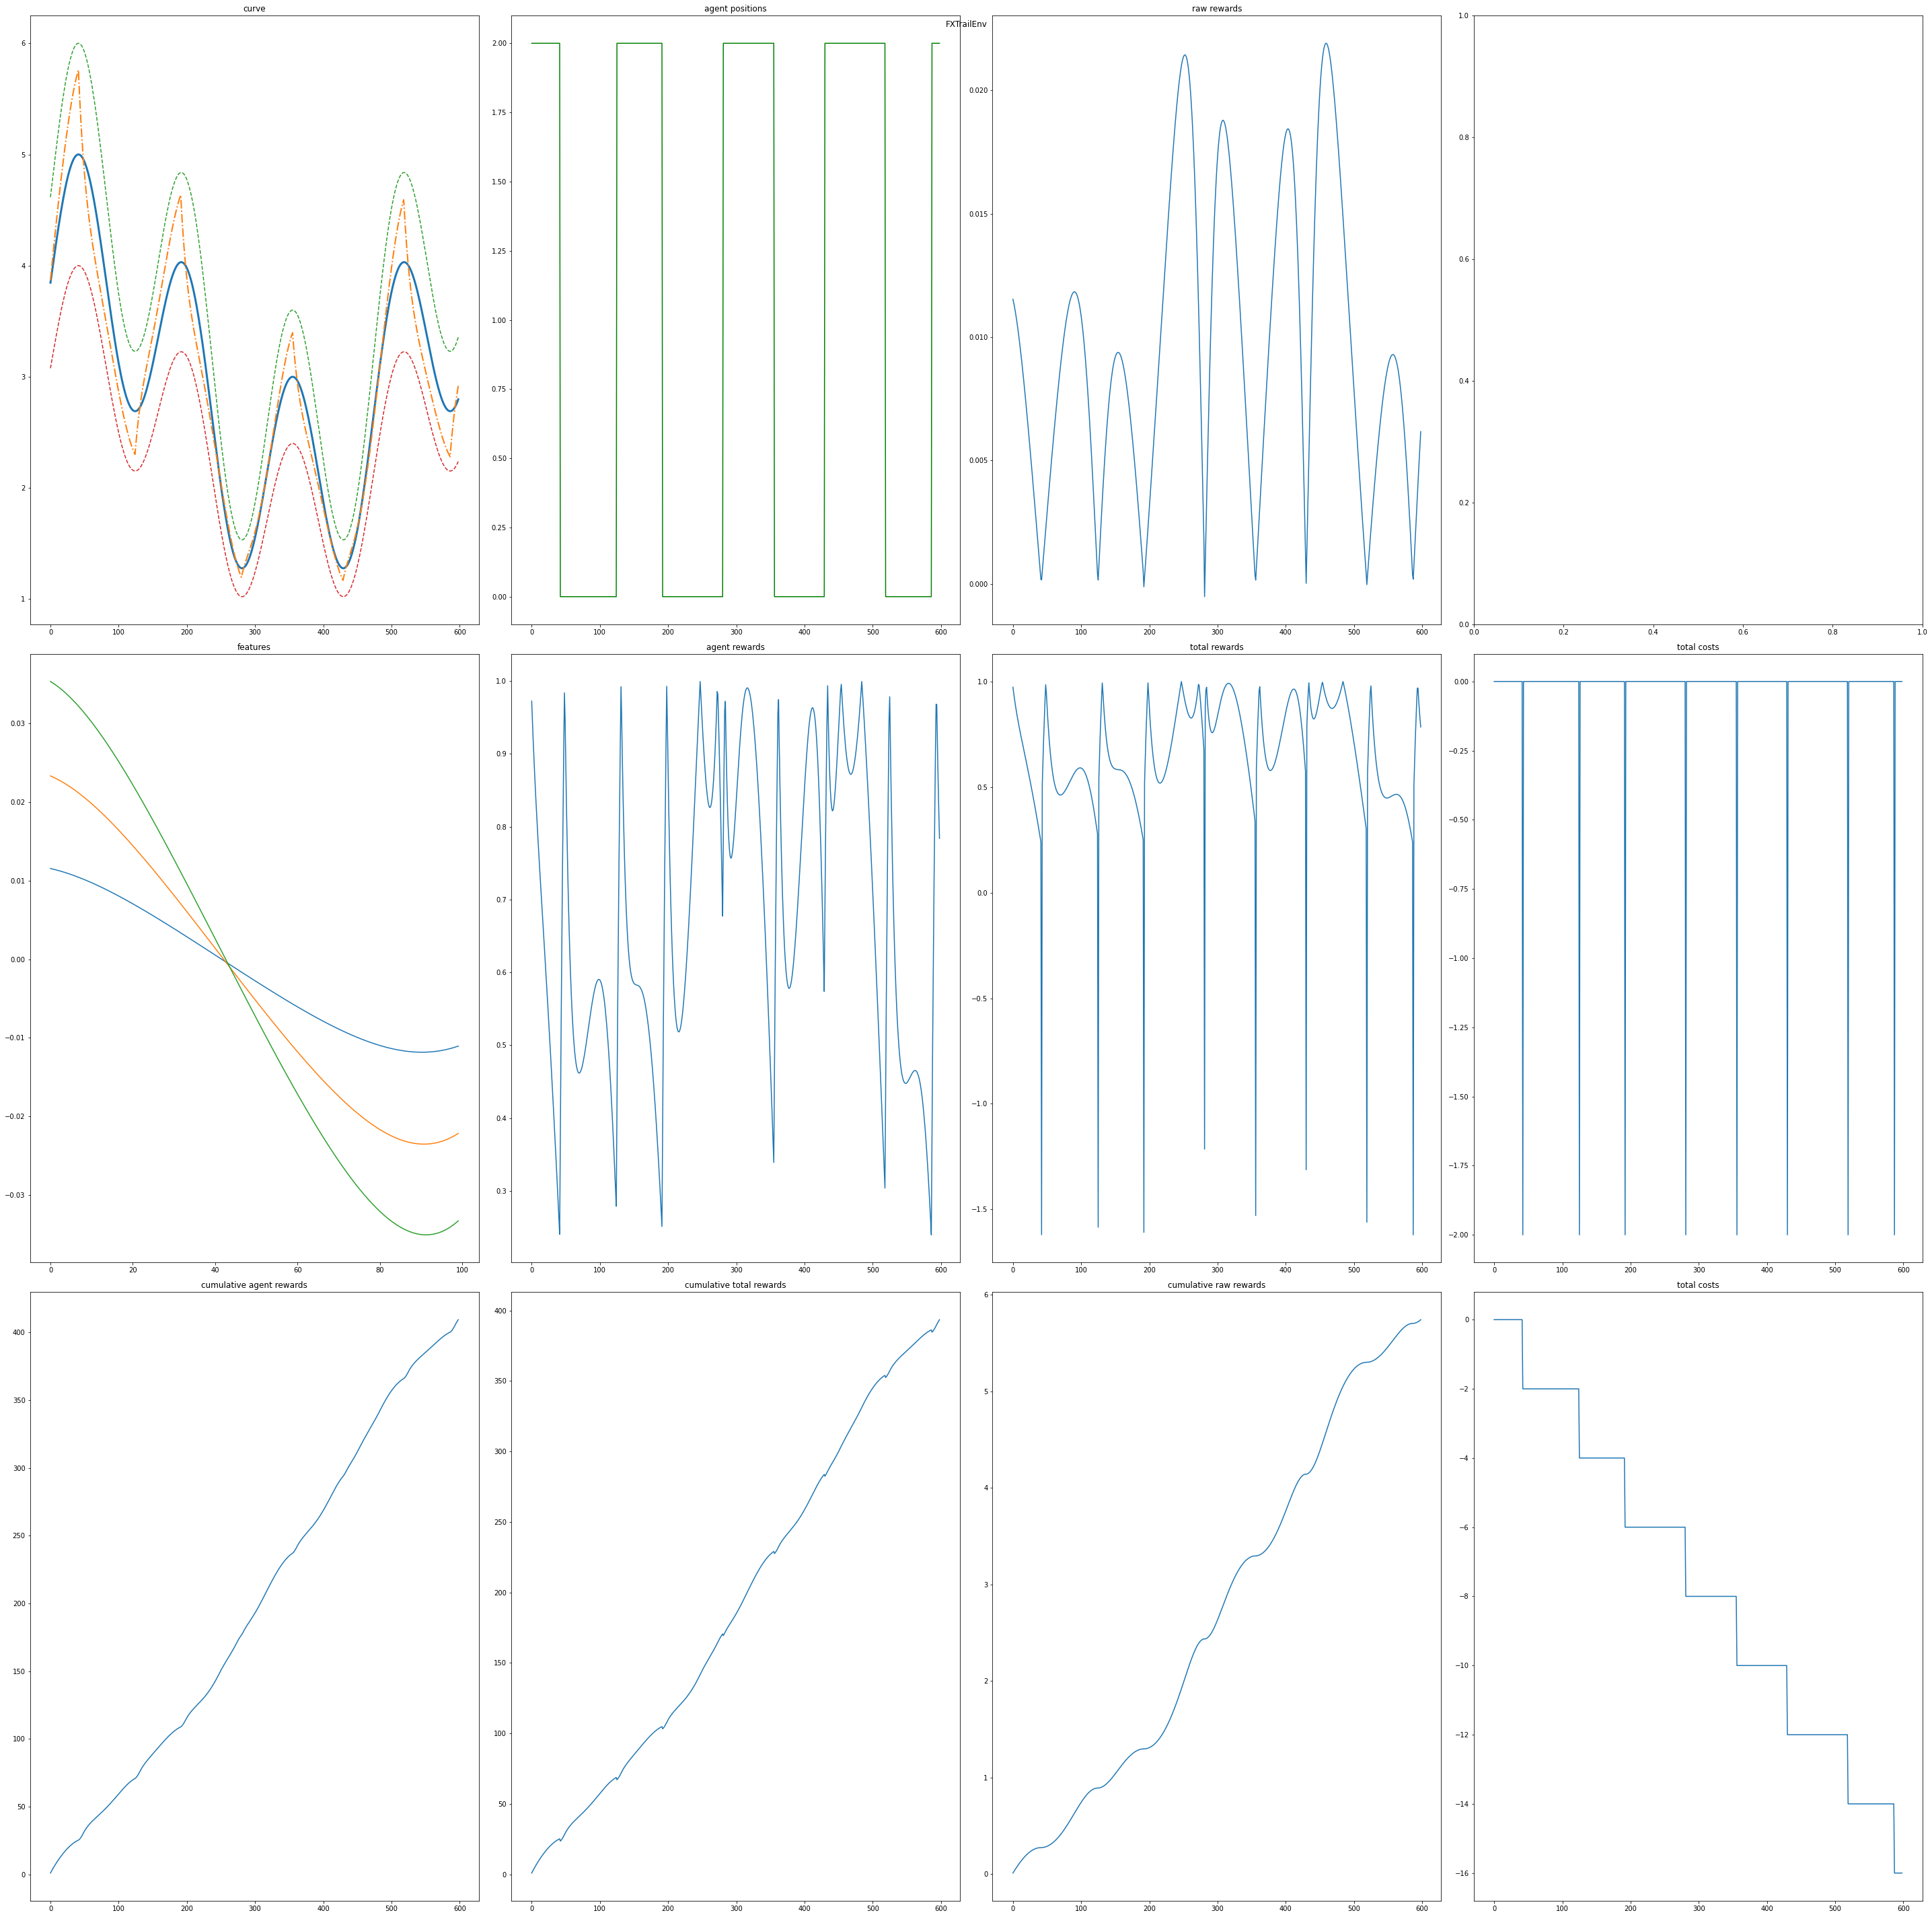

In [8]:
for k in range(1):
    observation = env.reset(position=2000)
    i = 0
    episode_reward = .0
    while True:
        trend = (env.dataset.data[env.dataset.position+2] - env.dataset.data[env.dataset.position])/env.dataset.data[env.dataset.position]
        if trend > 0.01:
            action = 2
        elif trend < -0.01:
            action = 0
        else:
            action = 1
        observation, reward, done, info = env.step(action)
        episode_reward += reward
        i += 1
        if done:
            break
    print('tested environment: #{}, timesteps: {}, reward: {}'.format(k+1, i, episode_reward))
    env.render()
    observation = env.reset(position=2000)
    i = 0
    episode_reward = .0
    while True:
        trend = (env.dataset.data[env.dataset.position+2] - env.dataset.data[env.dataset.position])/env.dataset.data[env.dataset.position]
        if trend > .0:
            action = 2
        elif trend < -.0:
            action = 0
        observation, reward, done, info = env.step(action)
        episode_reward += reward
        i += 1
        if done:
            break

    print('tested environment: #{}, timesteps: {}, reward: {}'.format(k+1, i, episode_reward))
    env.render()


### PPO configuration

In [14]:
import os
import numpy as np

import ray
from ray import tune
from ray.rllib.utils.test_utils import check_learning_achieved
from ray.rllib.agents.ppo import PPOTrainer

args = {'run': 'PPO',
        'framework': 'torch',
        'num_cpus': 0,
        'eager_tracing': False,
        'use_prev_action': True,
        'use_prev_reward': True,
        'stop_iters': 100,
        'stop_timesteps': 40e6,
        'stop_reward': 600.
       }


configs = {
    "PPO": {
        "num_sgd_iter": 5,
        "model": {
            "vf_share_layers": True,
        },
        "vf_loss_coeff": 1e-4,
    },
    "IMPALA": {
        "num_workers": 2,
        "num_gpus": 0,
        "vf_loss_coeff": 0.01,
    },
}

config = dict(
    configs[args['run']],
    **{
        "env": TrajectoryTrackingEnv,
        "num_gpus": 0,
        "model": {
            "use_lstm": True,
            "lstm_cell_size": 256,
            "lstm_use_prev_action": args['use_prev_action'],
            "lstm_use_prev_reward": args['use_prev_reward'],
        },
        "framework": args['framework'],
        # Run with tracing enabled for tfe/tf2?
        "eager_tracing": args['eager_tracing'],
    })

stop = {
    "training_iteration": args['stop_iters'],
    "timesteps_total": args['stop_timesteps'],
    "episode_reward_mean": args['stop_reward'],
}


### RLLIB training

In [15]:
results = tune.run(args['run'], config=config, stop=stop, verbose=2, checkpoint_at_end=True)
    

2021-11-04 15:30:19,420	INFO tune.py:735 -- Initializing Ray automatically.For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run`.
2021-11-04 15:30:19,906	WARNING services.py:1729 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67096576 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=10.24gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.


(pid=1094) 2021-11-04 15:30:23,019	INFO ppo.py:164 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(pid=1094) 2021-11-04 15:30:23,019	INFO trainer.py:758 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=1097) /opt/conda/lib/python3.9/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=1097)   logger.warn(
(pid=1093) /opt/conda/lib/python3.9/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=1093)   logger.warn(
(pid=1094) 2021-11-04 15:30:25,952	WARNING trainer_template.py:185 -- `execution_plan` functions should accept `trainer`, `workers`, and `config` as args!
(pid=1094) 2021-11-04 15:30:25,953	WARNING util.py:57 -- Install gputil for GPU system monitoring.


Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=-359.23146371737994,episode_reward_min=-1113.1084394444702,episode_reward_mean=-601.0470570740647,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09026234296487008, 'mean_inference_ms': 1.5590509612937977, 'mean_action_processing_ms': 0.05233871644881294, 'mean_env_wait_ms': 0.0770534651688133, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=4000,timers={'sample_time_ms': 3988.507, 'sample_throughput': 1002.882, 'load_time_ms': 83.324, 'load_throughput': 48005.265, 'learn_time_ms': 3790.1, 'learn_throughput': 1055.381, 'update_time_ms': 3.1},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.19999999999999998, 'cur_lr': 5e-05, 'total_loss': 0.8355009450314326, 'policy_loss': -0.00082

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=-268.37907802693405,episode_reward_min=-1113.1084394444702,episode_reward_mean=-479.4266020137872,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09076297394289172, 'mean_inference_ms': 1.5648031486900245, 'mean_action_processing_ms': 0.05233225169083631, 'mean_env_wait_ms': 0.07734473048799928, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=8000,timers={'sample_time_ms': 5990.398, 'sample_throughput': 667.735, 'load_time_ms': 78.499, 'load_throughput': 50956.089, 'learn_time_ms': 3650.513, 'learn_throughput': 1095.736, 'update_time_ms': 2.555},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.19999999999999998, 'cur_lr': 5e-05, 'total_loss': 0.16170287089001747, 'policy_loss': 0.0

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=-211.83425652908065,episode_reward_min=-1113.1084394444702,episode_reward_mean=-397.65096729068136,episode_len_mean=600.0,episode_media={},episodes_this_iter=8,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09073444451639105, 'mean_inference_ms': 1.5649363564646712, 'mean_action_processing_ms': 0.052197754642075087, 'mean_env_wait_ms': 0.07739142442145017, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=12000,timers={'sample_time_ms': 6513.59, 'sample_throughput': 614.101, 'load_time_ms': 80.313, 'load_throughput': 49804.961, 'learn_time_ms': 3657.271, 'learn_throughput': 1093.712, 'update_time_ms': 2.455},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.09999999999999999, 'cur_lr': 5e-05, 'total_loss': 0.08641169366216467, 'policy_loss': -

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=-95.89832984275546,episode_reward_min=-1113.1084394444702,episode_reward_mean=-339.3240177622437,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.0907250695354187, 'mean_inference_ms': 1.5656587853469166, 'mean_action_processing_ms': 0.05214487742994612, 'mean_env_wait_ms': 0.07741059368991217, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=16000,timers={'sample_time_ms': 6841.642, 'sample_throughput': 584.655, 'load_time_ms': 82.157, 'load_throughput': 48687.048, 'learn_time_ms': 3636.195, 'learn_throughput': 1100.051, 'update_time_ms': 2.373},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.09999999999999999, 'cur_lr': 5e-05, 'total_loss': 0.012214793477417722, 'policy_loss': -0.

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=-6.117495099034695,episode_reward_min=-1113.1084394444702,episode_reward_mean=-284.7279180474543,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09064564497973705, 'mean_inference_ms': 1.5646839203795868, 'mean_action_processing_ms': 0.05205665323754047, 'mean_env_wait_ms': 0.0773550537747277, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=20000,timers={'sample_time_ms': 6991.383, 'sample_throughput': 572.133, 'load_time_ms': 84.258, 'load_throughput': 47473.192, 'learn_time_ms': 3620.667, 'learn_throughput': 1104.769, 'update_time_ms': 2.338},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.09999999999999999, 'cur_lr': 5e-05, 'total_loss': 0.0187761269269451, 'policy_loss': 0.008

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=119.26952556503521,episode_reward_min=-1113.1084394444702,episode_reward_mean=-216.41641732461275,episode_len_mean=600.0,episode_media={},episodes_this_iter=8,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09054567092509641, 'mean_inference_ms': 1.5625562771443853, 'mean_action_processing_ms': 0.05193535999264161, 'mean_env_wait_ms': 0.0772430231145399, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=24000,timers={'sample_time_ms': 7082.608, 'sample_throughput': 564.764, 'load_time_ms': 83.899, 'load_throughput': 47676.18, 'learn_time_ms': 3611.028, 'learn_throughput': 1107.718, 'update_time_ms': 2.307},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.15, 'cur_lr': 5e-05, 'total_loss': -0.0057272624254467025, 'policy_loss': -0.0248319902352

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=184.8154421543699,episode_reward_min=-1113.1084394444702,episode_reward_mean=-166.77763238021495,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09049111713001354, 'mean_inference_ms': 1.5618968963387416, 'mean_action_processing_ms': 0.05188427179849193, 'mean_env_wait_ms': 0.07720289264345585, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=28000,timers={'sample_time_ms': 7170.9, 'sample_throughput': 557.81, 'load_time_ms': 83.922, 'load_throughput': 47663.358, 'learn_time_ms': 3613.227, 'learn_throughput': 1107.044, 'update_time_ms': 2.285},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.15, 'cur_lr': 5e-05, 'total_loss': 0.026523508611811145, 'policy_loss': -0.01690724586407023

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=216.2855797060361,episode_reward_min=-1113.1084394444702,episode_reward_mean=-125.43375299414355,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09044275593522545, 'mean_inference_ms': 1.5613758152937143, 'mean_action_processing_ms': 0.05184377184180332, 'mean_env_wait_ms': 0.07717245622708206, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=32000,timers={'sample_time_ms': 7242.344, 'sample_throughput': 552.307, 'load_time_ms': 84.817, 'load_throughput': 47160.361, 'learn_time_ms': 3621.379, 'learn_throughput': 1104.552, 'update_time_ms': 2.26},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.075, 'cur_lr': 5e-05, 'total_loss': 0.040791180988232936, 'policy_loss': -0.01519278503762

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=258.79007395335964,episode_reward_min=-1113.1084394444702,episode_reward_mean=-78.47896311548793,episode_len_mean=600.0,episode_media={},episodes_this_iter=8,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09038728293747902, 'mean_inference_ms': 1.5606867077096587, 'mean_action_processing_ms': 0.05179551301895736, 'mean_env_wait_ms': 0.07713509098036556, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=36000,timers={'sample_time_ms': 7297.785, 'sample_throughput': 548.112, 'load_time_ms': 81.14, 'load_throughput': 49297.743, 'learn_time_ms': 3608.736, 'learn_throughput': 1108.421, 'update_time_ms': 2.251},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.0375, 'cur_lr': 5e-05, 'total_loss': 0.047864583341945564, 'policy_loss': -0.0205288712776

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=265.6336600449159,episode_reward_min=-1113.1084394444702,episode_reward_mean=-48.96532985264199,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09036503693124302, 'mean_inference_ms': 1.5606342403508258, 'mean_action_processing_ms': 0.05177861671113569, 'mean_env_wait_ms': 0.0771258500773173, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=40000,timers={'sample_time_ms': 7331.947, 'sample_throughput': 545.558, 'load_time_ms': 77.741, 'load_throughput': 51452.789, 'learn_time_ms': 3605.118, 'learn_throughput': 1109.534, 'update_time_ms': 2.235},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.01875, 'cur_lr': 5e-05, 'total_loss': 0.061561289093186776, 'policy_loss': -0.0188404641444

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=306.6433777212396,episode_reward_min=-1113.1084394444702,episode_reward_mean=-23.22203525946999,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09034346725500866, 'mean_inference_ms': 1.5605587943379347, 'mean_action_processing_ms': 0.05176250081973377, 'mean_env_wait_ms': 0.07711633070732213, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=44000,timers={'sample_time_ms': 7698.297, 'sample_throughput': 519.595, 'load_time_ms': 77.864, 'load_throughput': 51371.856, 'learn_time_ms': 3591.587, 'learn_throughput': 1113.714, 'update_time_ms': 2.147},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.009375, 'cur_lr': 5e-05, 'total_loss': 0.06462514455760679, 'policy_loss': -0.005206754614

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=306.6433777212396,episode_reward_min=-1113.1084394444702,episode_reward_mean=7.6373947872353565,episode_len_mean=600.0,episode_media={},episodes_this_iter=8,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09031938488854645, 'mean_inference_ms': 1.5605460208022113, 'mean_action_processing_ms': 0.05174760420381928, 'mean_env_wait_ms': 0.07711128392037624, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=48000,timers={'sample_time_ms': 7676.889, 'sample_throughput': 521.044, 'load_time_ms': 79.482, 'load_throughput': 50326.157, 'learn_time_ms': 3605.166, 'learn_throughput': 1109.519, 'update_time_ms': 2.161},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.0046875, 'cur_lr': 5e-05, 'total_loss': 0.08151549174179953, 'policy_loss': -0.00070966563

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=328.3755014413336,episode_reward_min=-1113.1084394444702,episode_reward_mean=28.499253324601025,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09030844521231361, 'mean_inference_ms': 1.5608714750742034, 'mean_action_processing_ms': 0.05174111833060706, 'mean_env_wait_ms': 0.07711315914926839, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=52000,timers={'sample_time_ms': 7708.88, 'sample_throughput': 518.882, 'load_time_ms': 78.239, 'load_throughput': 51125.421, 'learn_time_ms': 3591.829, 'learn_throughput': 1113.639, 'update_time_ms': 2.146},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.00234375, 'cur_lr': 5e-05, 'total_loss': 0.07597182307752871, 'policy_loss': -0.00993232258

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=329.9400845780598,episode_reward_min=-1113.1084394444702,episode_reward_mean=46.822394641693414,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.0902934954437513, 'mean_inference_ms': 1.561063707088803, 'mean_action_processing_ms': 0.051732251838368805, 'mean_env_wait_ms': 0.07711147862016184, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=56000,timers={'sample_time_ms': 7688.716, 'sample_throughput': 520.243, 'load_time_ms': 80.62, 'load_throughput': 49615.214, 'learn_time_ms': 3591.345, 'learn_throughput': 1113.789, 'update_time_ms': 2.146},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.001171875, 'cur_lr': 5e-05, 'total_loss': 0.054296517540370265, 'policy_loss': -0.0098172888

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=339.58616857126447,episode_reward_min=-1113.1084394444702,episode_reward_mean=68.73050118375608,episode_len_mean=600.0,episode_media={},episodes_this_iter=8,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09027300084455327, 'mean_inference_ms': 1.5611616912502668, 'mean_action_processing_ms': 0.05171895157342904, 'mean_env_wait_ms': 0.0771077639118976, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=60000,timers={'sample_time_ms': 7693.267, 'sample_throughput': 519.935, 'load_time_ms': 79.914, 'load_throughput': 50054.108, 'learn_time_ms': 3592.062, 'learn_throughput': 1113.566, 'update_time_ms': 2.135},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.001171875, 'cur_lr': 5e-05, 'total_loss': 0.046360634459603214, 'policy_loss': -0.012624824

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=343.1702227582385,episode_reward_min=-429.9190232320979,episode_reward_mean=124.41914730271445,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09026058140489797, 'mean_inference_ms': 1.561355514583059, 'mean_action_processing_ms': 0.05167215871088314, 'mean_env_wait_ms': 0.07710972579030714, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=64000,timers={'sample_time_ms': 7700.953, 'sample_throughput': 519.416, 'load_time_ms': 76.441, 'load_throughput': 52328.085, 'learn_time_ms': 3584.135, 'learn_throughput': 1116.029, 'update_time_ms': 2.133},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.0005859375, 'cur_lr': 5e-05, 'total_loss': 0.04841974115641337, 'policy_loss': -0.0012067711

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=343.1702227582385,episode_reward_min=-316.09203912536515,episode_reward_mean=164.57696454798585,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09018088865227063, 'mean_inference_ms': 1.5606433152745953, 'mean_action_processing_ms': 0.051618432921014604, 'mean_env_wait_ms': 0.0770672595576131, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=68000,timers={'sample_time_ms': 7658.569, 'sample_throughput': 522.291, 'load_time_ms': 76.147, 'load_throughput': 52529.871, 'learn_time_ms': 3573.72, 'learn_throughput': 1119.282, 'update_time_ms': 2.129},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.0005859375, 'cur_lr': 5e-05, 'total_loss': 0.03437157502818492, 'policy_loss': -0.011545186

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=343.1702227582385,episode_reward_min=-174.2679652567493,episode_reward_mean=212.19503081734646,episode_len_mean=600.0,episode_media={},episodes_this_iter=8,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09012134682468002, 'mean_inference_ms': 1.5602029998000133, 'mean_action_processing_ms': 0.05157606814168988, 'mean_env_wait_ms': 0.07702829906225839, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=72000,timers={'sample_time_ms': 7647.64, 'sample_throughput': 523.037, 'load_time_ms': 71.763, 'load_throughput': 55738.722, 'learn_time_ms': 3567.703, 'learn_throughput': 1121.17, 'update_time_ms': 2.131},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.00029296875, 'cur_lr': 5e-05, 'total_loss': 0.01569644758297551, 'policy_loss': -0.0222632653

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=343.1702227582385,episode_reward_min=-81.90961611156814,episode_reward_mean=239.9951572985775,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09008215089702216, 'mean_inference_ms': 1.5598392567251798, 'mean_action_processing_ms': 0.051550067687745775, 'mean_env_wait_ms': 0.07700418464012616, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=76000,timers={'sample_time_ms': 7657.106, 'sample_throughput': 522.391, 'load_time_ms': 74.944, 'load_throughput': 53373.528, 'learn_time_ms': 3580.308, 'learn_throughput': 1117.222, 'update_time_ms': 2.139},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.000146484375, 'cur_lr': 5e-05, 'total_loss': 0.02171226600485463, 'policy_loss': -0.0085884

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=343.1702227582385,episode_reward_min=-23.510814726133944,episode_reward_mean=262.09769852472226,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09006933785980693, 'mean_inference_ms': 1.5599872092634335, 'mean_action_processing_ms': 0.05154363455729806, 'mean_env_wait_ms': 0.07700670829377101, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=80000,timers={'sample_time_ms': 7674.064, 'sample_throughput': 521.236, 'load_time_ms': 74.954, 'load_throughput': 53366.381, 'learn_time_ms': 3586.339, 'learn_throughput': 1115.343, 'update_time_ms': 2.145},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 7.32421875e-05, 'cur_lr': 5e-05, 'total_loss': 0.018881460014850863, 'policy_loss': -0.00741

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=347.01487615412174,episode_reward_min=143.09732233563423,episode_reward_mean=284.34125068922833,episode_len_mean=600.0,episode_media={},episodes_this_iter=8,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09006672916715151, 'mean_inference_ms': 1.5607912295758166, 'mean_action_processing_ms': 0.0515551638620955, 'mean_env_wait_ms': 0.07703982123606873, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=84000,timers={'sample_time_ms': 7688.44, 'sample_throughput': 520.262, 'load_time_ms': 74.874, 'load_throughput': 53423.393, 'learn_time_ms': 3589.109, 'learn_throughput': 1114.483, 'update_time_ms': 2.139},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 3.662109375e-05, 'cur_lr': 5e-05, 'total_loss': 0.026468072591289398, 'policy_loss': -0.007951

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=347.01487615412174,episode_reward_min=158.57041879909113,episode_reward_mean=293.7119731418134,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09006166719103001, 'mean_inference_ms': 1.5610278880848534, 'mean_action_processing_ms': 0.05155339758507759, 'mean_env_wait_ms': 0.07705019491875982, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=88000,timers={'sample_time_ms': 7666.926, 'sample_throughput': 521.721, 'load_time_ms': 74.949, 'load_throughput': 53369.572, 'learn_time_ms': 3577.962, 'learn_throughput': 1117.955, 'update_time_ms': 2.14},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 1.8310546875e-05, 'cur_lr': 5e-05, 'total_loss': 0.027127562940961893, 'policy_loss': 0.002035

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=355.97965228407753,episode_reward_min=172.75306956544637,episode_reward_mean=302.92572623971057,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09005945621799068, 'mean_inference_ms': 1.561255607283544, 'mean_action_processing_ms': 0.05155112007735334, 'mean_env_wait_ms': 0.07705982452356368, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=92000,timers={'sample_time_ms': 7643.553, 'sample_throughput': 523.317, 'load_time_ms': 76.751, 'load_throughput': 52116.605, 'learn_time_ms': 3592.894, 'learn_throughput': 1113.309, 'update_time_ms': 2.147},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 1.8310546875e-05, 'cur_lr': 5e-05, 'total_loss': 0.019279957922633678, 'policy_loss': -0.0144

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=358.03120504959986,episode_reward_min=225.62601766568977,episode_reward_mean=312.232453207593,episode_len_mean=600.0,episode_media={},episodes_this_iter=8,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09006443588322811, 'mean_inference_ms': 1.561736684301594, 'mean_action_processing_ms': 0.05155508014761589, 'mean_env_wait_ms': 0.07708045306885783, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=96000,timers={'sample_time_ms': 7668.674, 'sample_throughput': 521.603, 'load_time_ms': 73.41, 'load_throughput': 54488.252, 'learn_time_ms': 3588.766, 'learn_throughput': 1114.589, 'update_time_ms': 2.14},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 9.1552734375e-06, 'cur_lr': 5e-05, 'total_loss': -0.0004932144161073431, 'policy_loss': -0.023834

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=363.81493869202603,episode_reward_min=234.49875150234126,episode_reward_mean=318.2131714700385,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09006078296729642, 'mean_inference_ms': 1.5618524548850559, 'mean_action_processing_ms': 0.051550139316981027, 'mean_env_wait_ms': 0.07708692783555646, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=100000,timers={'sample_time_ms': 7667.781, 'sample_throughput': 521.663, 'load_time_ms': 73.878, 'load_throughput': 54143.683, 'learn_time_ms': 3587.988, 'learn_throughput': 1114.831, 'update_time_ms': 2.138},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 4.57763671875e-06, 'cur_lr': 5e-05, 'total_loss': 0.012517316175264217, 'policy_loss': -0.0

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=369.18718196099366,episode_reward_min=259.96391946169126,episode_reward_mean=324.0302074846285,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09005972001997657, 'mean_inference_ms': 1.5619701607615526, 'mean_action_processing_ms': 0.051545404113998966, 'mean_env_wait_ms': 0.07709338865019813, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=104000,timers={'sample_time_ms': 7659.563, 'sample_throughput': 522.223, 'load_time_ms': 73.762, 'load_throughput': 54228.596, 'learn_time_ms': 3589.843, 'learn_throughput': 1114.255, 'update_time_ms': 2.134},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 2.288818359375e-06, 'cur_lr': 5e-05, 'total_loss': 0.012575604466180647, 'policy_loss': -0.

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=374.65533339467726,episode_reward_min=280.431670568563,episode_reward_mean=329.8147716832271,episode_len_mean=600.0,episode_media={},episodes_this_iter=8,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09006507609036639, 'mean_inference_ms': 1.5622359764933749, 'mean_action_processing_ms': 0.051541765332326205, 'mean_env_wait_ms': 0.07710549489656532, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=108000,timers={'sample_time_ms': 7700.137, 'sample_throughput': 519.471, 'load_time_ms': 75.284, 'load_throughput': 53132.288, 'learn_time_ms': 3610.152, 'learn_throughput': 1107.987, 'update_time_ms': 2.136},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 1.1444091796875e-06, 'cur_lr': 5e-05, 'total_loss': 0.005814765165409734, 'policy_loss': -0.0

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=387.1823351844828,episode_reward_min=292.7950056013383,episode_reward_mean=332.858026207233,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09006687672512666, 'mean_inference_ms': 1.5621671831979347, 'mean_action_processing_ms': 0.05153712573059113, 'mean_env_wait_ms': 0.07711123023367317, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=112000,timers={'sample_time_ms': 7718.419, 'sample_throughput': 518.241, 'load_time_ms': 76.167, 'load_throughput': 52516.42, 'learn_time_ms': 3615.495, 'learn_throughput': 1106.349, 'update_time_ms': 2.14},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 5.7220458984375e-07, 'cur_lr': 5e-05, 'total_loss': 0.01737910725416676, 'policy_loss': -0.008464

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=387.1823351844828,episode_reward_min=294.44652947805235,episode_reward_mean=335.80433540987855,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09007219988531313, 'mean_inference_ms': 1.562162041038029, 'mean_action_processing_ms': 0.05153457414759414, 'mean_env_wait_ms': 0.07711852249110723, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=116000,timers={'sample_time_ms': 7702.258, 'sample_throughput': 519.328, 'load_time_ms': 77.041, 'load_throughput': 51920.563, 'learn_time_ms': 3611.208, 'learn_throughput': 1107.663, 'update_time_ms': 2.137},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 2.86102294921875e-07, 'cur_lr': 5e-05, 'total_loss': 0.0180677110629697, 'policy_loss': -0.00

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=387.1823351844828,episode_reward_min=294.44652947805235,episode_reward_mean=339.3566950730545,episode_len_mean=600.0,episode_media={},episodes_this_iter=8,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09008590877086249, 'mean_inference_ms': 1.5623526024031695, 'mean_action_processing_ms': 0.051537214917877355, 'mean_env_wait_ms': 0.07713350310888782, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=120000,timers={'sample_time_ms': 7699.229, 'sample_throughput': 519.533, 'load_time_ms': 81.59, 'load_throughput': 49025.811, 'learn_time_ms': 3617.214, 'learn_throughput': 1105.823, 'update_time_ms': 2.133},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 1.430511474609375e-07, 'cur_lr': 5e-05, 'total_loss': 0.017671199058813432, 'policy_loss': -0

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=387.1823351844828,episode_reward_min=294.44652947805235,episode_reward_mean=341.48072061642625,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09009653586188955, 'mean_inference_ms': 1.5625141158527671, 'mean_action_processing_ms': 0.05154059031967401, 'mean_env_wait_ms': 0.07714446778579269, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=124000,timers={'sample_time_ms': 7703.92, 'sample_throughput': 519.216, 'load_time_ms': 82.129, 'load_throughput': 48703.599, 'learn_time_ms': 3608.071, 'learn_throughput': 1108.626, 'update_time_ms': 2.117},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 7.152557373046875e-08, 'cur_lr': 5e-05, 'total_loss': 0.012808668726093826, 'policy_loss': -0

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=387.1823351844828,episode_reward_min=294.44652947805235,episode_reward_mean=344.46458864924784,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09011549726797892, 'mean_inference_ms': 1.5629239244673356, 'mean_action_processing_ms': 0.051552288351141236, 'mean_env_wait_ms': 0.07716687508187686, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=128000,timers={'sample_time_ms': 7724.506, 'sample_throughput': 517.832, 'load_time_ms': 81.953, 'load_throughput': 48808.221, 'learn_time_ms': 3622.157, 'learn_throughput': 1104.315, 'update_time_ms': 2.11},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 3.5762786865234374e-08, 'cur_lr': 5e-05, 'total_loss': 0.024378585319725737, 'policy_loss': 

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=387.1823351844828,episode_reward_min=294.44652947805235,episode_reward_mean=347.55322973030366,episode_len_mean=600.0,episode_media={},episodes_this_iter=8,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09013827171719274, 'mean_inference_ms': 1.5633929870270646, 'mean_action_processing_ms': 0.05156481495427848, 'mean_env_wait_ms': 0.07719394588622576, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=132000,timers={'sample_time_ms': 7734.774, 'sample_throughput': 517.145, 'load_time_ms': 80.88, 'load_throughput': 49455.708, 'learn_time_ms': 3606.98, 'learn_throughput': 1108.961, 'update_time_ms': 2.105},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 1.7881393432617187e-08, 'cur_lr': 5e-05, 'total_loss': 0.01756480409868903, 'policy_loss': -0.

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=387.1823351844828,episode_reward_min=294.44652947805235,episode_reward_mean=350.06617772003875,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09015010519869343, 'mean_inference_ms': 1.5636870662418318, 'mean_action_processing_ms': 0.0515704836249406, 'mean_env_wait_ms': 0.077209830126095, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=136000,timers={'sample_time_ms': 7726.082, 'sample_throughput': 517.727, 'load_time_ms': 81.457, 'load_throughput': 49105.91, 'learn_time_ms': 3620.091, 'learn_throughput': 1104.944, 'update_time_ms': 2.108},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 8.940696716308593e-09, 'cur_lr': 5e-05, 'total_loss': 0.023643847290546662, 'policy_loss': -0.00

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=387.1823351844828,episode_reward_min=294.44652947805235,episode_reward_mean=352.5324436646897,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09015843109429049, 'mean_inference_ms': 1.5639010294178826, 'mean_action_processing_ms': 0.05157394601940792, 'mean_env_wait_ms': 0.07721949816889112, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=140000,timers={'sample_time_ms': 7738.198, 'sample_throughput': 516.916, 'load_time_ms': 81.348, 'load_throughput': 49171.323, 'learn_time_ms': 3617.301, 'learn_throughput': 1105.797, 'update_time_ms': 2.103},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 4.470348358154297e-09, 'cur_lr': 5e-05, 'total_loss': 0.026994320052495645, 'policy_loss': 0.

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=387.1823351844828,episode_reward_min=294.44652947805235,episode_reward_mean=354.5977326553968,episode_len_mean=600.0,episode_media={},episodes_this_iter=8,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09016330817415458, 'mean_inference_ms': 1.5639892788281025, 'mean_action_processing_ms': 0.05157292142074864, 'mean_env_wait_ms': 0.07722426080473728, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=144000,timers={'sample_time_ms': 7727.491, 'sample_throughput': 517.632, 'load_time_ms': 81.38, 'load_throughput': 49152.034, 'learn_time_ms': 3625.614, 'learn_throughput': 1103.262, 'update_time_ms': 2.107},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 2.2351741790771484e-09, 'cur_lr': 5e-05, 'total_loss': 0.007342033508804536, 'policy_loss': -0

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=387.1823351844828,episode_reward_min=325.9473942549209,episode_reward_mean=356.92709251389783,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09017054417121552, 'mean_inference_ms': 1.5641779006897003, 'mean_action_processing_ms': 0.05157560635254112, 'mean_env_wait_ms': 0.07723120548587124, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=148000,timers={'sample_time_ms': 7712.382, 'sample_throughput': 518.646, 'load_time_ms': 80.667, 'load_throughput': 49586.78, 'learn_time_ms': 3603.368, 'learn_throughput': 1110.072, 'update_time_ms': 2.1},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 1.1175870895385742e-09, 'cur_lr': 5e-05, 'total_loss': 0.03525645562237309, 'policy_loss': 0.004

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=387.1823351844828,episode_reward_min=330.367578652582,episode_reward_mean=357.53426282556575,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.0901800875173502, 'mean_inference_ms': 1.5643845356414952, 'mean_action_processing_ms': 0.05157957879139634, 'mean_env_wait_ms': 0.0772387027174017, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=152000,timers={'sample_time_ms': 7694.445, 'sample_throughput': 519.856, 'load_time_ms': 83.509, 'load_throughput': 47899.156, 'learn_time_ms': 3599.445, 'learn_throughput': 1111.282, 'update_time_ms': 2.102},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 5.587935447692871e-10, 'cur_lr': 5e-05, 'total_loss': 0.016059439725452852, 'policy_loss': -0.00

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=387.1823351844828,episode_reward_min=330.367578652582,episode_reward_mean=359.4444373465701,episode_len_mean=600.0,episode_media={},episodes_this_iter=8,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09018727657987814, 'mean_inference_ms': 1.5645377666319604, 'mean_action_processing_ms': 0.05158050137358836, 'mean_env_wait_ms': 0.07724350541330932, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=156000,timers={'sample_time_ms': 7689.396, 'sample_throughput': 520.197, 'load_time_ms': 82.21, 'load_throughput': 48655.702, 'learn_time_ms': 3593.482, 'learn_throughput': 1113.126, 'update_time_ms': 2.09},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 2.7939677238464354e-10, 'cur_lr': 5e-05, 'total_loss': 0.013446931558991633, 'policy_loss': -0.01

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=395.8767877835106,episode_reward_min=330.367578652582,episode_reward_mean=361.49433348863545,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.0901907496570363, 'mean_inference_ms': 1.5646124934894308, 'mean_action_processing_ms': 0.05157969178085987, 'mean_env_wait_ms': 0.0772450501376407, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=160000,timers={'sample_time_ms': 7660.779, 'sample_throughput': 522.14, 'load_time_ms': 81.126, 'load_throughput': 49305.743, 'learn_time_ms': 3588.449, 'learn_throughput': 1114.688, 'update_time_ms': 2.091},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 1.3969838619232177e-10, 'cur_lr': 5e-05, 'total_loss': 0.017407945128938843, 'policy_loss': -0.00

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=395.8767877835106,episode_reward_min=330.367578652582,episode_reward_mean=362.2074064774795,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09019348577462395, 'mean_inference_ms': 1.5646908594318543, 'mean_action_processing_ms': 0.051579757434608374, 'mean_env_wait_ms': 0.07724727501161993, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=164000,timers={'sample_time_ms': 7643.412, 'sample_throughput': 523.326, 'load_time_ms': 81.495, 'load_throughput': 49082.738, 'learn_time_ms': 3595.307, 'learn_throughput': 1112.561, 'update_time_ms': 2.105},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 6.984919309616089e-11, 'cur_lr': 5e-05, 'total_loss': 0.01502380085012485, 'policy_loss': -0.0

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=395.8767877835106,episode_reward_min=330.367578652582,episode_reward_mean=363.82942593526354,episode_len_mean=600.0,episode_media={},episodes_this_iter=8,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09019266625503984, 'mean_inference_ms': 1.5647033735408922, 'mean_action_processing_ms': 0.05157726750286823, 'mean_env_wait_ms': 0.0772466187593473, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=168000,timers={'sample_time_ms': 7652.075, 'sample_throughput': 522.734, 'load_time_ms': 77.398, 'load_throughput': 51680.817, 'learn_time_ms': 3596.334, 'learn_throughput': 1112.244, 'update_time_ms': 2.107},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 3.492459654808044e-11, 'cur_lr': 5e-05, 'total_loss': 0.006523198451125814, 'policy_loss': -0.0

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=395.8767877835106,episode_reward_min=330.367578652582,episode_reward_mean=365.18365184518194,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09018977138869358, 'mean_inference_ms': 1.5646801556437893, 'mean_action_processing_ms': 0.051574255238736925, 'mean_env_wait_ms': 0.07724408504661258, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=172000,timers={'sample_time_ms': 7643.241, 'sample_throughput': 523.338, 'load_time_ms': 78.111, 'load_throughput': 51208.97, 'learn_time_ms': 3605.591, 'learn_throughput': 1109.388, 'update_time_ms': 2.113},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 1.746229827404022e-11, 'cur_lr': 5e-05, 'total_loss': 0.029736784938347315, 'policy_loss': 4.5

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=395.8767877835106,episode_reward_min=330.367578652582,episode_reward_mean=366.6268206572643,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09018849525958104, 'mean_inference_ms': 1.564672043707838, 'mean_action_processing_ms': 0.05157206105436697, 'mean_env_wait_ms': 0.07724384795024627, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=176000,timers={'sample_time_ms': 7637.15, 'sample_throughput': 523.756, 'load_time_ms': 78.155, 'load_throughput': 51180.32, 'learn_time_ms': 3594.835, 'learn_throughput': 1112.708, 'update_time_ms': 2.109},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 8.73114913702011e-12, 'cur_lr': 5e-05, 'total_loss': 0.017680535213120522, 'policy_loss': -0.00792

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=395.8767877835106,episode_reward_min=330.367578652582,episode_reward_mean=368.1202137199338,episode_len_mean=600.0,episode_media={},episodes_this_iter=8,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09018325867753471, 'mean_inference_ms': 1.5645637321141614, 'mean_action_processing_ms': 0.05156581290630628, 'mean_env_wait_ms': 0.07724017767153792, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=180000,timers={'sample_time_ms': 7622.729, 'sample_throughput': 524.746, 'load_time_ms': 78.05, 'load_throughput': 51249.25, 'learn_time_ms': 3595.122, 'learn_throughput': 1112.619, 'update_time_ms': 2.137},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 4.365574568510055e-12, 'cur_lr': 5e-05, 'total_loss': 0.011894993123508269, 'policy_loss': -0.017

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=395.8767877835106,episode_reward_min=330.367578652582,episode_reward_mean=369.13296326668967,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09017925610998986, 'mean_inference_ms': 1.5644902767332278, 'mean_action_processing_ms': 0.05156120373678671, 'mean_env_wait_ms': 0.07723842528814419, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=184000,timers={'sample_time_ms': 7647.495, 'sample_throughput': 523.047, 'load_time_ms': 81.738, 'load_throughput': 48937.121, 'learn_time_ms': 3587.251, 'learn_throughput': 1115.06, 'update_time_ms': 2.129},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 2.1827872842550277e-12, 'cur_lr': 5e-05, 'total_loss': 0.023088553547859193, 'policy_loss': -0.

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=395.8767877835106,episode_reward_min=330.367578652582,episode_reward_mean=370.68984853562966,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09017442541081774, 'mean_inference_ms': 1.5643987555454724, 'mean_action_processing_ms': 0.05155622597116899, 'mean_env_wait_ms': 0.07723561361827264, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=188000,timers={'sample_time_ms': 7649.164, 'sample_throughput': 522.933, 'load_time_ms': 81.886, 'load_throughput': 48848.424, 'learn_time_ms': 3601.753, 'learn_throughput': 1110.57, 'update_time_ms': 2.142},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 1.0913936421275138e-12, 'cur_lr': 5e-05, 'total_loss': 0.012433028671770327, 'policy_loss': -0.

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=395.8767877835106,episode_reward_min=340.5510306689842,episode_reward_mean=372.6832477966758,episode_len_mean=600.0,episode_media={},episodes_this_iter=8,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09016850405454356, 'mean_inference_ms': 1.5642897723750775, 'mean_action_processing_ms': 0.05155016559862427, 'mean_env_wait_ms': 0.07723087338011243, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=192000,timers={'sample_time_ms': 7661.715, 'sample_throughput': 522.076, 'load_time_ms': 82.006, 'load_throughput': 48776.833, 'learn_time_ms': 3602.264, 'learn_throughput': 1110.413, 'update_time_ms': 2.133},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 5.456968210637569e-13, 'cur_lr': 5e-05, 'total_loss': 0.014436916027578616, 'policy_loss': -0.

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=398.68776069190585,episode_reward_min=340.5510306689842,episode_reward_mean=374.42373107827405,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09016442826227582, 'mean_inference_ms': 1.5641446756737087, 'mean_action_processing_ms': 0.05154587748143704, 'mean_env_wait_ms': 0.0772268771683497, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=196000,timers={'sample_time_ms': 7676.565, 'sample_throughput': 521.066, 'load_time_ms': 83.266, 'load_throughput': 48038.79, 'learn_time_ms': 3601.881, 'learn_throughput': 1110.531, 'update_time_ms': 2.131},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 2.7284841053187846e-13, 'cur_lr': 5e-05, 'total_loss': 0.028766387016061813, 'policy_loss': 0.

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=403.74842802420875,episode_reward_min=340.5510306689842,episode_reward_mean=375.97039024747824,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09016076911824897, 'mean_inference_ms': 1.564019674734161, 'mean_action_processing_ms': 0.051541627159448024, 'mean_env_wait_ms': 0.07722378221375119, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=200000,timers={'sample_time_ms': 7687.214, 'sample_throughput': 520.345, 'load_time_ms': 83.486, 'load_throughput': 47912.357, 'learn_time_ms': 3588.871, 'learn_throughput': 1114.557, 'update_time_ms': 2.127},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 1.3642420526593923e-13, 'cur_lr': 5e-05, 'total_loss': 0.01834150415154234, 'policy_loss': -

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=403.74842802420875,episode_reward_min=340.5510306689842,episode_reward_mean=378.0047685000388,episode_len_mean=600.0,episode_media={},episodes_this_iter=8,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09016003341853024, 'mean_inference_ms': 1.563991377002972, 'mean_action_processing_ms': 0.0515405787394891, 'mean_env_wait_ms': 0.07722472477498242, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=204000,timers={'sample_time_ms': 7688.604, 'sample_throughput': 520.25, 'load_time_ms': 83.608, 'load_throughput': 47842.267, 'learn_time_ms': 3575.553, 'learn_throughput': 1118.708, 'update_time_ms': 2.123},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 6.821210263296962e-14, 'cur_lr': 5e-05, 'total_loss': 0.004103871699302427, 'policy_loss': -0.02

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=403.74842802420875,episode_reward_min=344.070644528346,episode_reward_mean=379.4153449506417,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09016119833218068, 'mean_inference_ms': 1.564043720652217, 'mean_action_processing_ms': 0.051542100164935746, 'mean_env_wait_ms': 0.07722917487388403, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=208000,timers={'sample_time_ms': 7679.988, 'sample_throughput': 520.834, 'load_time_ms': 87.306, 'load_throughput': 45815.666, 'learn_time_ms': 3560.615, 'learn_throughput': 1123.402, 'update_time_ms': 2.145},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 3.410605131648481e-14, 'cur_lr': 5e-05, 'total_loss': 0.026308212888937803, 'policy_loss': 0.0

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=403.74842802420875,episode_reward_min=348.1539087179621,episode_reward_mean=381.2077926005023,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09016232499326984, 'mean_inference_ms': 1.5641421068118166, 'mean_action_processing_ms': 0.05154487279167014, 'mean_env_wait_ms': 0.07723549421607774, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=212000,timers={'sample_time_ms': 7690.593, 'sample_throughput': 520.116, 'load_time_ms': 87.198, 'load_throughput': 45872.777, 'learn_time_ms': 3559.891, 'learn_throughput': 1123.63, 'update_time_ms': 2.128},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 1.7053025658242404e-14, 'cur_lr': 5e-05, 'total_loss': 0.015964745135316927, 'policy_loss': -0

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=403.74842802420875,episode_reward_min=360.7519032697773,episode_reward_mean=382.80174378420367,episode_len_mean=600.0,episode_media={},episodes_this_iter=8,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09016433974320538, 'mean_inference_ms': 1.5643017089911146, 'mean_action_processing_ms': 0.05155006652498713, 'mean_env_wait_ms': 0.07724471609630193, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=216000,timers={'sample_time_ms': 7691.158, 'sample_throughput': 520.078, 'load_time_ms': 86.963, 'load_throughput': 45996.505, 'learn_time_ms': 3569.605, 'learn_throughput': 1120.572, 'update_time_ms': 2.136},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 8.526512829121202e-15, 'cur_lr': 5e-05, 'total_loss': 0.002256862969408112, 'policy_loss': -

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=403.74842802420875,episode_reward_min=360.7519032697773,episode_reward_mean=383.55532105810244,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09016987577583478, 'mean_inference_ms': 1.5645371912148054, 'mean_action_processing_ms': 0.051556318611106794, 'mean_env_wait_ms': 0.07725523290138821, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=220000,timers={'sample_time_ms': 7732.822, 'sample_throughput': 517.276, 'load_time_ms': 86.939, 'load_throughput': 46009.359, 'learn_time_ms': 3580.203, 'learn_throughput': 1117.255, 'update_time_ms': 2.124},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 4.263256414560601e-15, 'cur_lr': 5e-05, 'total_loss': 0.02665046646800493, 'policy_loss': 0

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=403.74842802420875,episode_reward_min=360.7519032697773,episode_reward_mean=385.0147900075257,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09017615172518069, 'mean_inference_ms': 1.564770417252107, 'mean_action_processing_ms': 0.05156254596280746, 'mean_env_wait_ms': 0.0772656641379857, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=224000,timers={'sample_time_ms': 7736.129, 'sample_throughput': 517.054, 'load_time_ms': 86.822, 'load_throughput': 46071.533, 'learn_time_ms': 3591.843, 'learn_throughput': 1113.635, 'update_time_ms': 2.141},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 2.1316282072803005e-15, 'cur_lr': 5e-05, 'total_loss': 0.02598563388230339, 'policy_loss': -0.0

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=403.74842802420875,episode_reward_min=360.7519032697773,episode_reward_mean=385.92070798372515,episode_len_mean=600.0,episode_media={},episodes_this_iter=8,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09018238556677033, 'mean_inference_ms': 1.5650140917922772, 'mean_action_processing_ms': 0.05156850411401968, 'mean_env_wait_ms': 0.07727570666099201, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=228000,timers={'sample_time_ms': 7754.262, 'sample_throughput': 515.845, 'load_time_ms': 82.484, 'load_throughput': 48494.474, 'learn_time_ms': 3590.612, 'learn_throughput': 1114.016, 'update_time_ms': 2.137},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 1.0658141036401502e-15, 'cur_lr': 5e-05, 'total_loss': 0.006280815985894972, 'policy_loss': 

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=403.74842802420875,episode_reward_min=360.7519032697773,episode_reward_mean=386.60714499105484,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09018663930536447, 'mean_inference_ms': 1.5651773888992773, 'mean_action_processing_ms': 0.051572527482638714, 'mean_env_wait_ms': 0.07728266722797401, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=232000,timers={'sample_time_ms': 7739.389, 'sample_throughput': 516.837, 'load_time_ms': 80.147, 'load_throughput': 49908.217, 'learn_time_ms': 3587.622, 'learn_throughput': 1114.945, 'update_time_ms': 2.143},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 5.329070518200751e-16, 'cur_lr': 5e-05, 'total_loss': 0.02717582488492612, 'policy_loss': 0

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=403.74842802420875,episode_reward_min=360.7519032697773,episode_reward_mean=387.4087960746605,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.0901902449945275, 'mean_inference_ms': 1.565330439860125, 'mean_action_processing_ms': 0.05157634043496323, 'mean_env_wait_ms': 0.07728761168566098, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=236000,timers={'sample_time_ms': 7732.415, 'sample_throughput': 517.303, 'load_time_ms': 80.789, 'load_throughput': 49511.841, 'learn_time_ms': 3585.033, 'learn_throughput': 1115.75, 'update_time_ms': 2.149},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 2.6645352591003756e-16, 'cur_lr': 5e-05, 'total_loss': 0.024571572869054734, 'policy_loss': -0.0

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=403.74842802420875,episode_reward_min=360.7519032697773,episode_reward_mean=387.86170955831534,episode_len_mean=600.0,episode_media={},episodes_this_iter=8,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09019522191906627, 'mean_inference_ms': 1.5655747747482993, 'mean_action_processing_ms': 0.05158252165502431, 'mean_env_wait_ms': 0.07729479757908904, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=240000,timers={'sample_time_ms': 7744.114, 'sample_throughput': 516.521, 'load_time_ms': 81.06, 'load_throughput': 49346.161, 'learn_time_ms': 3597.133, 'learn_throughput': 1111.997, 'update_time_ms': 2.145},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 1.3322676295501878e-16, 'cur_lr': 5e-05, 'total_loss': 0.0077310684948198255, 'policy_loss': 

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=403.74842802420875,episode_reward_min=362.901820413187,episode_reward_mean=388.6427532975509,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.0901968400412436, 'mean_inference_ms': 1.5657091085077257, 'mean_action_processing_ms': 0.05158533305734204, 'mean_env_wait_ms': 0.0772971135051684, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=244000,timers={'sample_time_ms': 7739.307, 'sample_throughput': 516.842, 'load_time_ms': 80.935, 'load_throughput': 49422.375, 'learn_time_ms': 3593.289, 'learn_throughput': 1113.186, 'update_time_ms': 2.144},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 6.661338147750939e-17, 'cur_lr': 5e-05, 'total_loss': 0.021663298056791385, 'policy_loss': -0.00

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=403.74842802420875,episode_reward_min=362.901820413187,episode_reward_mean=388.7306424043761,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09019877675127898, 'mean_inference_ms': 1.5658465500465137, 'mean_action_processing_ms': 0.051588381810986024, 'mean_env_wait_ms': 0.07729946519000643, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=248000,timers={'sample_time_ms': 7725.691, 'sample_throughput': 517.753, 'load_time_ms': 80.539, 'load_throughput': 49665.078, 'learn_time_ms': 3603.526, 'learn_throughput': 1110.024, 'update_time_ms': 2.123},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 3.3306690738754695e-17, 'cur_lr': 5e-05, 'total_loss': 0.02468870286979983, 'policy_loss': 0.

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=403.74842802420875,episode_reward_min=372.6656059773626,episode_reward_mean=389.57161412379907,episode_len_mean=600.0,episode_media={},episodes_this_iter=8,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.0902020679635643, 'mean_inference_ms': 1.56601950746179, 'mean_action_processing_ms': 0.05159221569819086, 'mean_env_wait_ms': 0.07730283407101261, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=252000,timers={'sample_time_ms': 7723.163, 'sample_throughput': 517.923, 'load_time_ms': 81.082, 'load_throughput': 49332.811, 'learn_time_ms': 3592.104, 'learn_throughput': 1113.554, 'update_time_ms': 2.134},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 1.6653345369377347e-17, 'cur_lr': 5e-05, 'total_loss': 0.007234519347548485, 'policy_loss': -0.

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=403.74842802420875,episode_reward_min=372.6656059773626,episode_reward_mean=389.90794198688593,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09020421502772898, 'mean_inference_ms': 1.5661329867846512, 'mean_action_processing_ms': 0.051594645754340196, 'mean_env_wait_ms': 0.07730474519147976, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=256000,timers={'sample_time_ms': 7719.388, 'sample_throughput': 518.176, 'load_time_ms': 77.598, 'load_throughput': 51547.958, 'learn_time_ms': 3576.755, 'learn_throughput': 1118.332, 'update_time_ms': 2.136},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 8.326672684688674e-18, 'cur_lr': 5e-05, 'total_loss': 0.019433086942280492, 'policy_loss': 

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=403.2212239000379,episode_reward_min=372.6656059773626,episode_reward_mean=389.9877859958878,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09020570541717016, 'mean_inference_ms': 1.5662228746289546, 'mean_action_processing_ms': 0.051596418405208254, 'mean_env_wait_ms': 0.07730582011059096, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=260000,timers={'sample_time_ms': 7655.72, 'sample_throughput': 522.485, 'load_time_ms': 77.814, 'load_throughput': 51404.485, 'learn_time_ms': 3563.791, 'learn_throughput': 1122.4, 'update_time_ms': 2.131},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 4.163336342344337e-18, 'cur_lr': 5e-05, 'total_loss': 0.02469586409448135, 'policy_loss': 0.0024

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=403.2212239000379,episode_reward_min=373.0906873039637,episode_reward_mean=390.2603227999431,episode_len_mean=600.0,episode_media={},episodes_this_iter=8,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09020928178262339, 'mean_inference_ms': 1.5663305310953635, 'mean_action_processing_ms': 0.051598448819118466, 'mean_env_wait_ms': 0.07730762385614355, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=264000,timers={'sample_time_ms': 7650.103, 'sample_throughput': 522.869, 'load_time_ms': 74.31, 'load_throughput': 53828.319, 'learn_time_ms': 3566.842, 'learn_throughput': 1121.44, 'update_time_ms': 2.126},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 2.0816681711721684e-18, 'cur_lr': 5e-05, 'total_loss': 0.010093262551292297, 'policy_loss': -0.

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=403.2212239000379,episode_reward_min=373.65725572028833,episode_reward_mean=390.7587252070253,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09021177385919164, 'mean_inference_ms': 1.5663927008783616, 'mean_action_processing_ms': 0.05159956299797888, 'mean_env_wait_ms': 0.07730856964788316, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=268000,timers={'sample_time_ms': 7653.358, 'sample_throughput': 522.646, 'load_time_ms': 78.107, 'load_throughput': 51211.737, 'learn_time_ms': 3567.727, 'learn_throughput': 1121.162, 'update_time_ms': 2.129},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 1.0408340855860842e-18, 'cur_lr': 5e-05, 'total_loss': 0.02804317036944051, 'policy_loss': -0

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=403.2212239000379,episode_reward_min=373.65725572028833,episode_reward_mean=391.07146165297746,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.0902128548642531, 'mean_inference_ms': 1.566411489445767, 'mean_action_processing_ms': 0.05159950657352326, 'mean_env_wait_ms': 0.07730773093766156, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=272000,timers={'sample_time_ms': 7672.814, 'sample_throughput': 521.321, 'load_time_ms': 80.178, 'load_throughput': 49888.983, 'learn_time_ms': 3558.03, 'learn_throughput': 1124.218, 'update_time_ms': 2.131},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 5.204170427930421e-19, 'cur_lr': 5e-05, 'total_loss': 0.027023687598205382, 'policy_loss': -0.0

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=403.2212239000379,episode_reward_min=372.54696303284743,episode_reward_mean=391.22277723266734,episode_len_mean=600.0,episode_media={},episodes_this_iter=8,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09021797313053252, 'mean_inference_ms': 1.5665219232226513, 'mean_action_processing_ms': 0.051602020836966196, 'mean_env_wait_ms': 0.07731105493412294, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=276000,timers={'sample_time_ms': 7682.953, 'sample_throughput': 520.633, 'load_time_ms': 79.473, 'load_throughput': 50331.713, 'learn_time_ms': 3560.467, 'learn_throughput': 1123.448, 'update_time_ms': 2.13},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 2.6020852139652105e-19, 'cur_lr': 5e-05, 'total_loss': 0.013941302799409435, 'policy_loss': 

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=403.2212239000379,episode_reward_min=372.54696303284743,episode_reward_mean=391.156400865064,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09022034322848141, 'mean_inference_ms': 1.5665536069867907, 'mean_action_processing_ms': 0.0516035355985084, 'mean_env_wait_ms': 0.0773130796014368, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=280000,timers={'sample_time_ms': 7679.508, 'sample_throughput': 520.867, 'load_time_ms': 79.033, 'load_throughput': 50611.881, 'learn_time_ms': 3549.112, 'learn_throughput': 1127.043, 'update_time_ms': 2.151},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 1.3010426069826053e-19, 'cur_lr': 5e-05, 'total_loss': 0.02890590037850122, 'policy_loss': 0.005

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=403.2212239000379,episode_reward_min=372.54696303284743,episode_reward_mean=390.87872340634516,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09022216001891703, 'mean_inference_ms': 1.5666021222606574, 'mean_action_processing_ms': 0.051605318180258875, 'mean_env_wait_ms': 0.07731574560523385, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=284000,timers={'sample_time_ms': 7675.881, 'sample_throughput': 521.113, 'load_time_ms': 76.018, 'load_throughput': 52618.82, 'learn_time_ms': 3551.716, 'learn_throughput': 1126.216, 'update_time_ms': 2.159},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 6.505213034913026e-20, 'cur_lr': 5e-05, 'total_loss': 0.019897468496234187, 'policy_loss': -

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=403.2212239000379,episode_reward_min=372.54696303284743,episode_reward_mean=390.88486318098256,episode_len_mean=600.0,episode_media={},episodes_this_iter=8,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09022538683102883, 'mean_inference_ms': 1.5666932588024003, 'mean_action_processing_ms': 0.05160890511316376, 'mean_env_wait_ms': 0.07732043718546049, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=288000,timers={'sample_time_ms': 7685.001, 'sample_throughput': 520.494, 'load_time_ms': 76.236, 'load_throughput': 52468.807, 'learn_time_ms': 3557.999, 'learn_throughput': 1124.228, 'update_time_ms': 2.157},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 3.252606517456513e-20, 'cur_lr': 5e-05, 'total_loss': 0.010907144123508085, 'policy_loss': -

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=403.2212239000379,episode_reward_min=372.54696303284743,episode_reward_mean=390.7802282784689,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09022795527474756, 'mean_inference_ms': 1.5667630932290442, 'mean_action_processing_ms': 0.051611582464840246, 'mean_env_wait_ms': 0.07732420207695763, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=292000,timers={'sample_time_ms': 7674.035, 'sample_throughput': 521.238, 'load_time_ms': 76.027, 'load_throughput': 52613.11, 'learn_time_ms': 3574.435, 'learn_throughput': 1119.058, 'update_time_ms': 2.196},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 1.6263032587282566e-20, 'cur_lr': 5e-05, 'total_loss': 0.00815763306473532, 'policy_loss': -0

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=403.2212239000379,episode_reward_min=372.54696303284743,episode_reward_mean=390.34818126413325,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.0902317294483674, 'mean_inference_ms': 1.5668496143288955, 'mean_action_processing_ms': 0.05161479183420975, 'mean_env_wait_ms': 0.07732936047598576, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=296000,timers={'sample_time_ms': 7675.957, 'sample_throughput': 521.108, 'load_time_ms': 76.229, 'load_throughput': 52473.386, 'learn_time_ms': 3577.949, 'learn_throughput': 1117.959, 'update_time_ms': 2.188},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 8.131516293641283e-21, 'cur_lr': 5e-05, 'total_loss': 0.028475181454972874, 'policy_loss': 0.

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=403.2212239000379,episode_reward_min=372.54696303284743,episode_reward_mean=390.21977060773855,episode_len_mean=600.0,episode_media={},episodes_this_iter=8,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09023752734739364, 'mean_inference_ms': 1.566958705927318, 'mean_action_processing_ms': 0.05161798426689674, 'mean_env_wait_ms': 0.07733472532567623, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=300000,timers={'sample_time_ms': 7690.572, 'sample_throughput': 520.117, 'load_time_ms': 76.635, 'load_throughput': 52195.616, 'learn_time_ms': 3576.772, 'learn_throughput': 1118.327, 'update_time_ms': 2.178},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 4.0657581468206415e-21, 'cur_lr': 5e-05, 'total_loss': 0.009936836794499427, 'policy_loss': -

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=403.2212239000379,episode_reward_min=372.54696303284743,episode_reward_mean=390.09528169817463,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09024295127360096, 'mean_inference_ms': 1.5670841537161895, 'mean_action_processing_ms': 0.05162140595000601, 'mean_env_wait_ms': 0.0773405487394784, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=304000,timers={'sample_time_ms': 7696.506, 'sample_throughput': 519.716, 'load_time_ms': 80.397, 'load_throughput': 49752.799, 'learn_time_ms': 3563.479, 'learn_throughput': 1122.498, 'update_time_ms': 2.178},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 2.0328790734103207e-21, 'cur_lr': 5e-05, 'total_loss': 0.017373164620010123, 'policy_loss': -

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=403.2212239000379,episode_reward_min=372.54696303284743,episode_reward_mean=390.0704451240683,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09024876806748656, 'mean_inference_ms': 1.5672056287981027, 'mean_action_processing_ms': 0.05162462302920695, 'mean_env_wait_ms': 0.07734632320908522, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=308000,timers={'sample_time_ms': 7689.335, 'sample_throughput': 520.201, 'load_time_ms': 80.816, 'load_throughput': 49494.97, 'learn_time_ms': 3561.2, 'learn_throughput': 1123.217, 'update_time_ms': 2.169},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 1.0164395367051604e-21, 'cur_lr': 5e-05, 'total_loss': 0.02635964645493415, 'policy_loss': 0.004

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=403.2212239000379,episode_reward_min=372.54696303284743,episode_reward_mean=389.86958287719716,episode_len_mean=600.0,episode_media={},episodes_this_iter=8,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09025663771138039, 'mean_inference_ms': 1.5674232084116886, 'mean_action_processing_ms': 0.05162879762460739, 'mean_env_wait_ms': 0.07735431333594071, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=312000,timers={'sample_time_ms': 7678.376, 'sample_throughput': 520.943, 'load_time_ms': 80.481, 'load_throughput': 49701.39, 'learn_time_ms': 3564.234, 'learn_throughput': 1122.261, 'update_time_ms': 2.165},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 5.082197683525802e-22, 'cur_lr': 5e-05, 'total_loss': 0.007929267469913728, 'policy_loss': -0

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=402.5115061646263,episode_reward_min=372.54696303284743,episode_reward_mean=389.8789760494664,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09026271965857083, 'mean_inference_ms': 1.5675956646080647, 'mean_action_processing_ms': 0.05163222044090559, 'mean_env_wait_ms': 0.07736078818282871, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=316000,timers={'sample_time_ms': 7662.81, 'sample_throughput': 522.002, 'load_time_ms': 80.051, 'load_throughput': 49968.239, 'learn_time_ms': 3577.224, 'learn_throughput': 1118.186, 'update_time_ms': 2.165},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 2.541098841762901e-22, 'cur_lr': 5e-05, 'total_loss': 0.01998621394797679, 'policy_loss': -0.0

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=402.5115061646263,episode_reward_min=372.54696303284743,episode_reward_mean=390.00539028603487,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09026929529261879, 'mean_inference_ms': 1.567787377236976, 'mean_action_processing_ms': 0.05163644175121153, 'mean_env_wait_ms': 0.07736808194013188, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=320000,timers={'sample_time_ms': 7669.711, 'sample_throughput': 521.532, 'load_time_ms': 76.512, 'load_throughput': 52279.2, 'learn_time_ms': 3592.921, 'learn_throughput': 1113.3, 'update_time_ms': 2.155},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 1.2705494208814505e-22, 'cur_lr': 5e-05, 'total_loss': 0.024632775432039653, 'policy_loss': 0.001

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=402.5115061646263,episode_reward_min=372.54696303284743,episode_reward_mean=389.99467564109307,episode_len_mean=600.0,episode_media={},episodes_this_iter=8,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.0902748156966906, 'mean_inference_ms': 1.5679909904714133, 'mean_action_processing_ms': 0.051640528364926344, 'mean_env_wait_ms': 0.07737479318184437, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=324000,timers={'sample_time_ms': 7678.827, 'sample_throughput': 520.913, 'load_time_ms': 75.361, 'load_throughput': 53077.658, 'learn_time_ms': 3598.392, 'learn_throughput': 1111.608, 'update_time_ms': 2.149},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 6.352747104407252e-23, 'cur_lr': 5e-05, 'total_loss': 0.018101636632796257, 'policy_loss': -

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=402.5115061646263,episode_reward_min=372.54696303284743,episode_reward_mean=389.93349717729456,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09027852478858979, 'mean_inference_ms': 1.5681323710323856, 'mean_action_processing_ms': 0.051643409153204346, 'mean_env_wait_ms': 0.07737974543340034, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=328000,timers={'sample_time_ms': 7669.985, 'sample_throughput': 521.513, 'load_time_ms': 71.798, 'load_throughput': 55712.217, 'learn_time_ms': 3576.671, 'learn_throughput': 1118.359, 'update_time_ms': 2.159},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 3.176373552203626e-23, 'cur_lr': 5e-05, 'total_loss': 0.02152172574593175, 'policy_loss': -

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=402.5115061646263,episode_reward_min=372.54696303284743,episode_reward_mean=389.7599676586961,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09028216384610425, 'mean_inference_ms': 1.568274004035798, 'mean_action_processing_ms': 0.051646398636550205, 'mean_env_wait_ms': 0.07738524051635406, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=332000,timers={'sample_time_ms': 7665.602, 'sample_throughput': 521.812, 'load_time_ms': 72.225, 'load_throughput': 55382.541, 'learn_time_ms': 3582.253, 'learn_throughput': 1116.616, 'update_time_ms': 2.123},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 1.588186776101813e-23, 'cur_lr': 5e-05, 'total_loss': 0.023643605759547603, 'policy_loss': 0.

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=403.31120557745896,episode_reward_min=374.43744834782376,episode_reward_mean=389.9331578871217,episode_len_mean=600.0,episode_media={},episodes_this_iter=8,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09028415945231107, 'mean_inference_ms': 1.568398078609336, 'mean_action_processing_ms': 0.051648370536272734, 'mean_env_wait_ms': 0.07738910255350456, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=336000,timers={'sample_time_ms': 7681.458, 'sample_throughput': 520.734, 'load_time_ms': 76.208, 'load_throughput': 52487.8, 'learn_time_ms': 3585.744, 'learn_throughput': 1115.529, 'update_time_ms': 2.124},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 7.940933880509065e-24, 'cur_lr': 5e-05, 'total_loss': 0.013553221475693487, 'policy_loss': -0.

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=403.31120557745896,episode_reward_min=374.43744834782376,episode_reward_mean=390.0270904629584,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.0902853198990916, 'mean_inference_ms': 1.5684723127005684, 'mean_action_processing_ms': 0.05164940789936135, 'mean_env_wait_ms': 0.07739155064381595, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=340000,timers={'sample_time_ms': 7687.385, 'sample_throughput': 520.333, 'load_time_ms': 71.504, 'load_throughput': 55941.097, 'learn_time_ms': 3601.5, 'learn_throughput': 1110.648, 'update_time_ms': 2.132},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 3.970466940254533e-24, 'cur_lr': 5e-05, 'total_loss': 0.01836081880234903, 'policy_loss': -0.00

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=403.31120557745896,episode_reward_min=374.43744834782376,episode_reward_mean=390.4163526939236,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09028575050107927, 'mean_inference_ms': 1.5685299543095215, 'mean_action_processing_ms': 0.05165001188043102, 'mean_env_wait_ms': 0.07739339169387495, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=344000,timers={'sample_time_ms': 7675.435, 'sample_throughput': 521.143, 'load_time_ms': 68.493, 'load_throughput': 58400.324, 'learn_time_ms': 3601.633, 'learn_throughput': 1110.607, 'update_time_ms': 2.131},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 1.9852334701272663e-24, 'cur_lr': 5e-05, 'total_loss': 0.02180977348658827, 'policy_loss': -

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=403.31120557745896,episode_reward_min=377.4347563957374,episode_reward_mean=390.4615018370402,episode_len_mean=600.0,episode_media={},episodes_this_iter=8,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09028391079149387, 'mean_inference_ms': 1.5685300737640449, 'mean_action_processing_ms': 0.051648418800436635, 'mean_env_wait_ms': 0.07739247285839783, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=348000,timers={'sample_time_ms': 7648.843, 'sample_throughput': 522.955, 'load_time_ms': 64.257, 'load_throughput': 62249.887, 'learn_time_ms': 3603.506, 'learn_throughput': 1110.03, 'update_time_ms': 2.136},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 9.926167350636332e-25, 'cur_lr': 5e-05, 'total_loss': 0.00018433522312871872, 'policy_loss': 

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=403.31120557745896,episode_reward_min=377.4347563957374,episode_reward_mean=390.3825981241135,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09028368655669333, 'mean_inference_ms': 1.568565139821882, 'mean_action_processing_ms': 0.051648316454348316, 'mean_env_wait_ms': 0.07739326022224496, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=352000,timers={'sample_time_ms': 7646.884, 'sample_throughput': 523.089, 'load_time_ms': 60.947, 'load_throughput': 65630.96, 'learn_time_ms': 3617.383, 'learn_throughput': 1105.772, 'update_time_ms': 2.163},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 4.963083675318166e-25, 'cur_lr': 5e-05, 'total_loss': 0.011198342211484429, 'policy_loss': -0.

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=403.31120557745896,episode_reward_min=377.4347563957374,episode_reward_mean=390.5436401939645,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09028153703715333, 'mean_inference_ms': 1.5685639883559914, 'mean_action_processing_ms': 0.05164693004445565, 'mean_env_wait_ms': 0.07739218211701995, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=356000,timers={'sample_time_ms': 7634.813, 'sample_throughput': 523.916, 'load_time_ms': 56.965, 'load_throughput': 70218.622, 'learn_time_ms': 3614.03, 'learn_throughput': 1106.798, 'update_time_ms': 2.153},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 2.481541837659083e-25, 'cur_lr': 5e-05, 'total_loss': 0.01864428814620741, 'policy_loss': -0.0

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=403.31120557745896,episode_reward_min=377.4347563957374,episode_reward_mean=390.9816862214764,episode_len_mean=600.0,episode_media={},episodes_this_iter=8,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09027725252338577, 'mean_inference_ms': 1.5685434557254405, 'mean_action_processing_ms': 0.051645410289922665, 'mean_env_wait_ms': 0.07739115766425494, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=360000,timers={'sample_time_ms': 7629.566, 'sample_throughput': 524.276, 'load_time_ms': 61.164, 'load_throughput': 65398.229, 'learn_time_ms': 3610.079, 'learn_throughput': 1108.009, 'update_time_ms': 2.148},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 1.2407709188295415e-25, 'cur_lr': 5e-05, 'total_loss': 0.00847124682040885, 'policy_loss': -

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=403.31120557745896,episode_reward_min=377.4347563957374,episode_reward_mean=391.06997103445997,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09027324891238074, 'mean_inference_ms': 1.5684972486876, 'mean_action_processing_ms': 0.05164384583642288, 'mean_env_wait_ms': 0.07738923834615467, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=364000,timers={'sample_time_ms': 7633.23, 'sample_throughput': 524.025, 'load_time_ms': 64.551, 'load_throughput': 61966.076, 'learn_time_ms': 3616.629, 'learn_throughput': 1106.002, 'update_time_ms': 2.139},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 6.203854594147707e-26, 'cur_lr': 5e-05, 'total_loss': 0.02436861474622762, 'policy_loss': 0.0003

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=403.31120557745896,episode_reward_min=377.4347563957374,episode_reward_mean=391.4948413741777,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09026743097638328, 'mean_inference_ms': 1.5684133962714912, 'mean_action_processing_ms': 0.05164128240502666, 'mean_env_wait_ms': 0.07738546156949502, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=368000,timers={'sample_time_ms': 7632.64, 'sample_throughput': 524.065, 'load_time_ms': 68.744, 'load_throughput': 58186.641, 'learn_time_ms': 3625.148, 'learn_throughput': 1103.403, 'update_time_ms': 2.142},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 3.1019272970738537e-26, 'cur_lr': 5e-05, 'total_loss': 0.01788833831106463, 'policy_loss': -0.

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=403.31120557745896,episode_reward_min=377.4347563957374,episode_reward_mean=391.7298511630527,episode_len_mean=600.0,episode_media={},episodes_this_iter=8,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09025911739156088, 'mean_inference_ms': 1.5682266269391352, 'mean_action_processing_ms': 0.05163726630065379, 'mean_env_wait_ms': 0.07737912412261577, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=372000,timers={'sample_time_ms': 7629.48, 'sample_throughput': 524.282, 'load_time_ms': 69.017, 'load_throughput': 57956.891, 'learn_time_ms': 3612.621, 'learn_throughput': 1107.229, 'update_time_ms': 2.134},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 1.5509636485369268e-26, 'cur_lr': 5e-05, 'total_loss': 0.013797727804030142, 'policy_loss': -0

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=403.31120557745896,episode_reward_min=377.4347563957374,episode_reward_mean=391.6804685764959,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09025314893889153, 'mean_inference_ms': 1.5680751091094869, 'mean_action_processing_ms': 0.05163389495922796, 'mean_env_wait_ms': 0.07737353925304831, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=376000,timers={'sample_time_ms': 7611.84, 'sample_throughput': 525.497, 'load_time_ms': 68.915, 'load_throughput': 58042.629, 'learn_time_ms': 3612.017, 'learn_throughput': 1107.414, 'update_time_ms': 2.13},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 7.754818242684634e-27, 'cur_lr': 5e-05, 'total_loss': 0.029115199826417432, 'policy_loss': 0.00

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=403.31120557745896,episode_reward_min=376.8794685777388,episode_reward_mean=391.27263821535774,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09024738408910885, 'mean_inference_ms': 1.5679342296051966, 'mean_action_processing_ms': 0.05163078678451903, 'mean_env_wait_ms': 0.07736806487907973, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=380000,timers={'sample_time_ms': 7617.667, 'sample_throughput': 525.095, 'load_time_ms': 73.374, 'load_throughput': 54515.465, 'learn_time_ms': 3603.93, 'learn_throughput': 1109.899, 'update_time_ms': 2.139},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 3.877409121342317e-27, 'cur_lr': 5e-05, 'total_loss': 0.02633440286642121, 'policy_loss': 0.0

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=403.31120557745896,episode_reward_min=376.8794685777388,episode_reward_mean=391.54581558643673,episode_len_mean=600.0,episode_media={},episodes_this_iter=8,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09024162132417964, 'mean_inference_ms': 1.5677846181316333, 'mean_action_processing_ms': 0.05162772252963162, 'mean_env_wait_ms': 0.07736265386667743, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=384000,timers={'sample_time_ms': 7630.637, 'sample_throughput': 524.203, 'load_time_ms': 76.626, 'load_throughput': 52201.771, 'learn_time_ms': 3606.218, 'learn_throughput': 1109.195, 'update_time_ms': 2.138},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 1.9387045606711585e-27, 'cur_lr': 5e-05, 'total_loss': 0.0025861389935016633, 'policy_loss':

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=403.31120557745896,episode_reward_min=376.8794685777388,episode_reward_mean=391.97306549239045,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.0902362101369754, 'mean_inference_ms': 1.5676366716025256, 'mean_action_processing_ms': 0.051624175753155054, 'mean_env_wait_ms': 0.0773567034096718, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=388000,timers={'sample_time_ms': 7637.895, 'sample_throughput': 523.705, 'load_time_ms': 80.911, 'load_throughput': 49437.244, 'learn_time_ms': 3593.346, 'learn_throughput': 1113.169, 'update_time_ms': 2.136},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 9.693522803355793e-28, 'cur_lr': 5e-05, 'total_loss': 0.024602240588395826, 'policy_loss': -0

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=403.31120557745896,episode_reward_min=376.8794685777388,episode_reward_mean=392.3163942423235,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09023103080672078, 'mean_inference_ms': 1.5675010644396445, 'mean_action_processing_ms': 0.05162099043588803, 'mean_env_wait_ms': 0.07735063428603386, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=392000,timers={'sample_time_ms': 7643.504, 'sample_throughput': 523.32, 'load_time_ms': 85.241, 'load_throughput': 46925.6, 'learn_time_ms': 3583.42, 'learn_throughput': 1116.252, 'update_time_ms': 2.094},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 4.846761401677896e-28, 'cur_lr': 5e-05, 'total_loss': 0.018654197105957615, 'policy_loss': -0.006

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=402.6282427279464,episode_reward_min=376.8794685777388,episode_reward_mean=392.47823119350636,episode_len_mean=600.0,episode_media={},episodes_this_iter=8,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09022401937688286, 'mean_inference_ms': 1.5673218631188177, 'mean_action_processing_ms': 0.05161574059527865, 'mean_env_wait_ms': 0.07734091270580748, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=396000,timers={'sample_time_ms': 7664.567, 'sample_throughput': 521.882, 'load_time_ms': 89.31, 'load_throughput': 44787.637, 'learn_time_ms': 3579.115, 'learn_throughput': 1117.595, 'update_time_ms': 2.116},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 2.423380700838948e-28, 'cur_lr': 5e-05, 'total_loss': 0.0017066166045204285, 'policy_loss': -0

Trial PPO_TrajectoryTrackingEnv_bd741_00000 reported episode_reward_max=402.6282427279464,episode_reward_min=376.8794685777388,episode_reward_mean=392.343243643596,episode_len_mean=600.0,episode_media={},episodes_this_iter=6,policy_reward_min={},policy_reward_max={},policy_reward_mean={},custom_metrics={},sampler_perf={'mean_raw_obs_processing_ms': 0.09021840486460202, 'mean_inference_ms': 1.5671707400405037, 'mean_action_processing_ms': 0.05161129315330288, 'mean_env_wait_ms': 0.07733243485194265, 'mean_env_render_ms': 0.0},off_policy_estimator={},num_healthy_workers=2,agent_timesteps_total=400000,timers={'sample_time_ms': 7650.636, 'sample_throughput': 522.832, 'load_time_ms': 89.841, 'load_throughput': 44523.039, 'learn_time_ms': 3575.114, 'learn_throughput': 1118.846, 'update_time_ms': 2.116},info={'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'cur_kl_coeff': 1.211690350419474e-28, 'cur_lr': 5e-05, 'total_loss': 0.023828345837612307, 'policy_loss': 0.00

(pid=1097) [2021-11-04 15:43:14,130 E 1097 1342] raylet_client.cc:159: IOError: Broken pipe [RayletClient] Failed to disconnect from raylet.
(pid=1093) [2021-11-04 15:43:14,131 E 1093 1334] raylet_client.cc:159: IOError: Broken pipe [RayletClient] Failed to disconnect from raylet.
2021-11-04 15:43:14,235	INFO tune.py:617 -- Total run time: 773.37 seconds (772.94 seconds for the tuning loop).


### inference

(pid=1098) /opt/conda/lib/python3.9/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=1098)   logger.warn(
(pid=1104) /opt/conda/lib/python3.9/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=1104)   logger.warn(
2021-11-04 15:48:12,815	WARNING trainer_template.py:185 -- `execution_plan` functions should accept `trainer`, `workers`, and `config` as args!
2021-11-04 15:48:12,818	WARNING util.py:57 -- Install gputil for GPU system monitoring.
2021-11-04 15:48:12,845	INFO trainable.py:393 -- Restored on 172.18.0.6 from checkpoint: /home/condauser/ray_results/PPO/PPO_TrajectoryTrackingEnv_bd741_00000_0_2021-11-04_15-30-21/checkpoint_000100/checkpoint-100
2021-11-04 15:48:12,847	INFO trainable.py:401 -- Current state after restoring: {'_iteration': 100, '_timesteps_total': None, '_time_total': 763.4826853275299, '_episodes_total': 666}
/opt/conda/lib/python3.9/site-packag

Episode reward=384.18575086174445
Episode reward=378.78984020655383
Episode reward=395.67716878664737
Episode reward=390.7260889028807
Episode reward=388.59084024185836
Episode reward=398.17486436258497
Episode reward=400.08928026662454
Episode reward=389.0663739901562
Episode reward=393.4231804194241
Episode reward=390.5356053575885


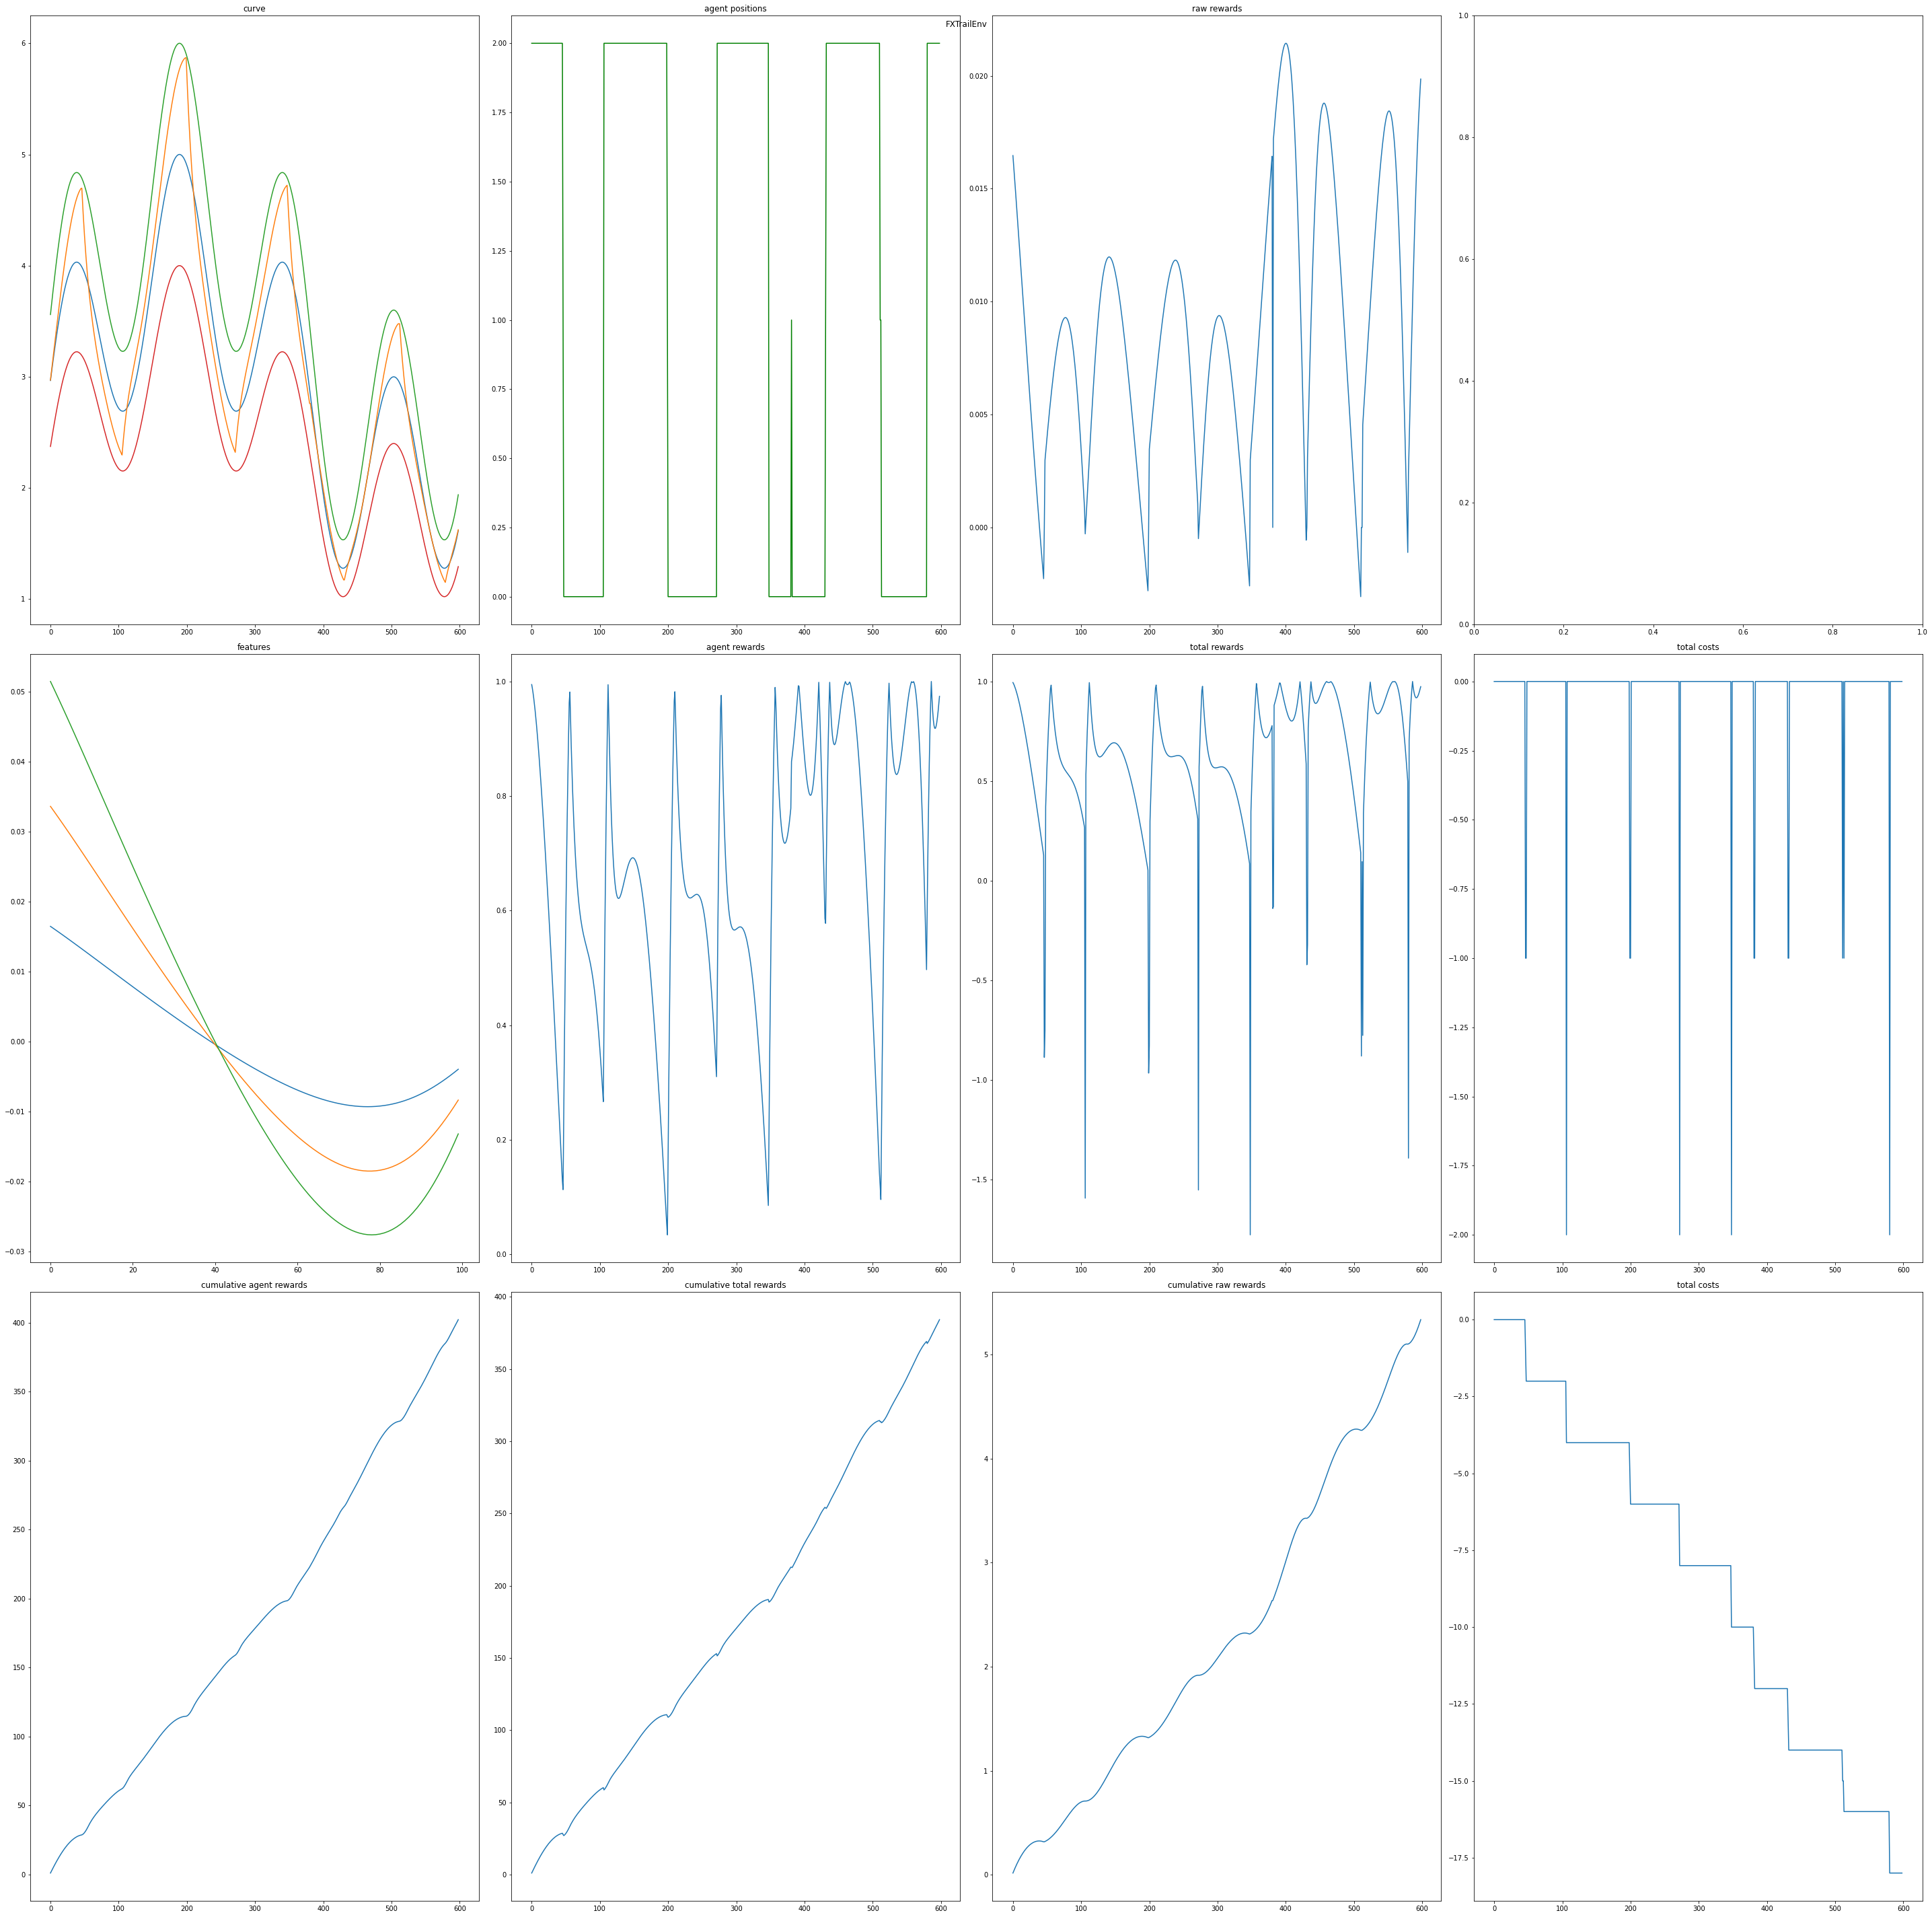

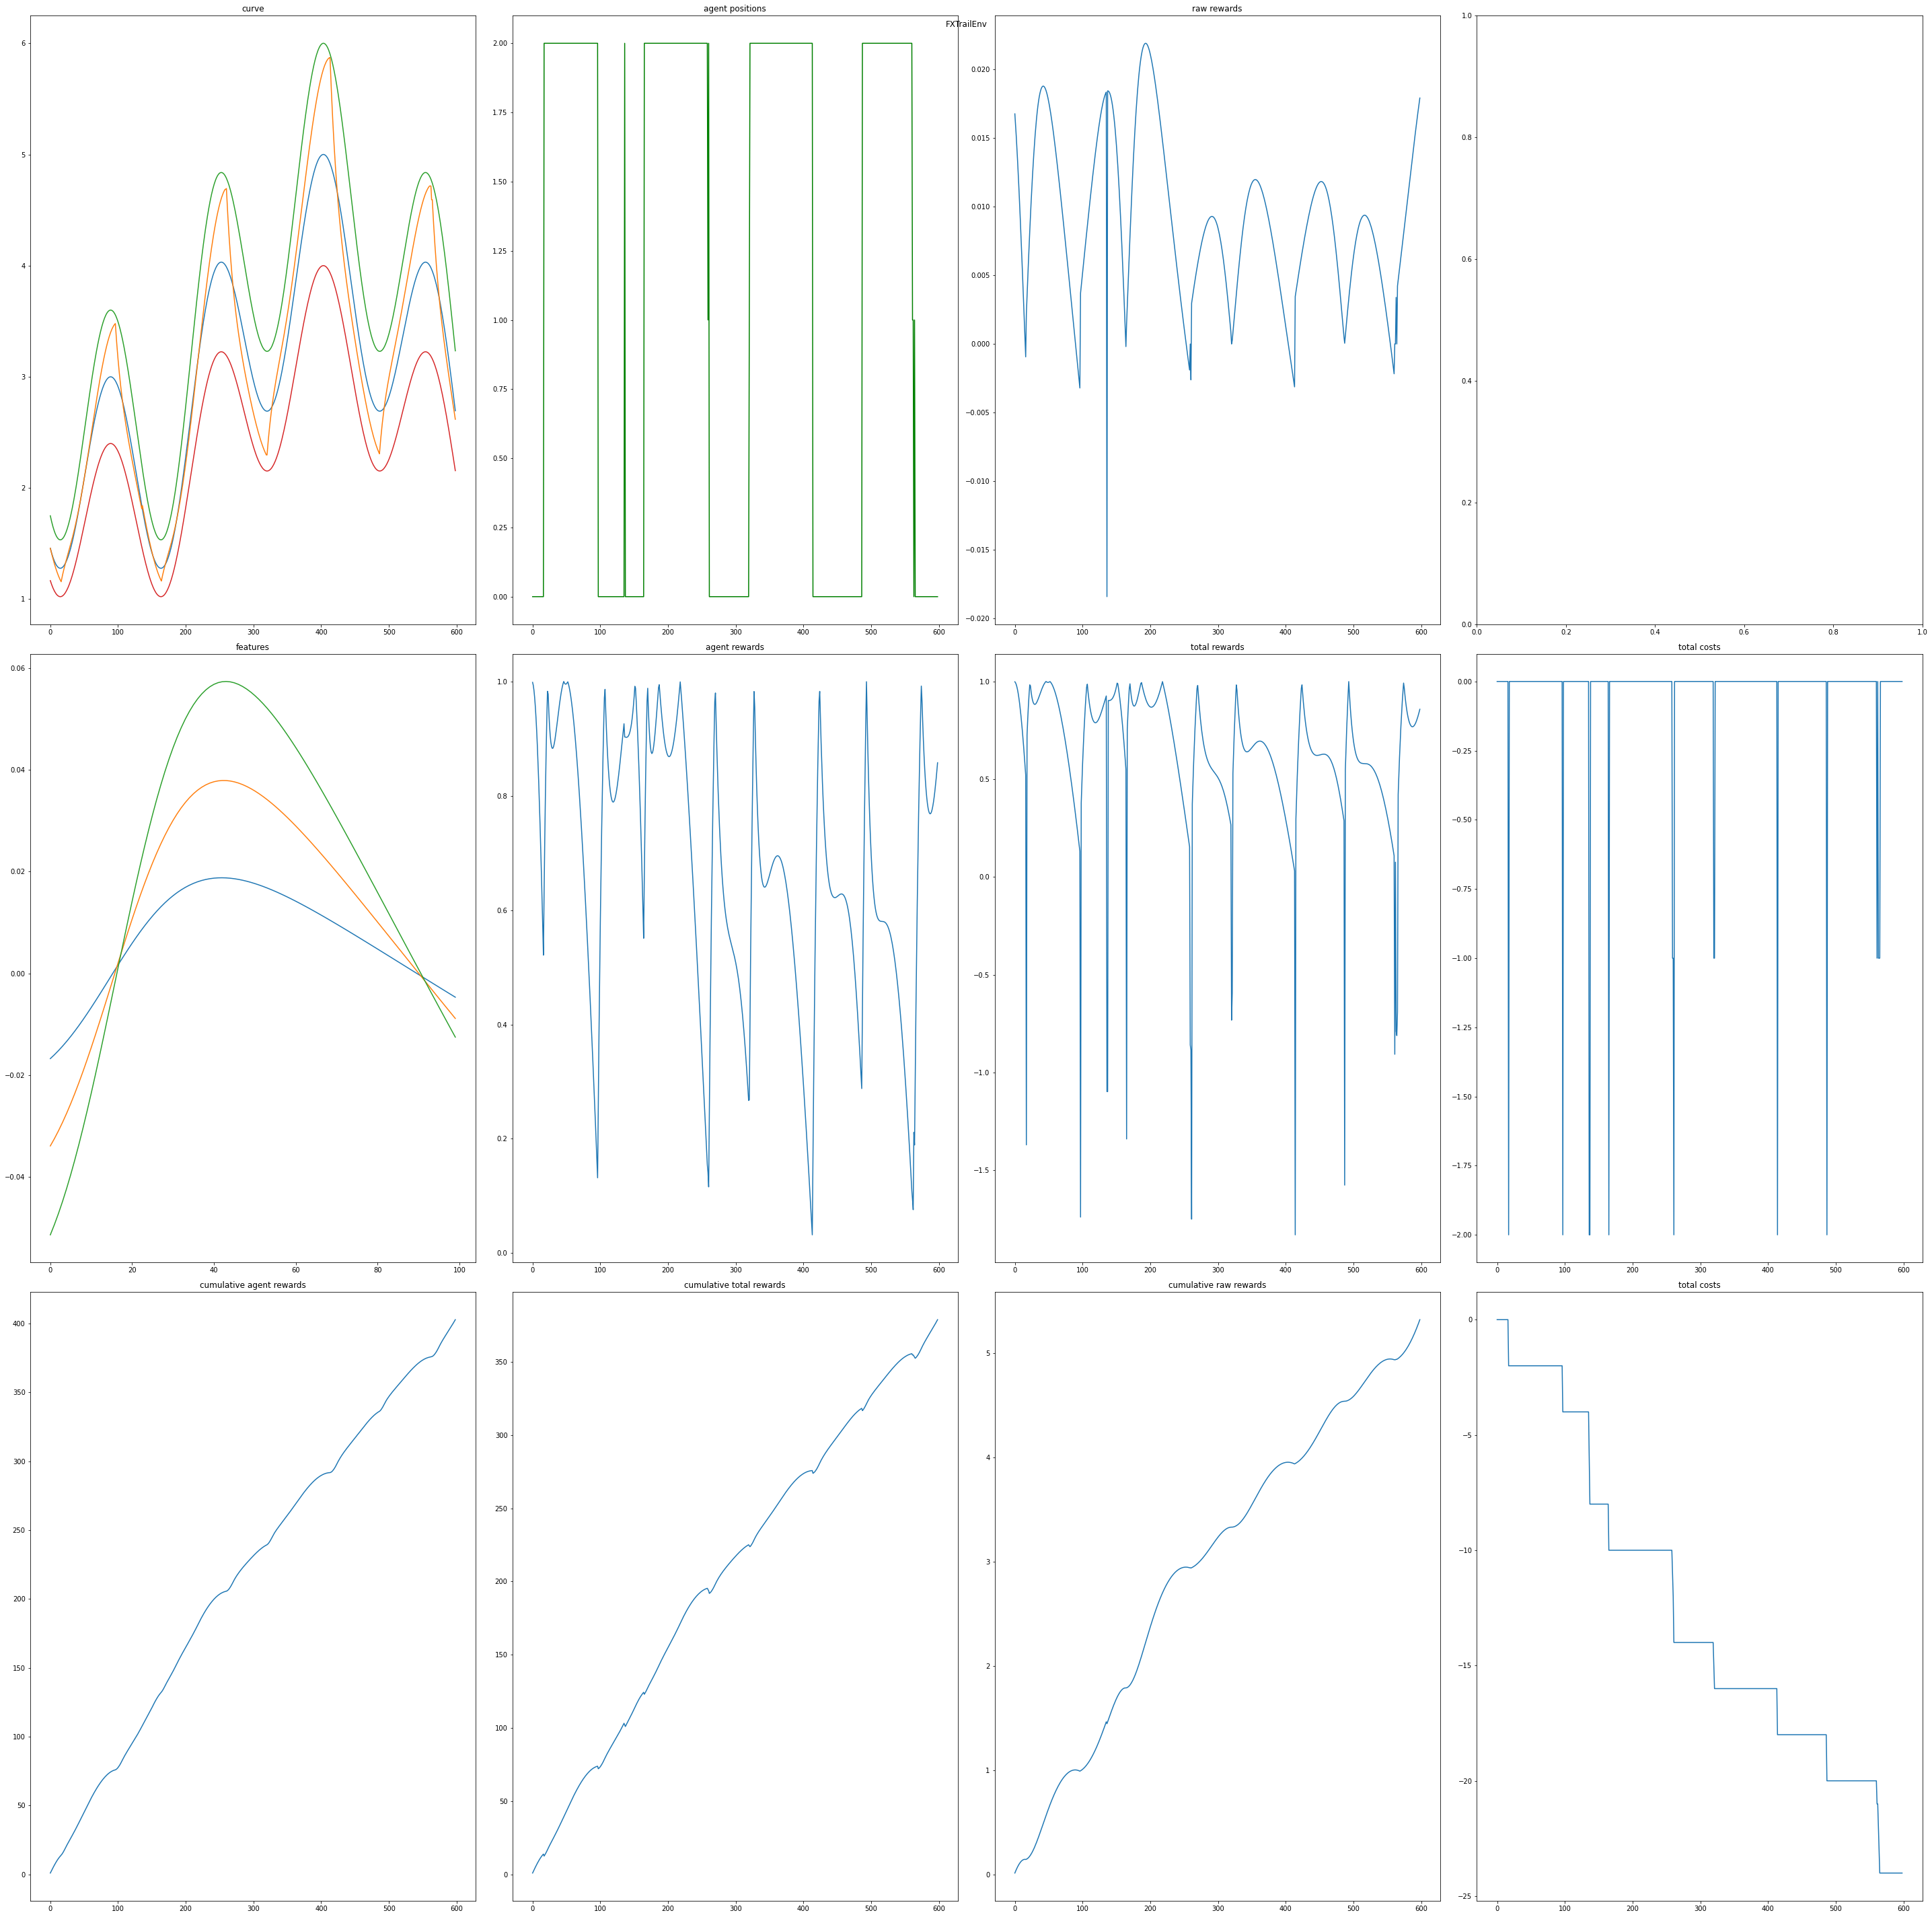

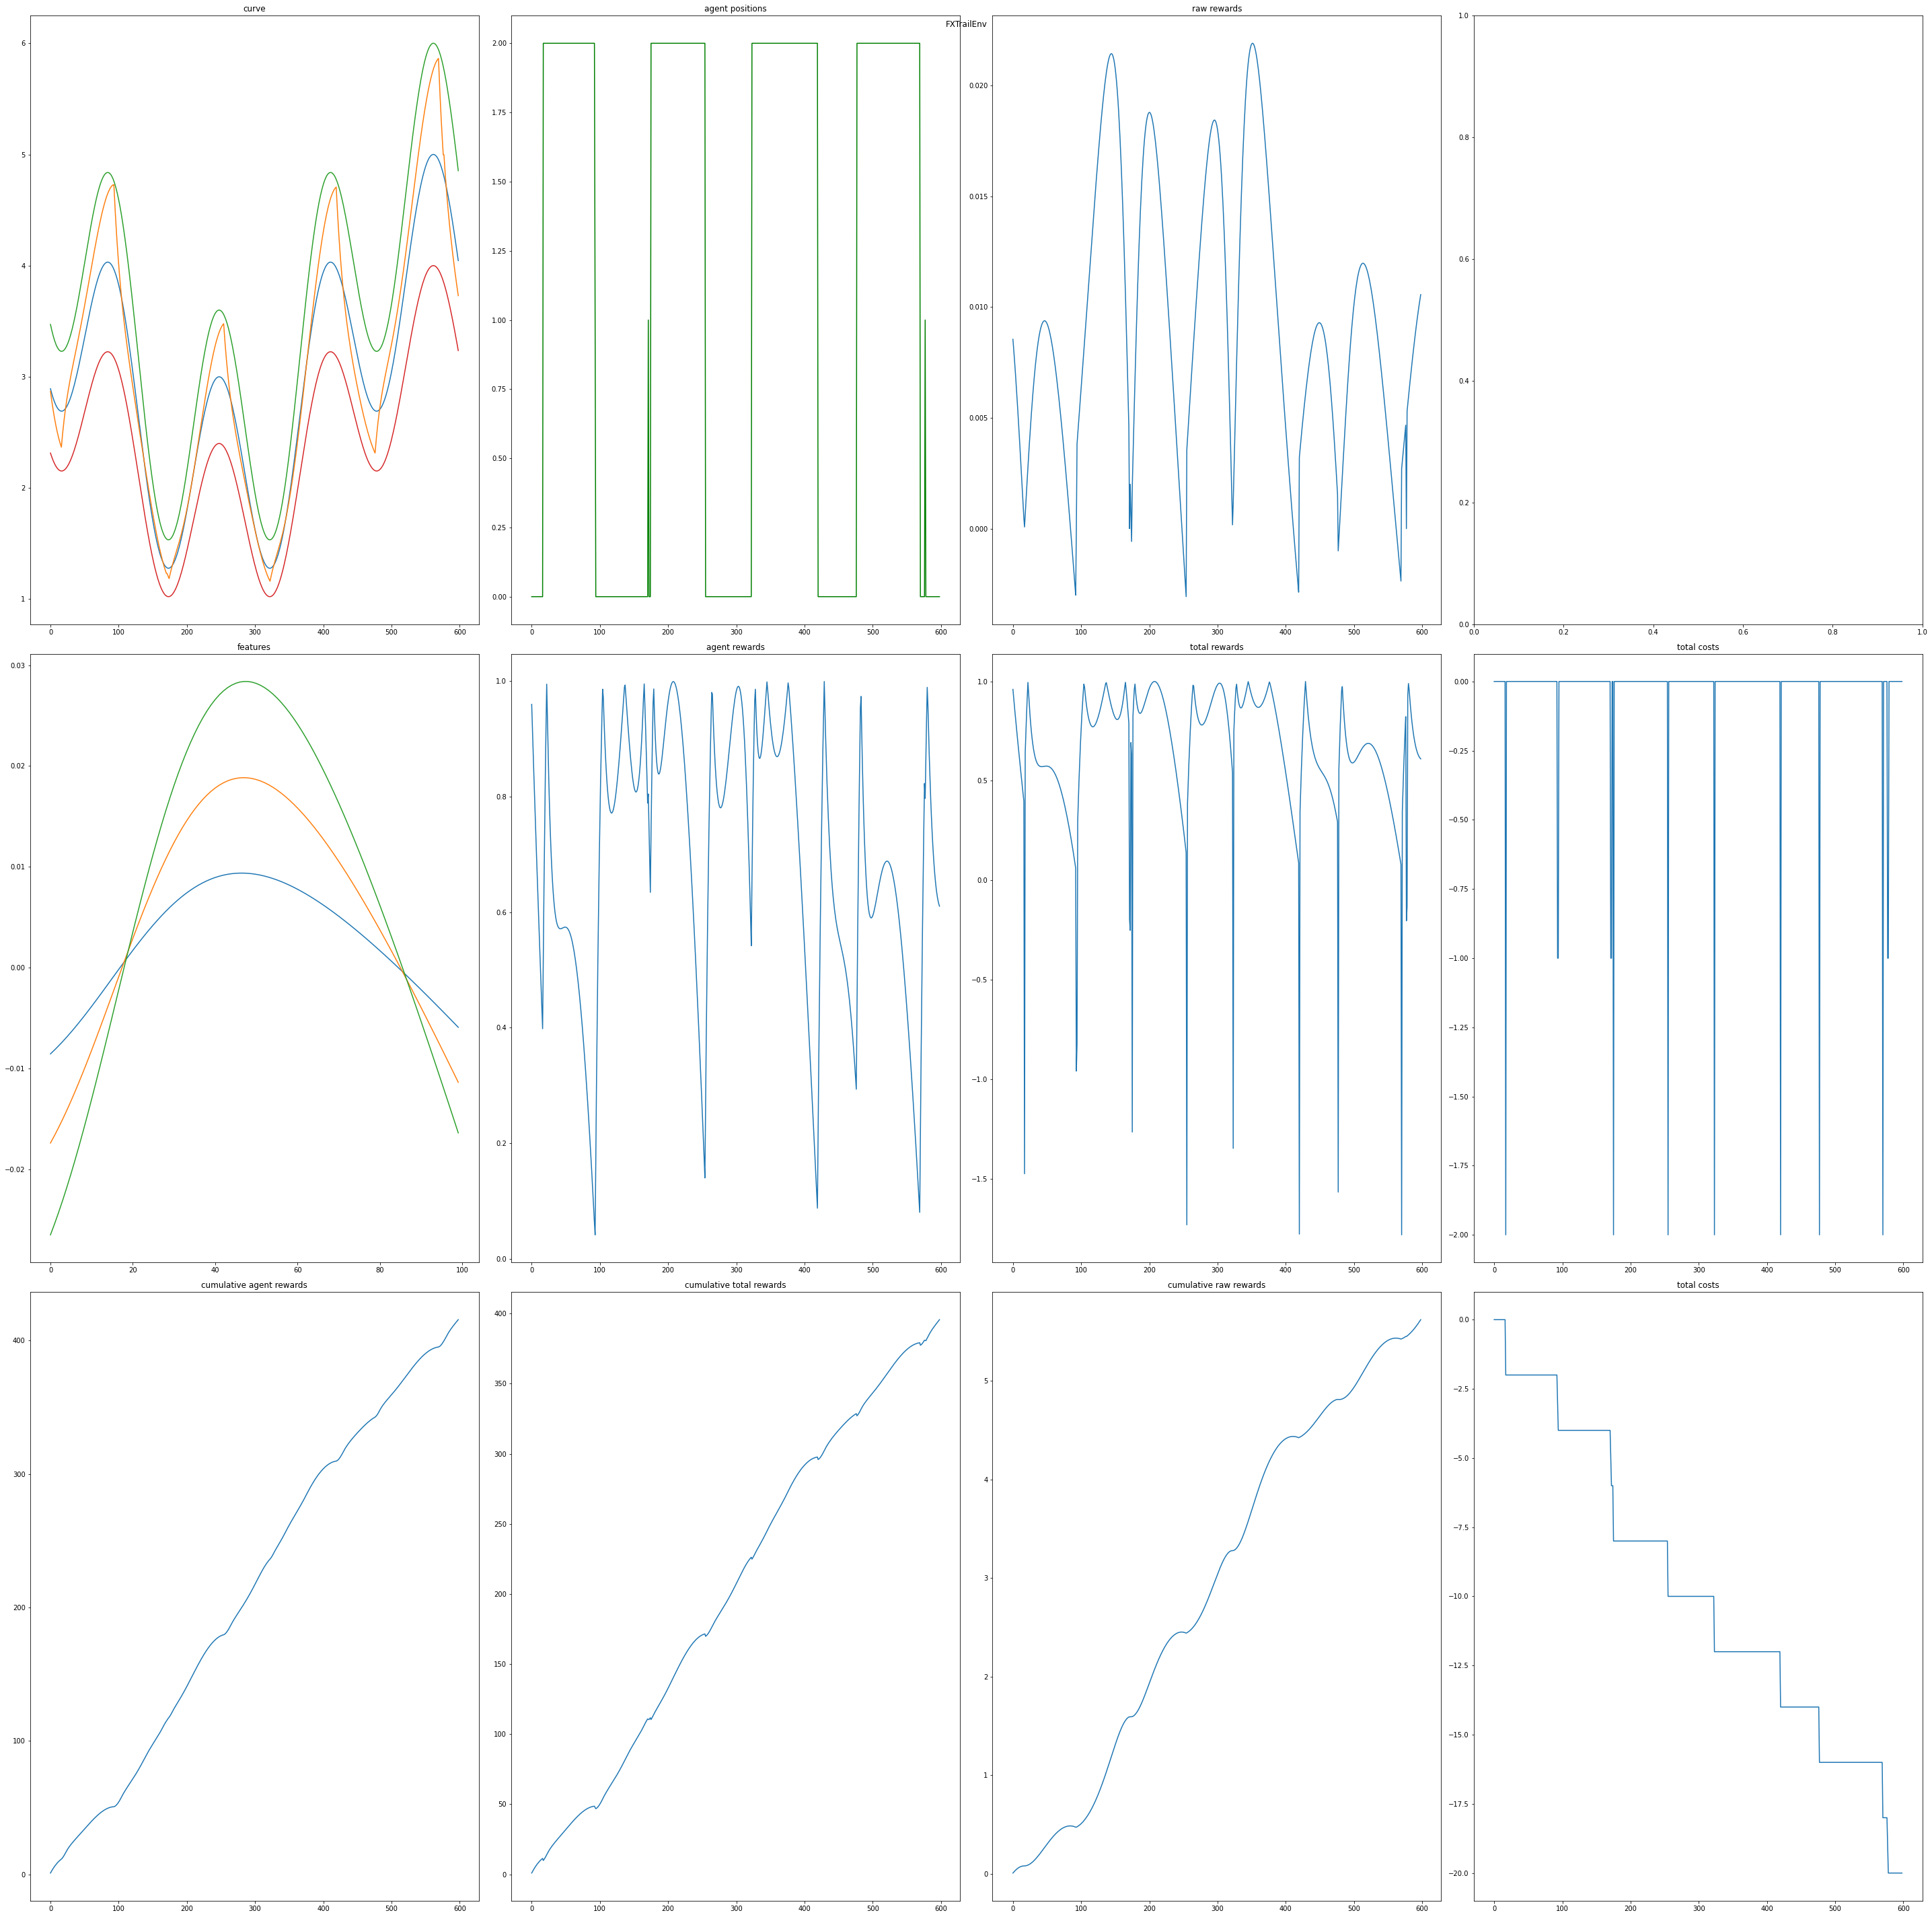

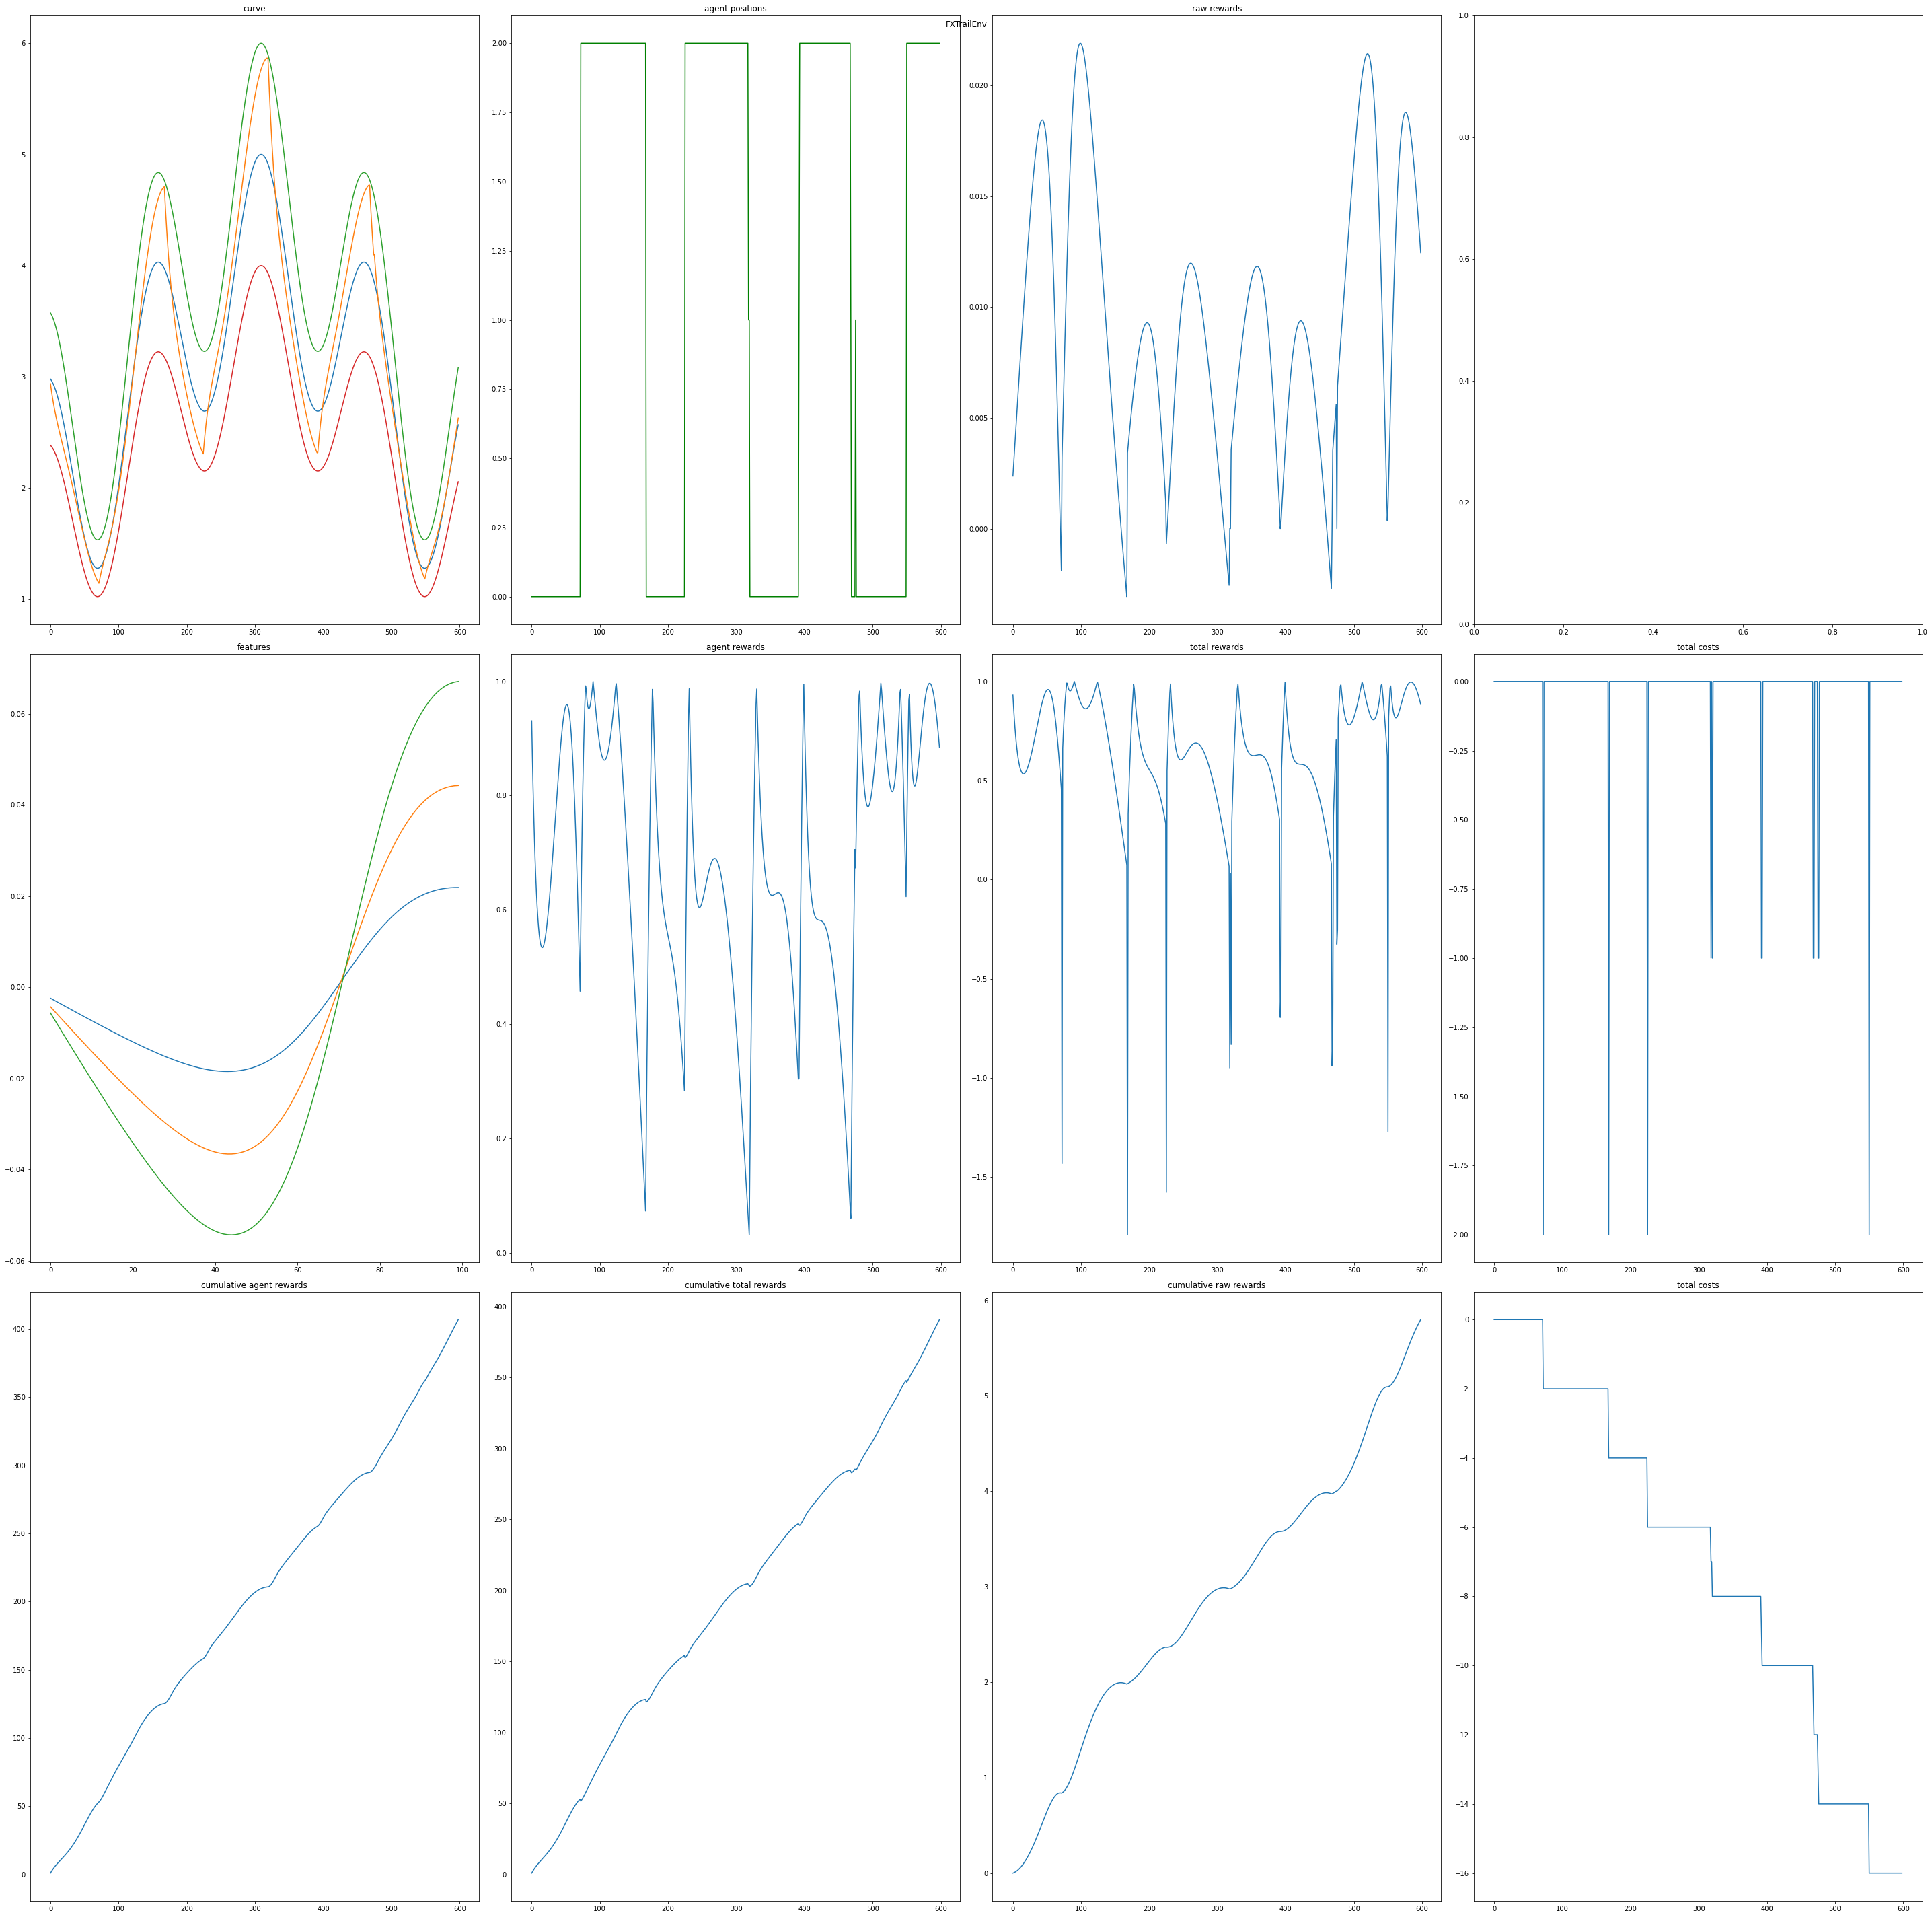

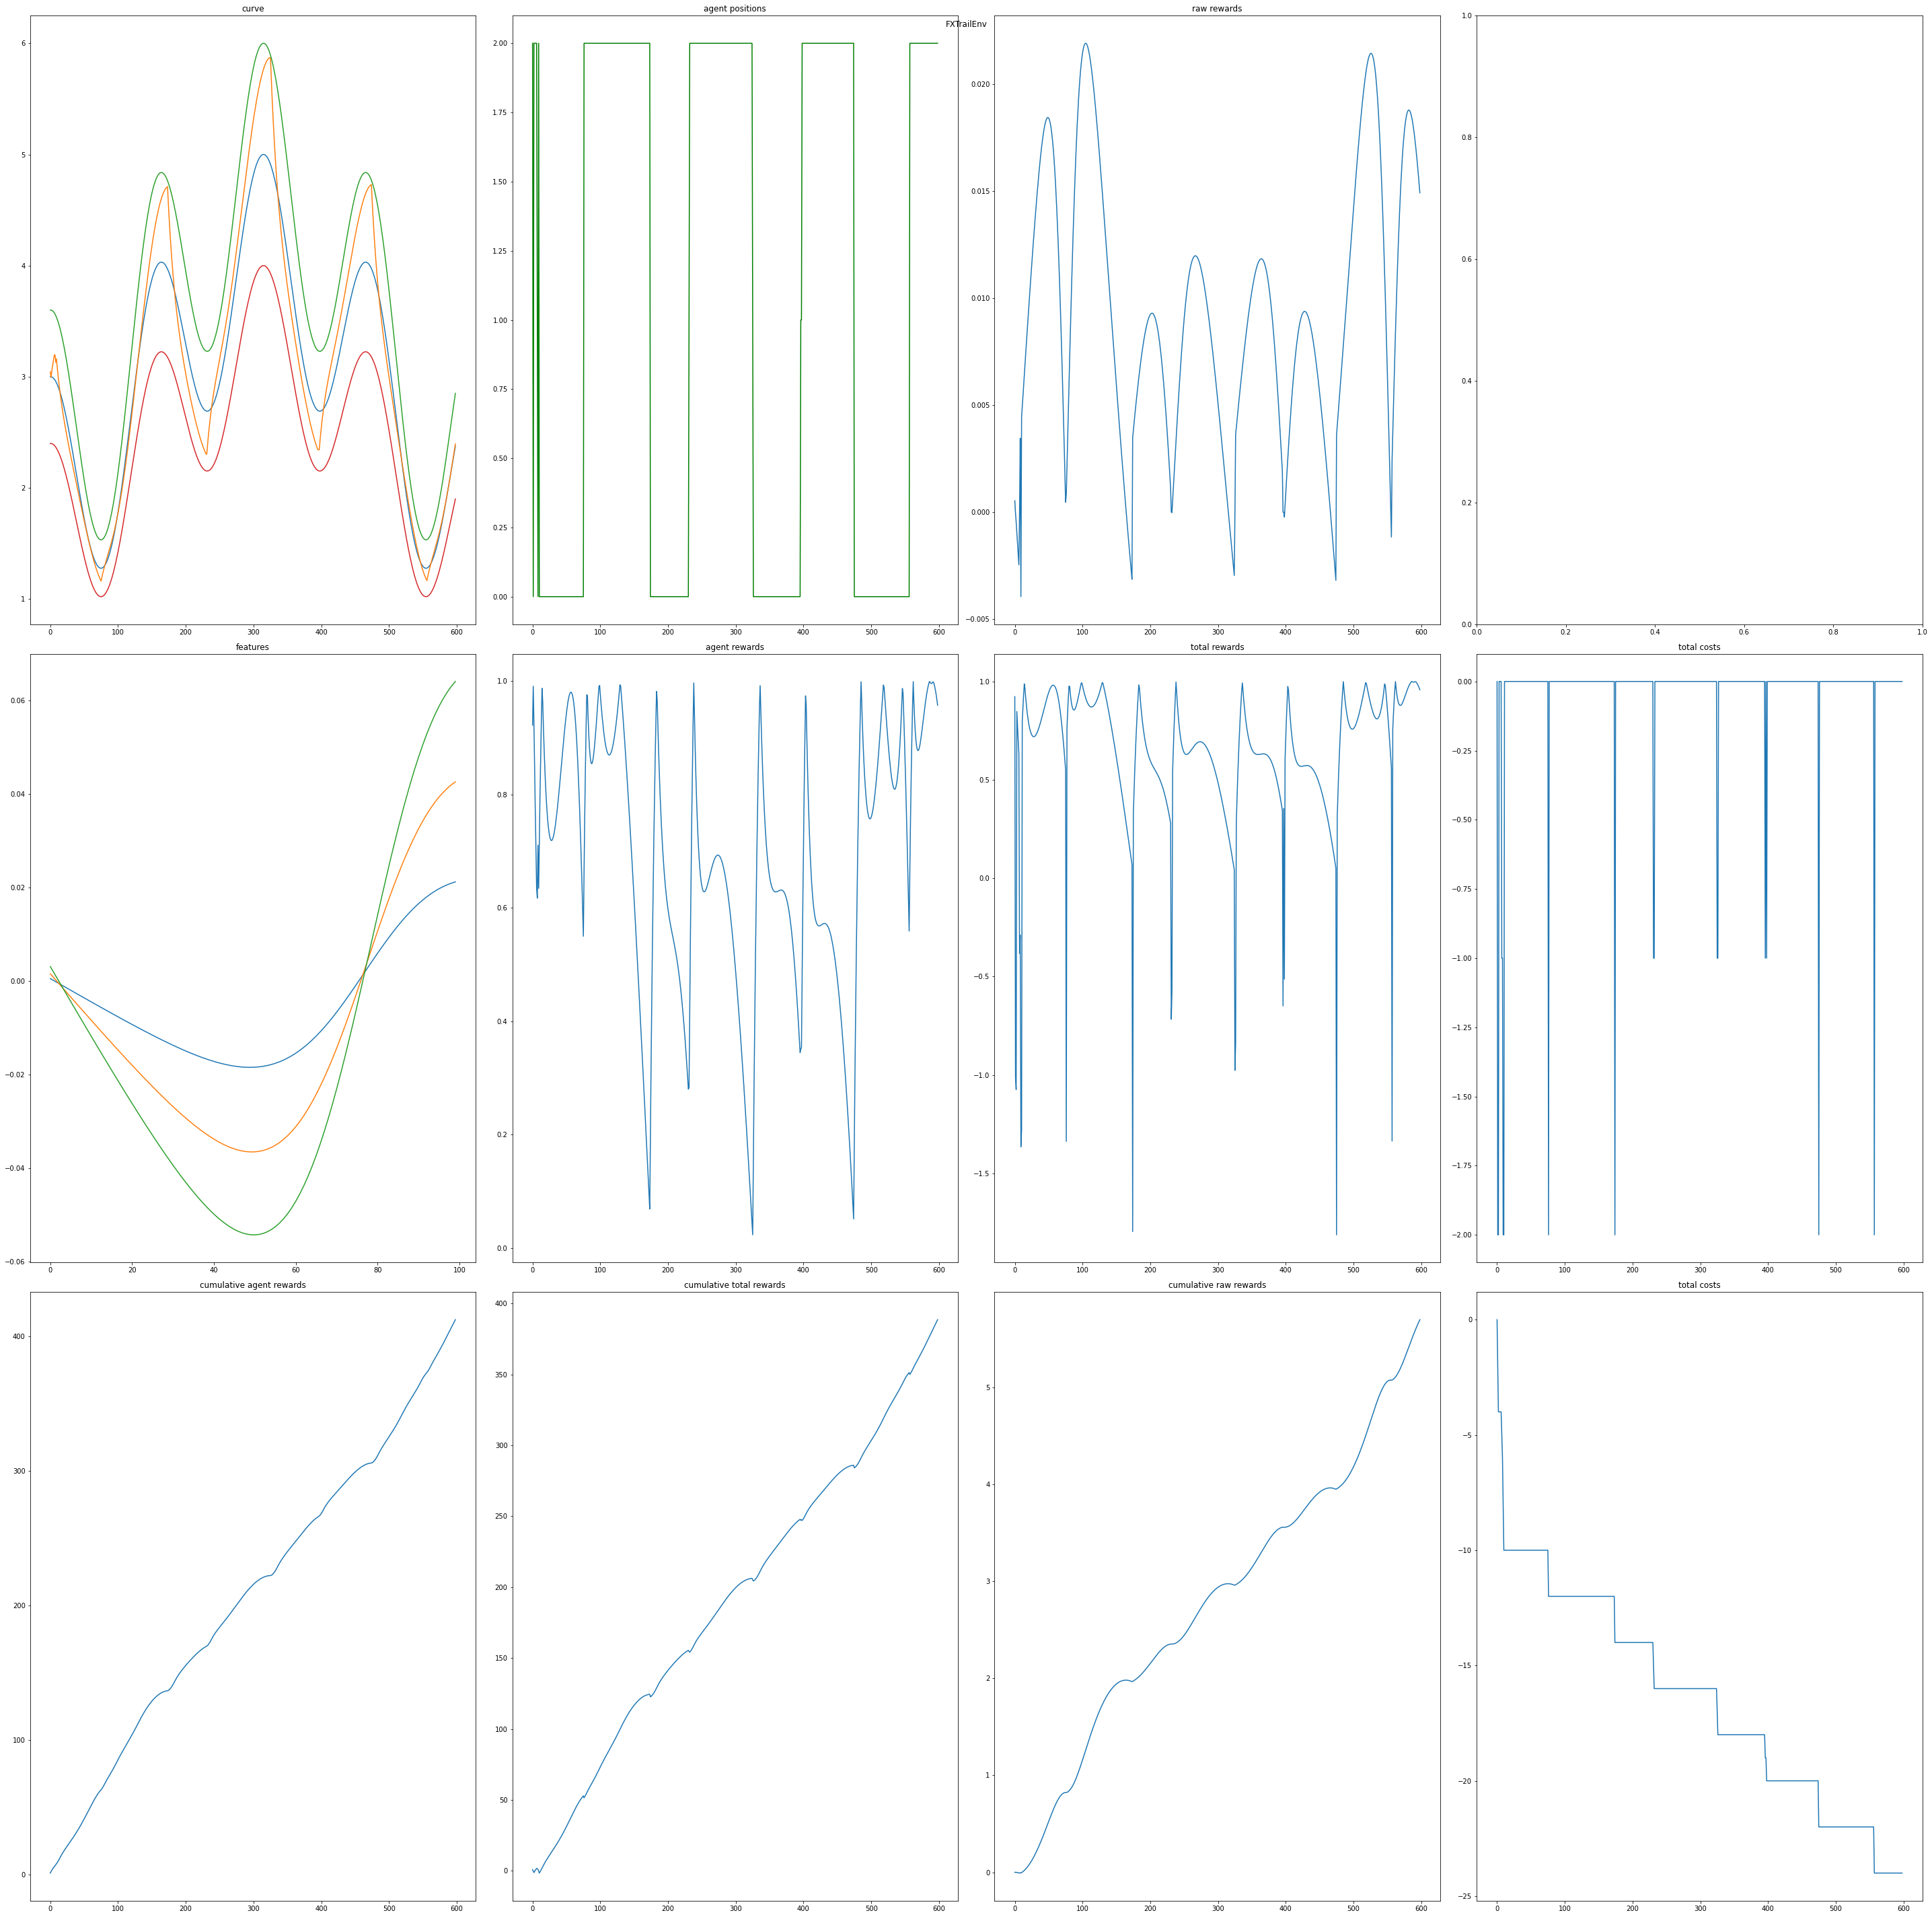

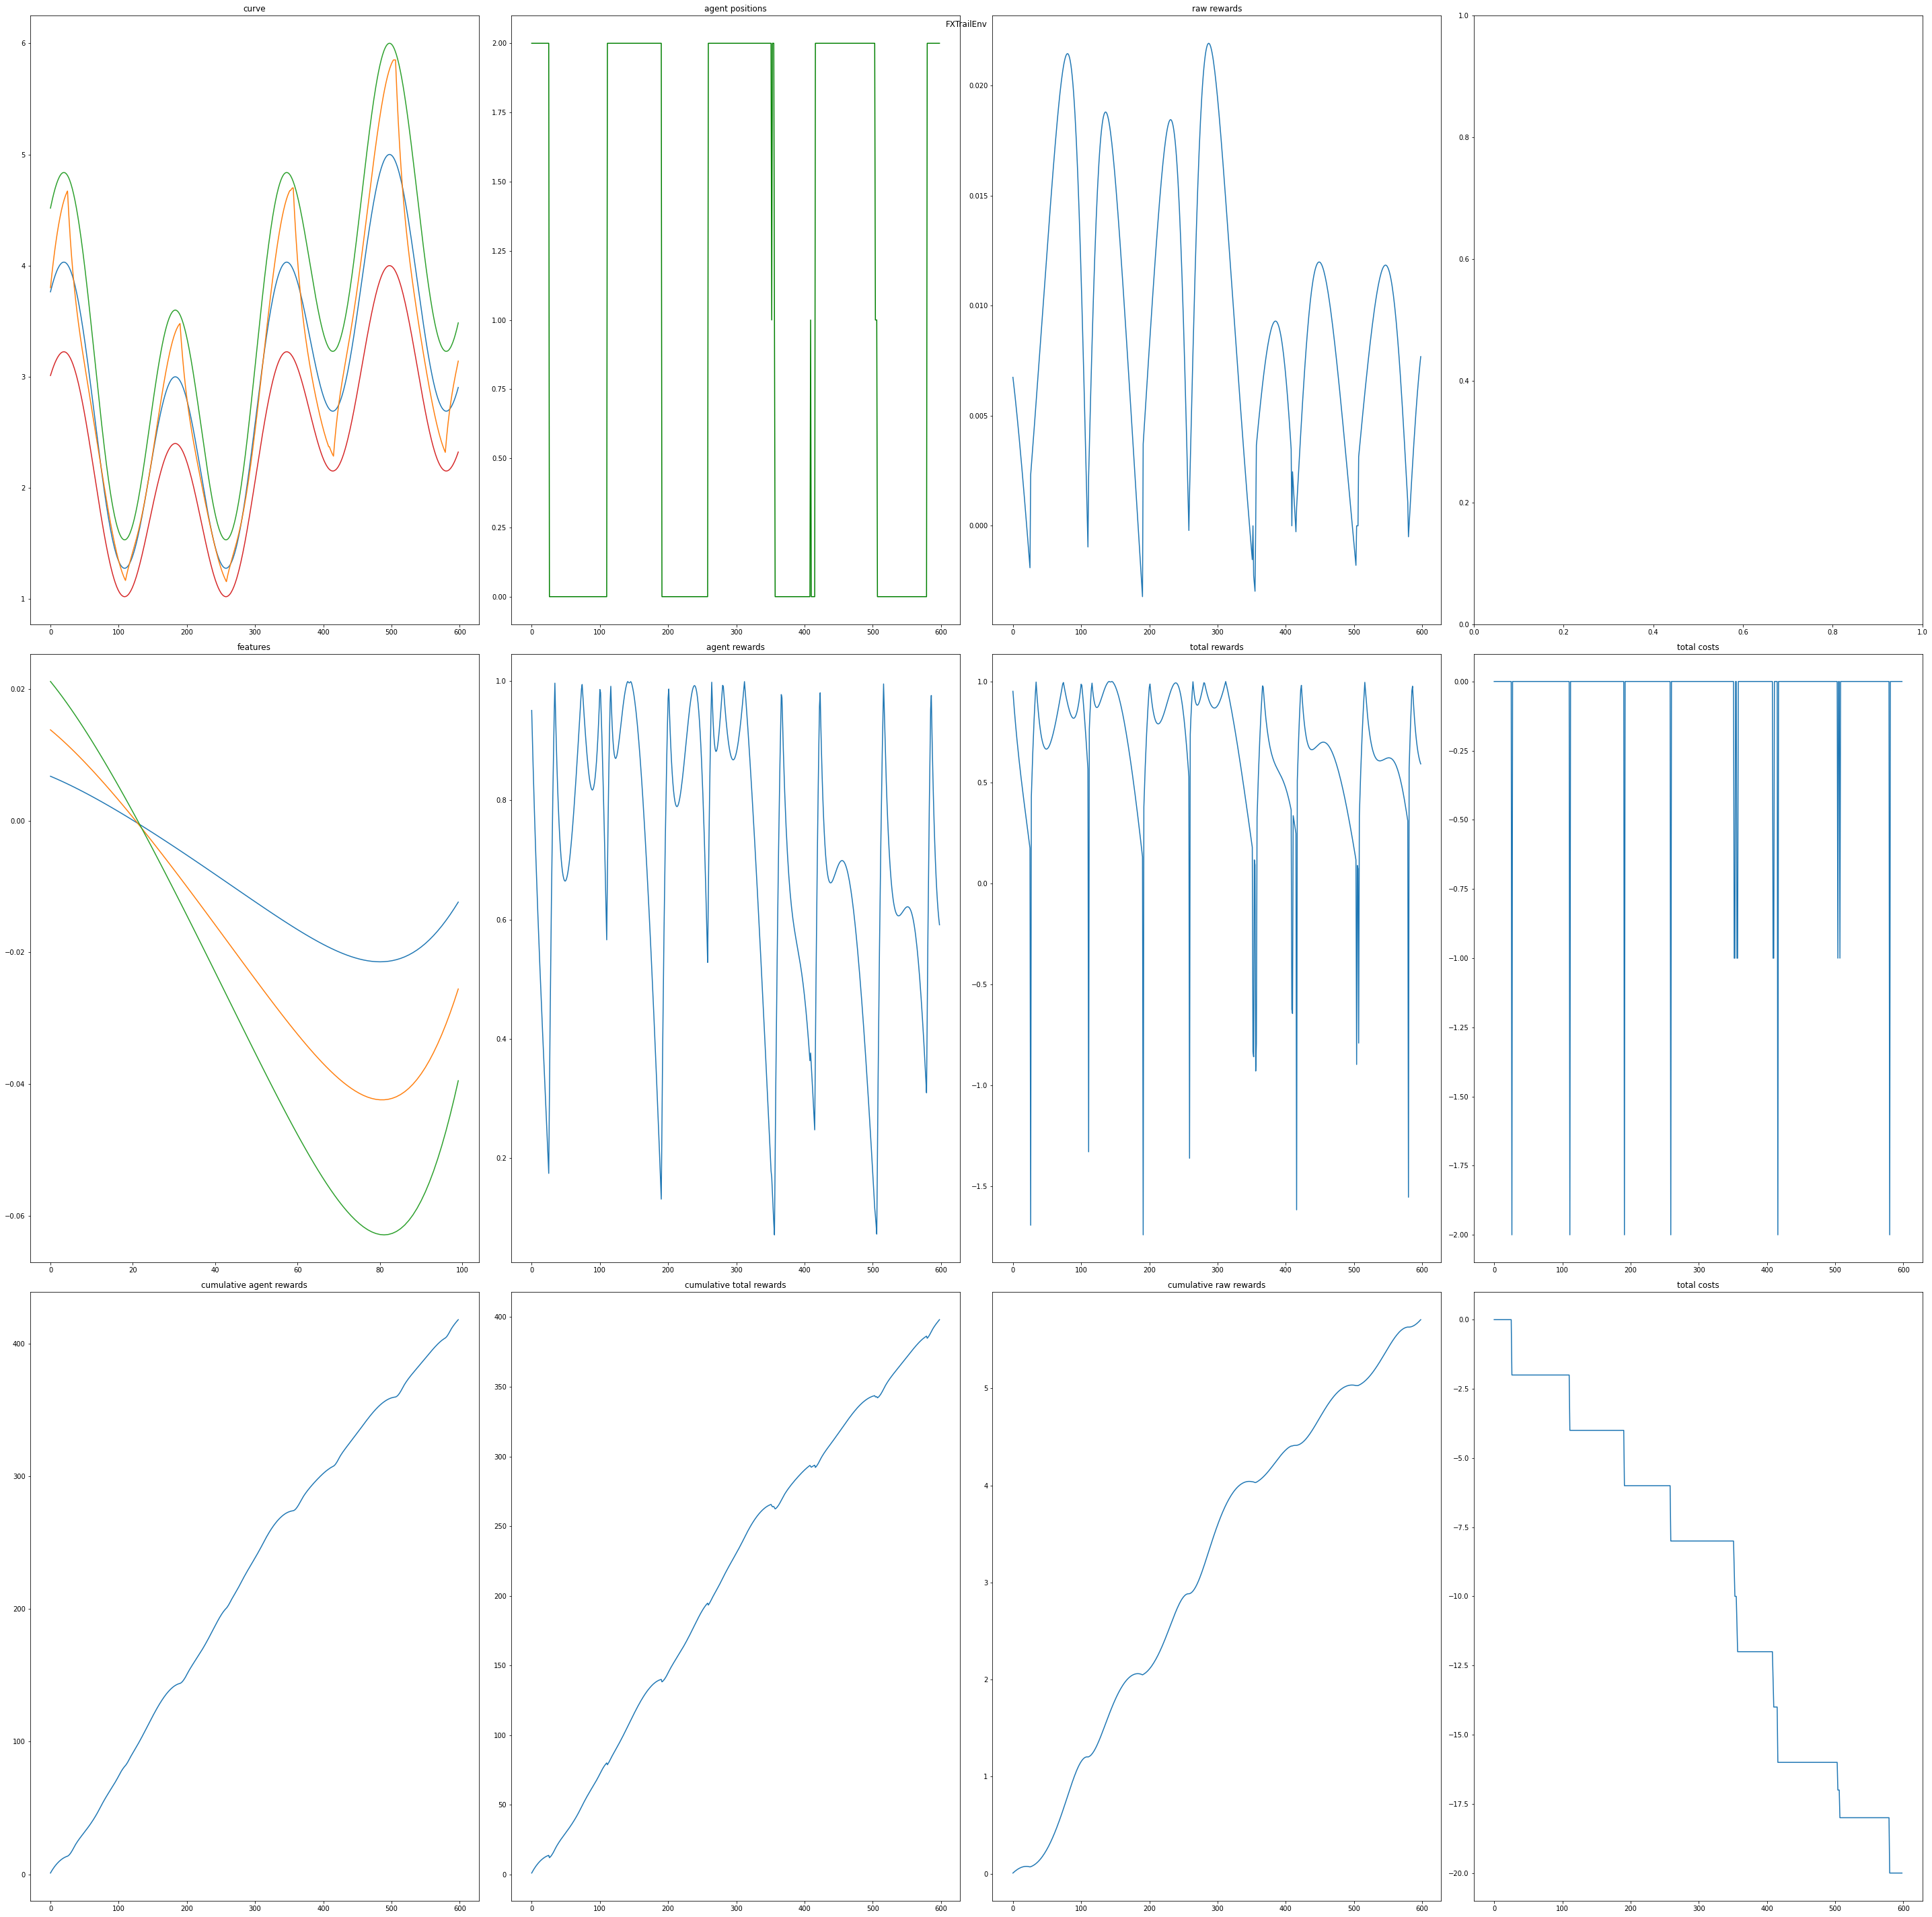

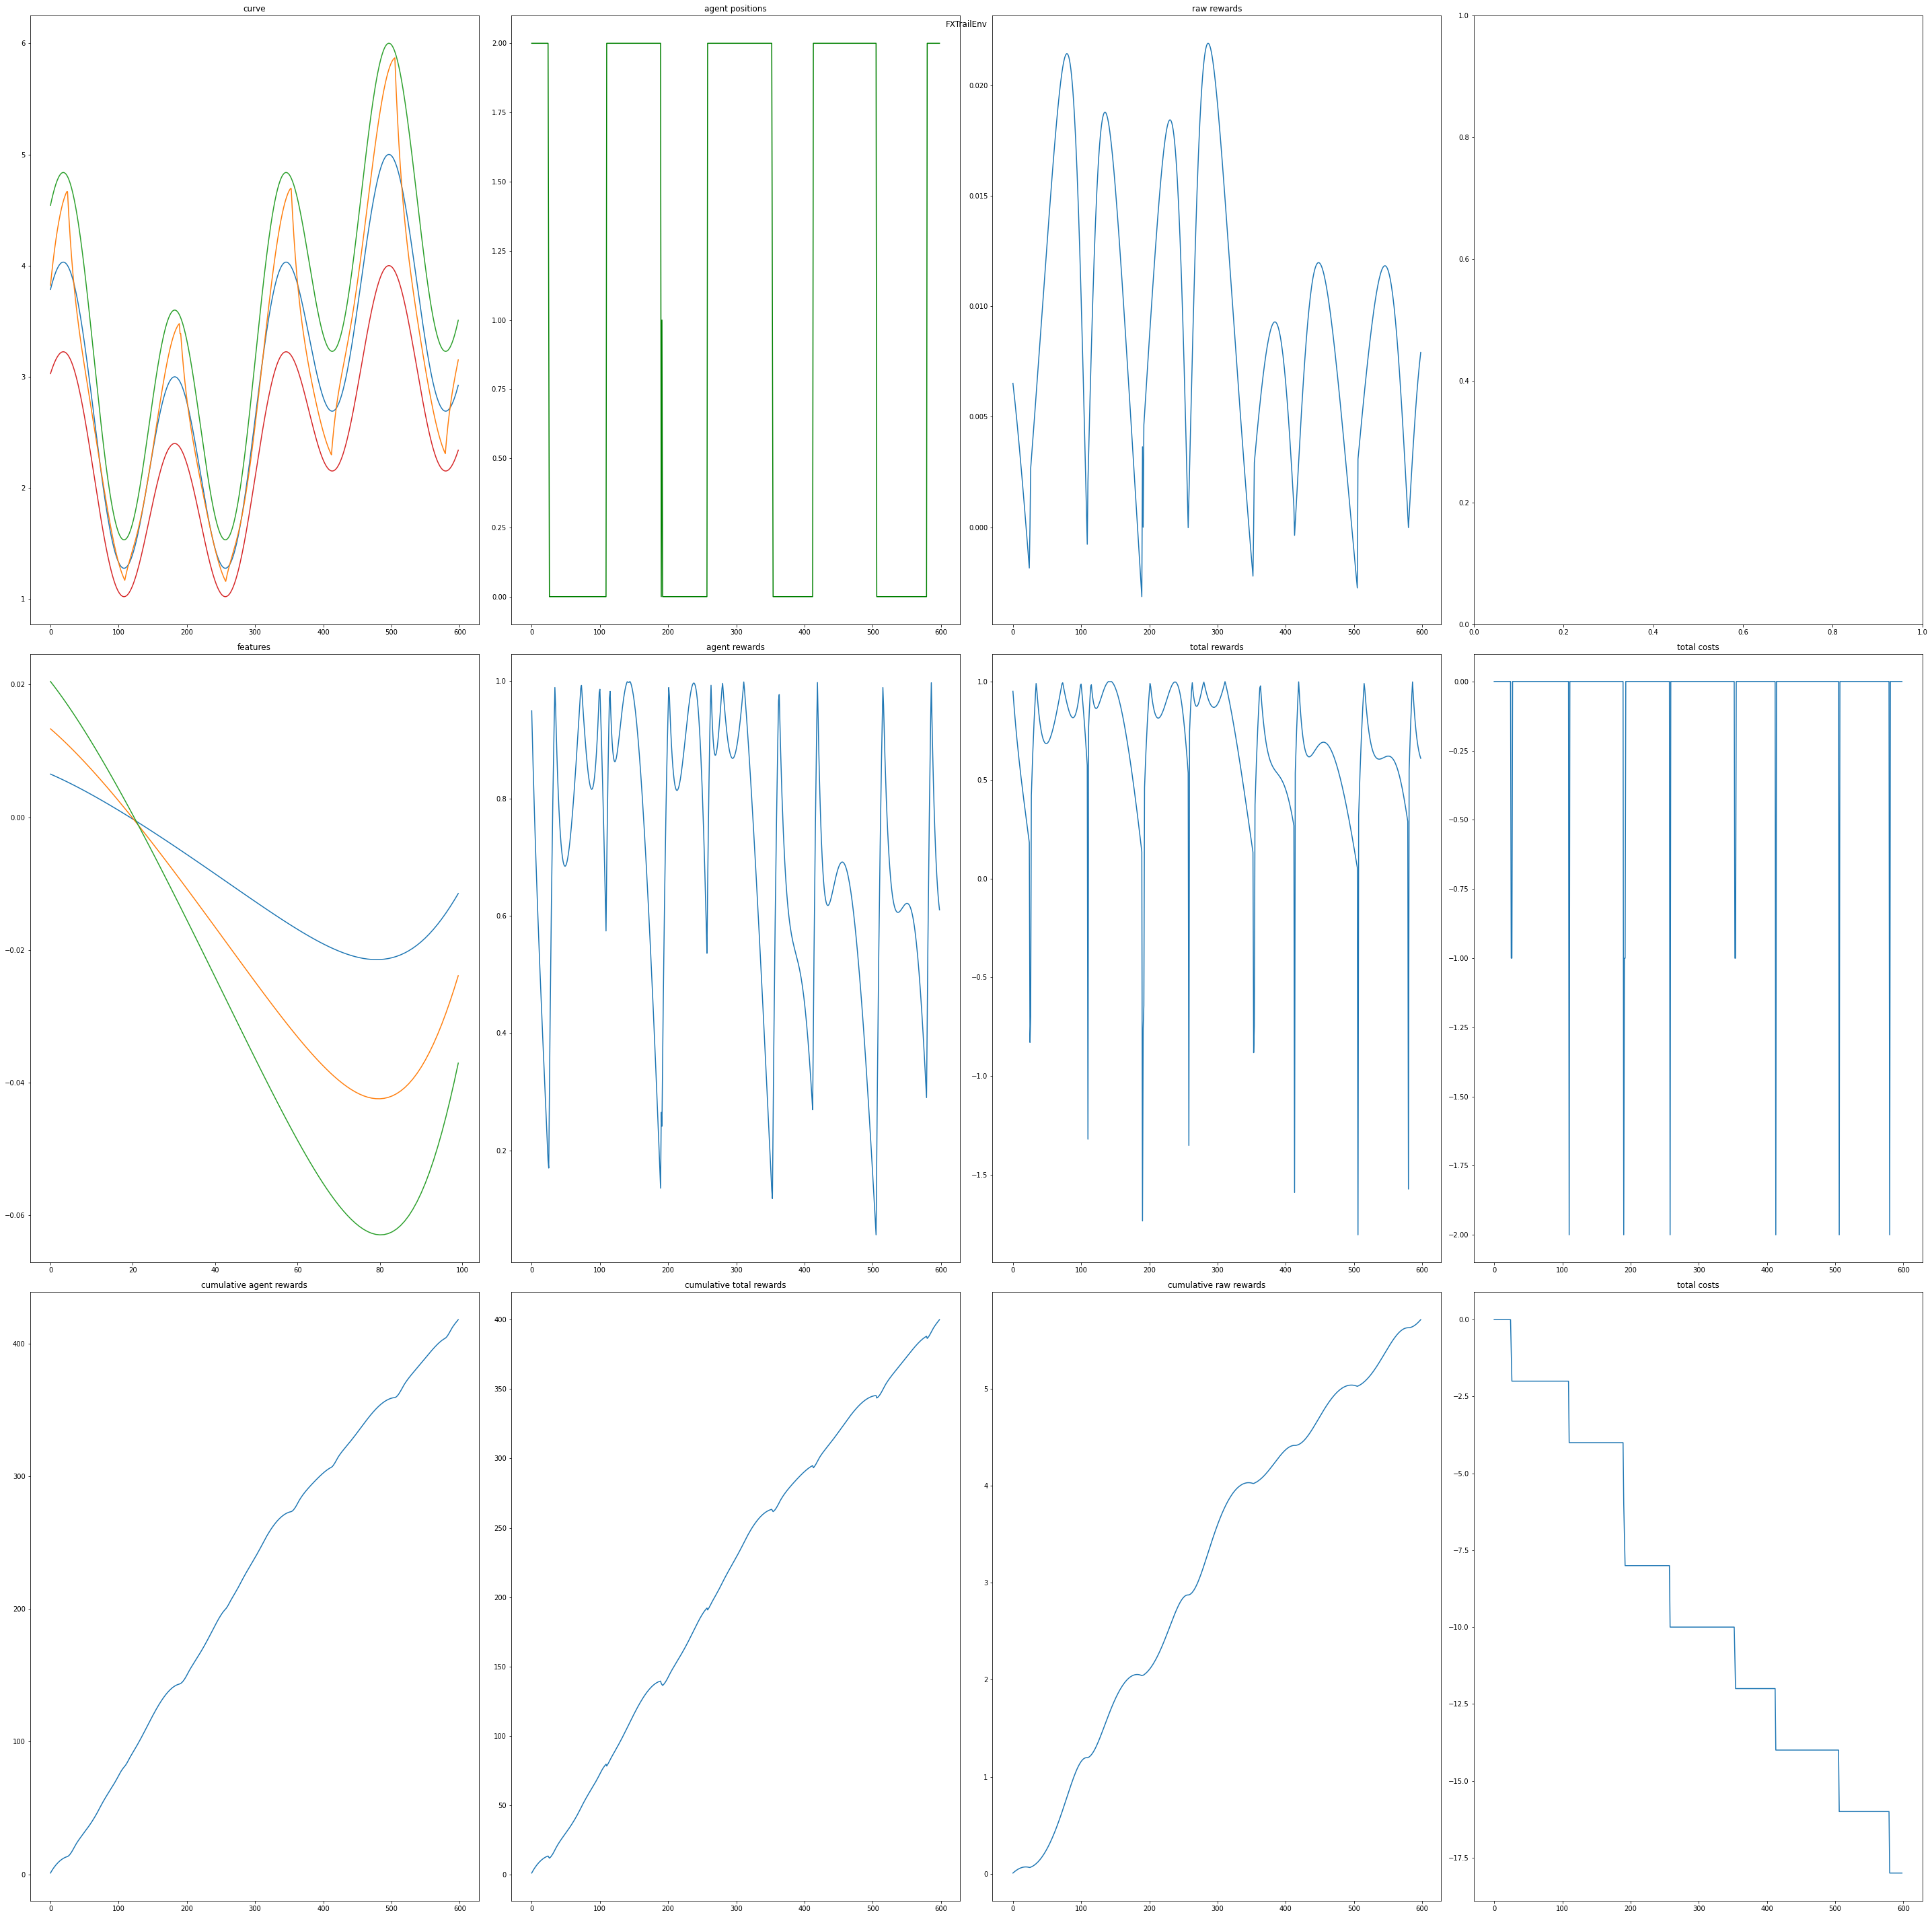

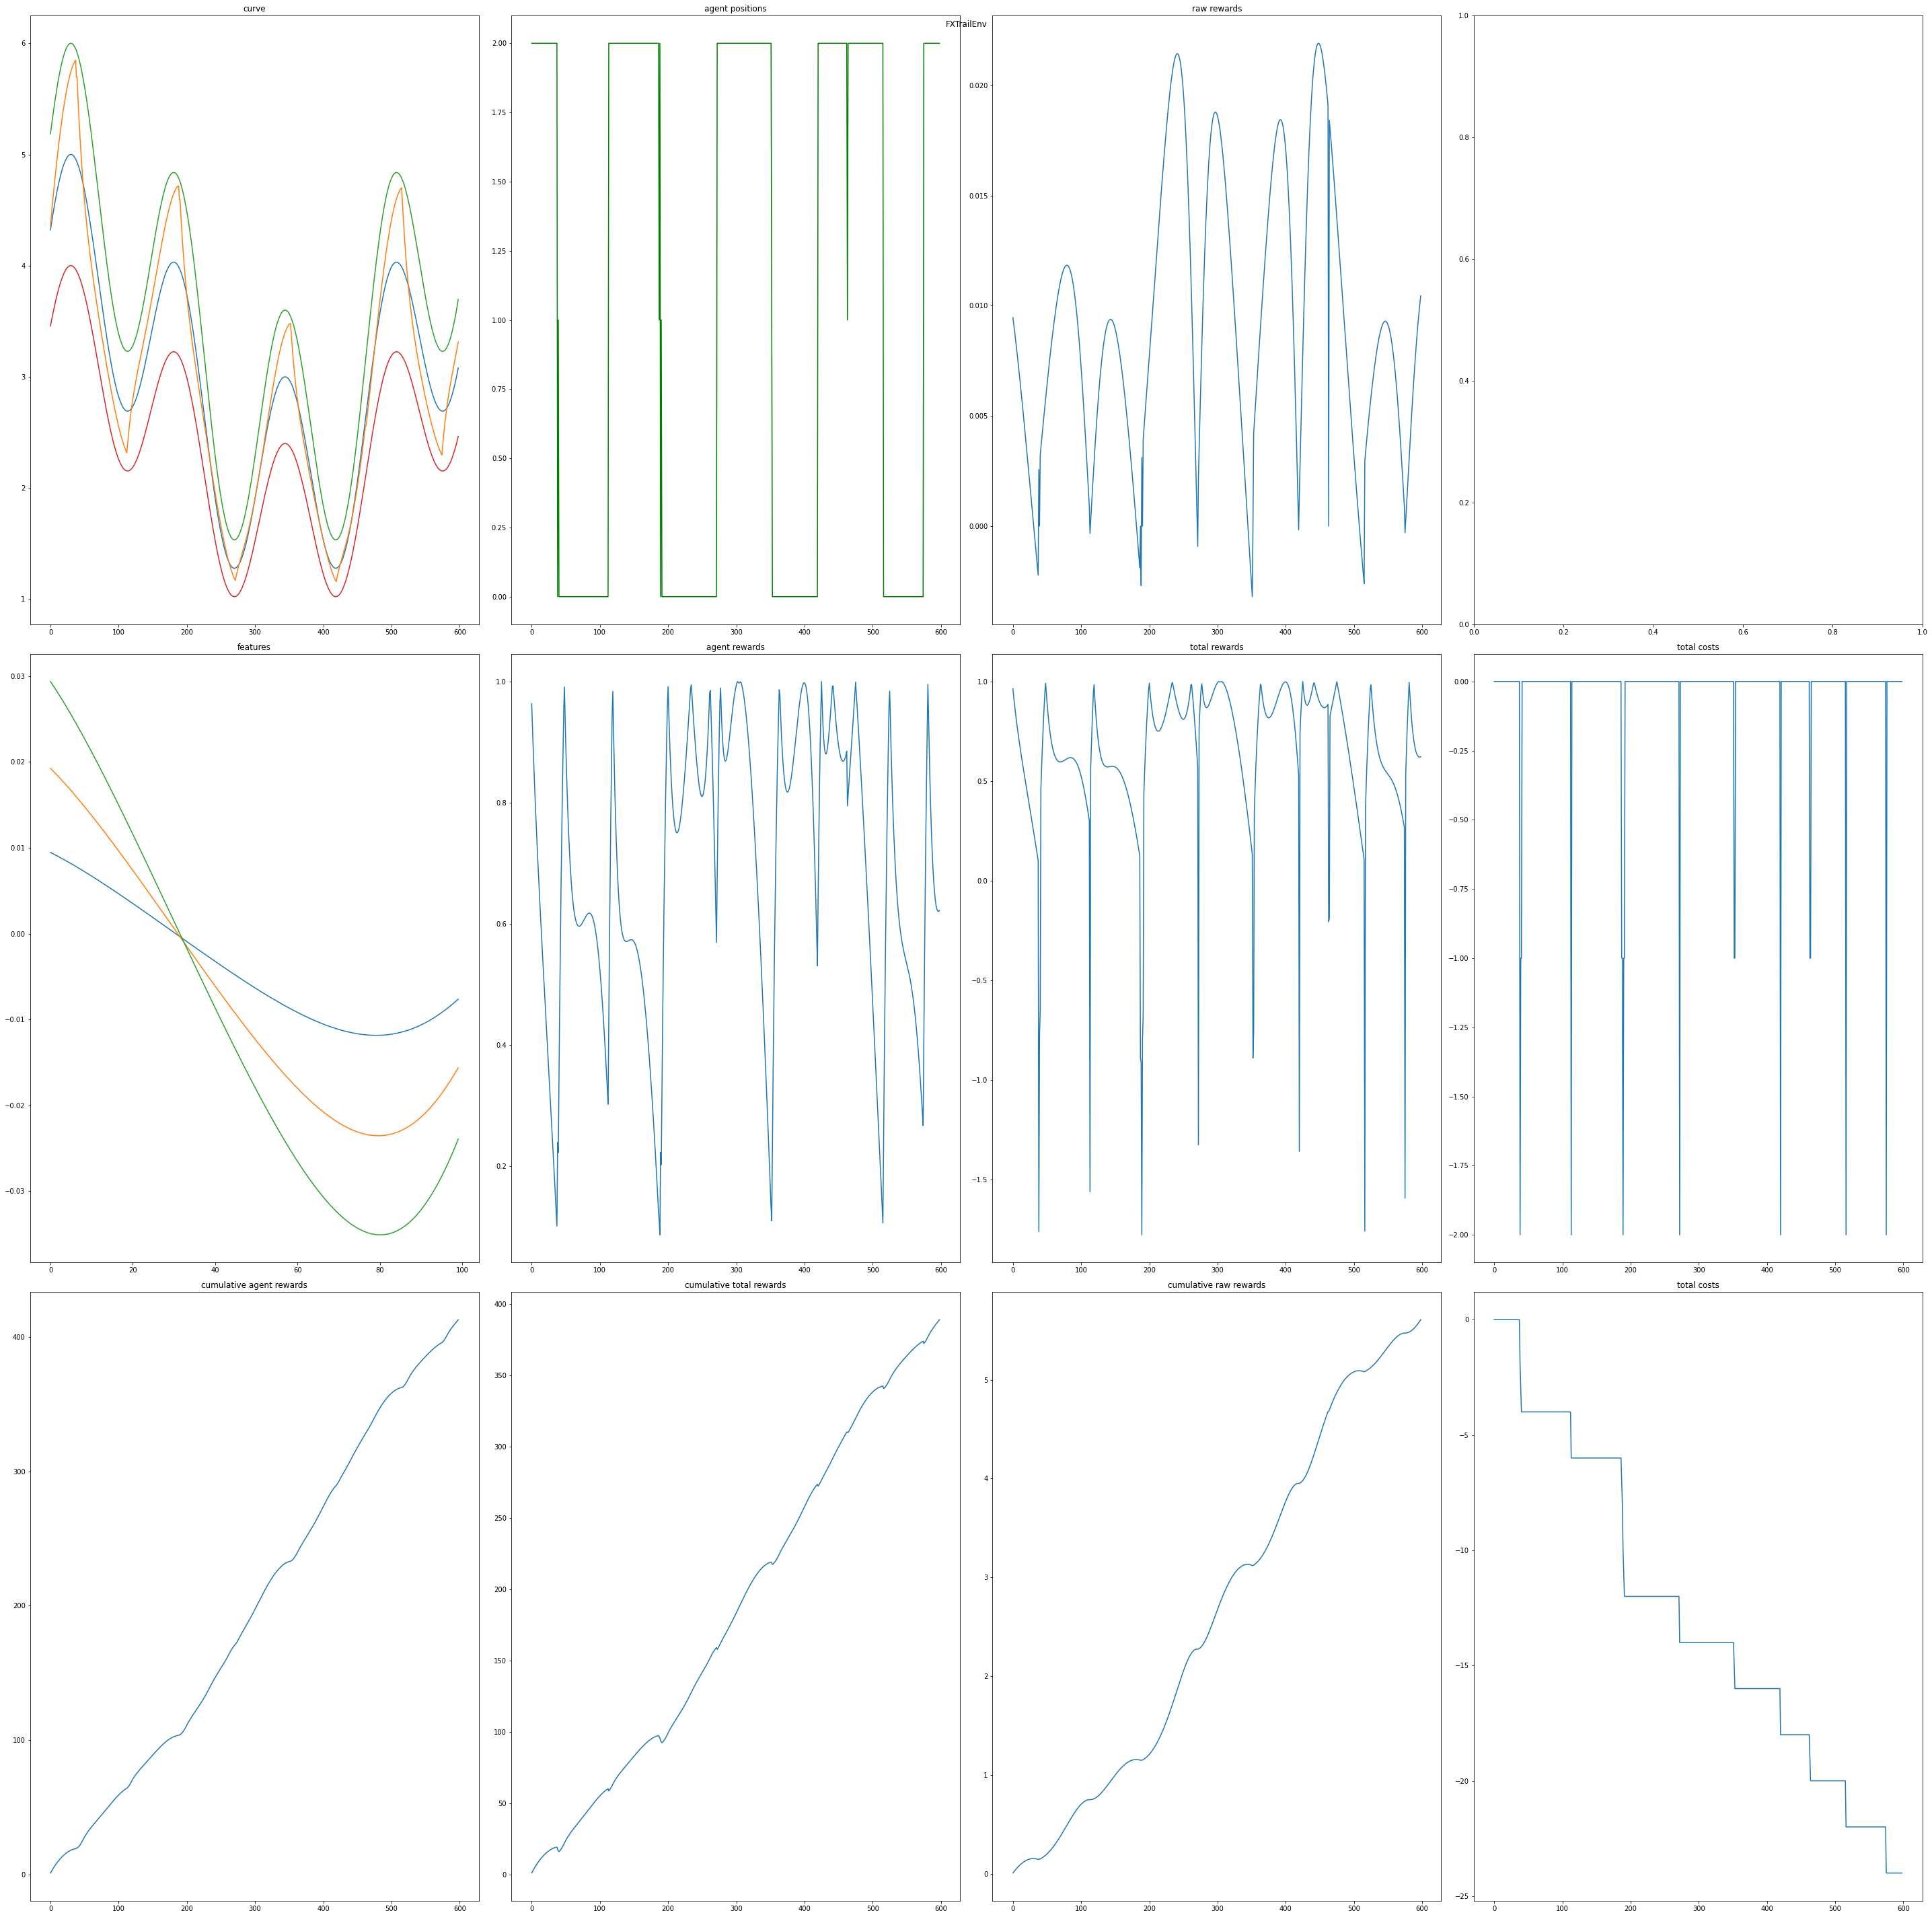

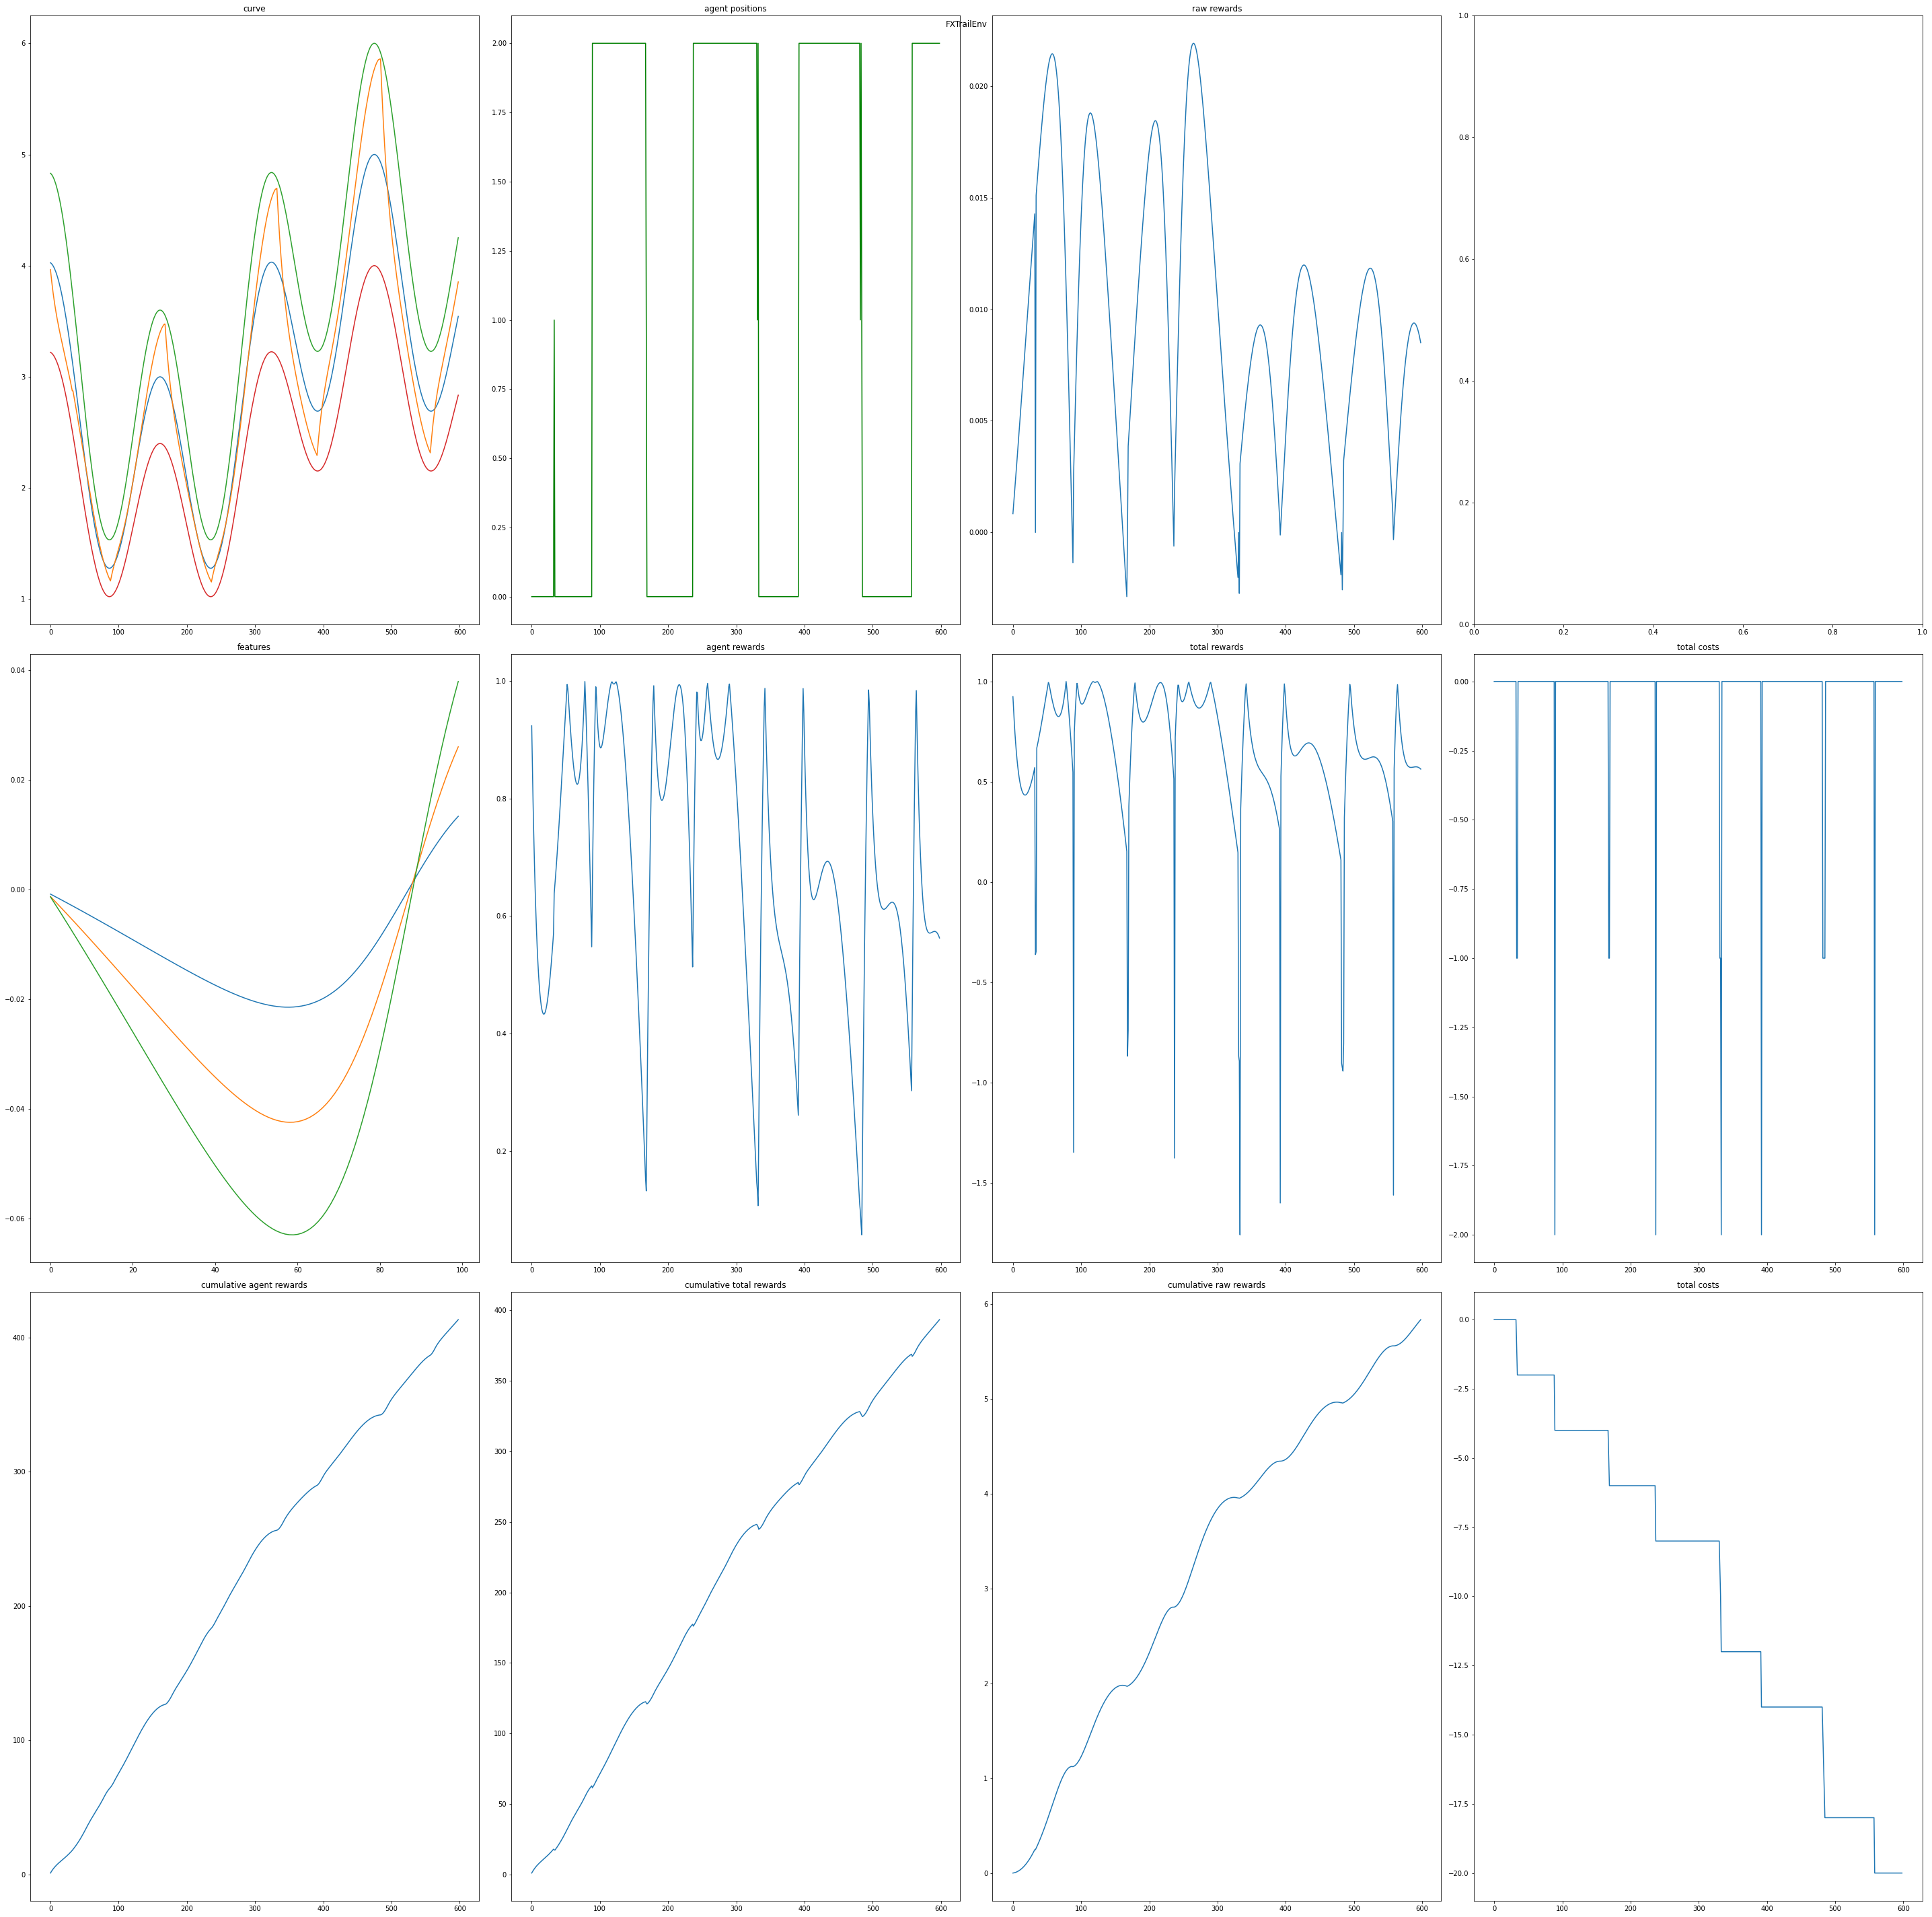

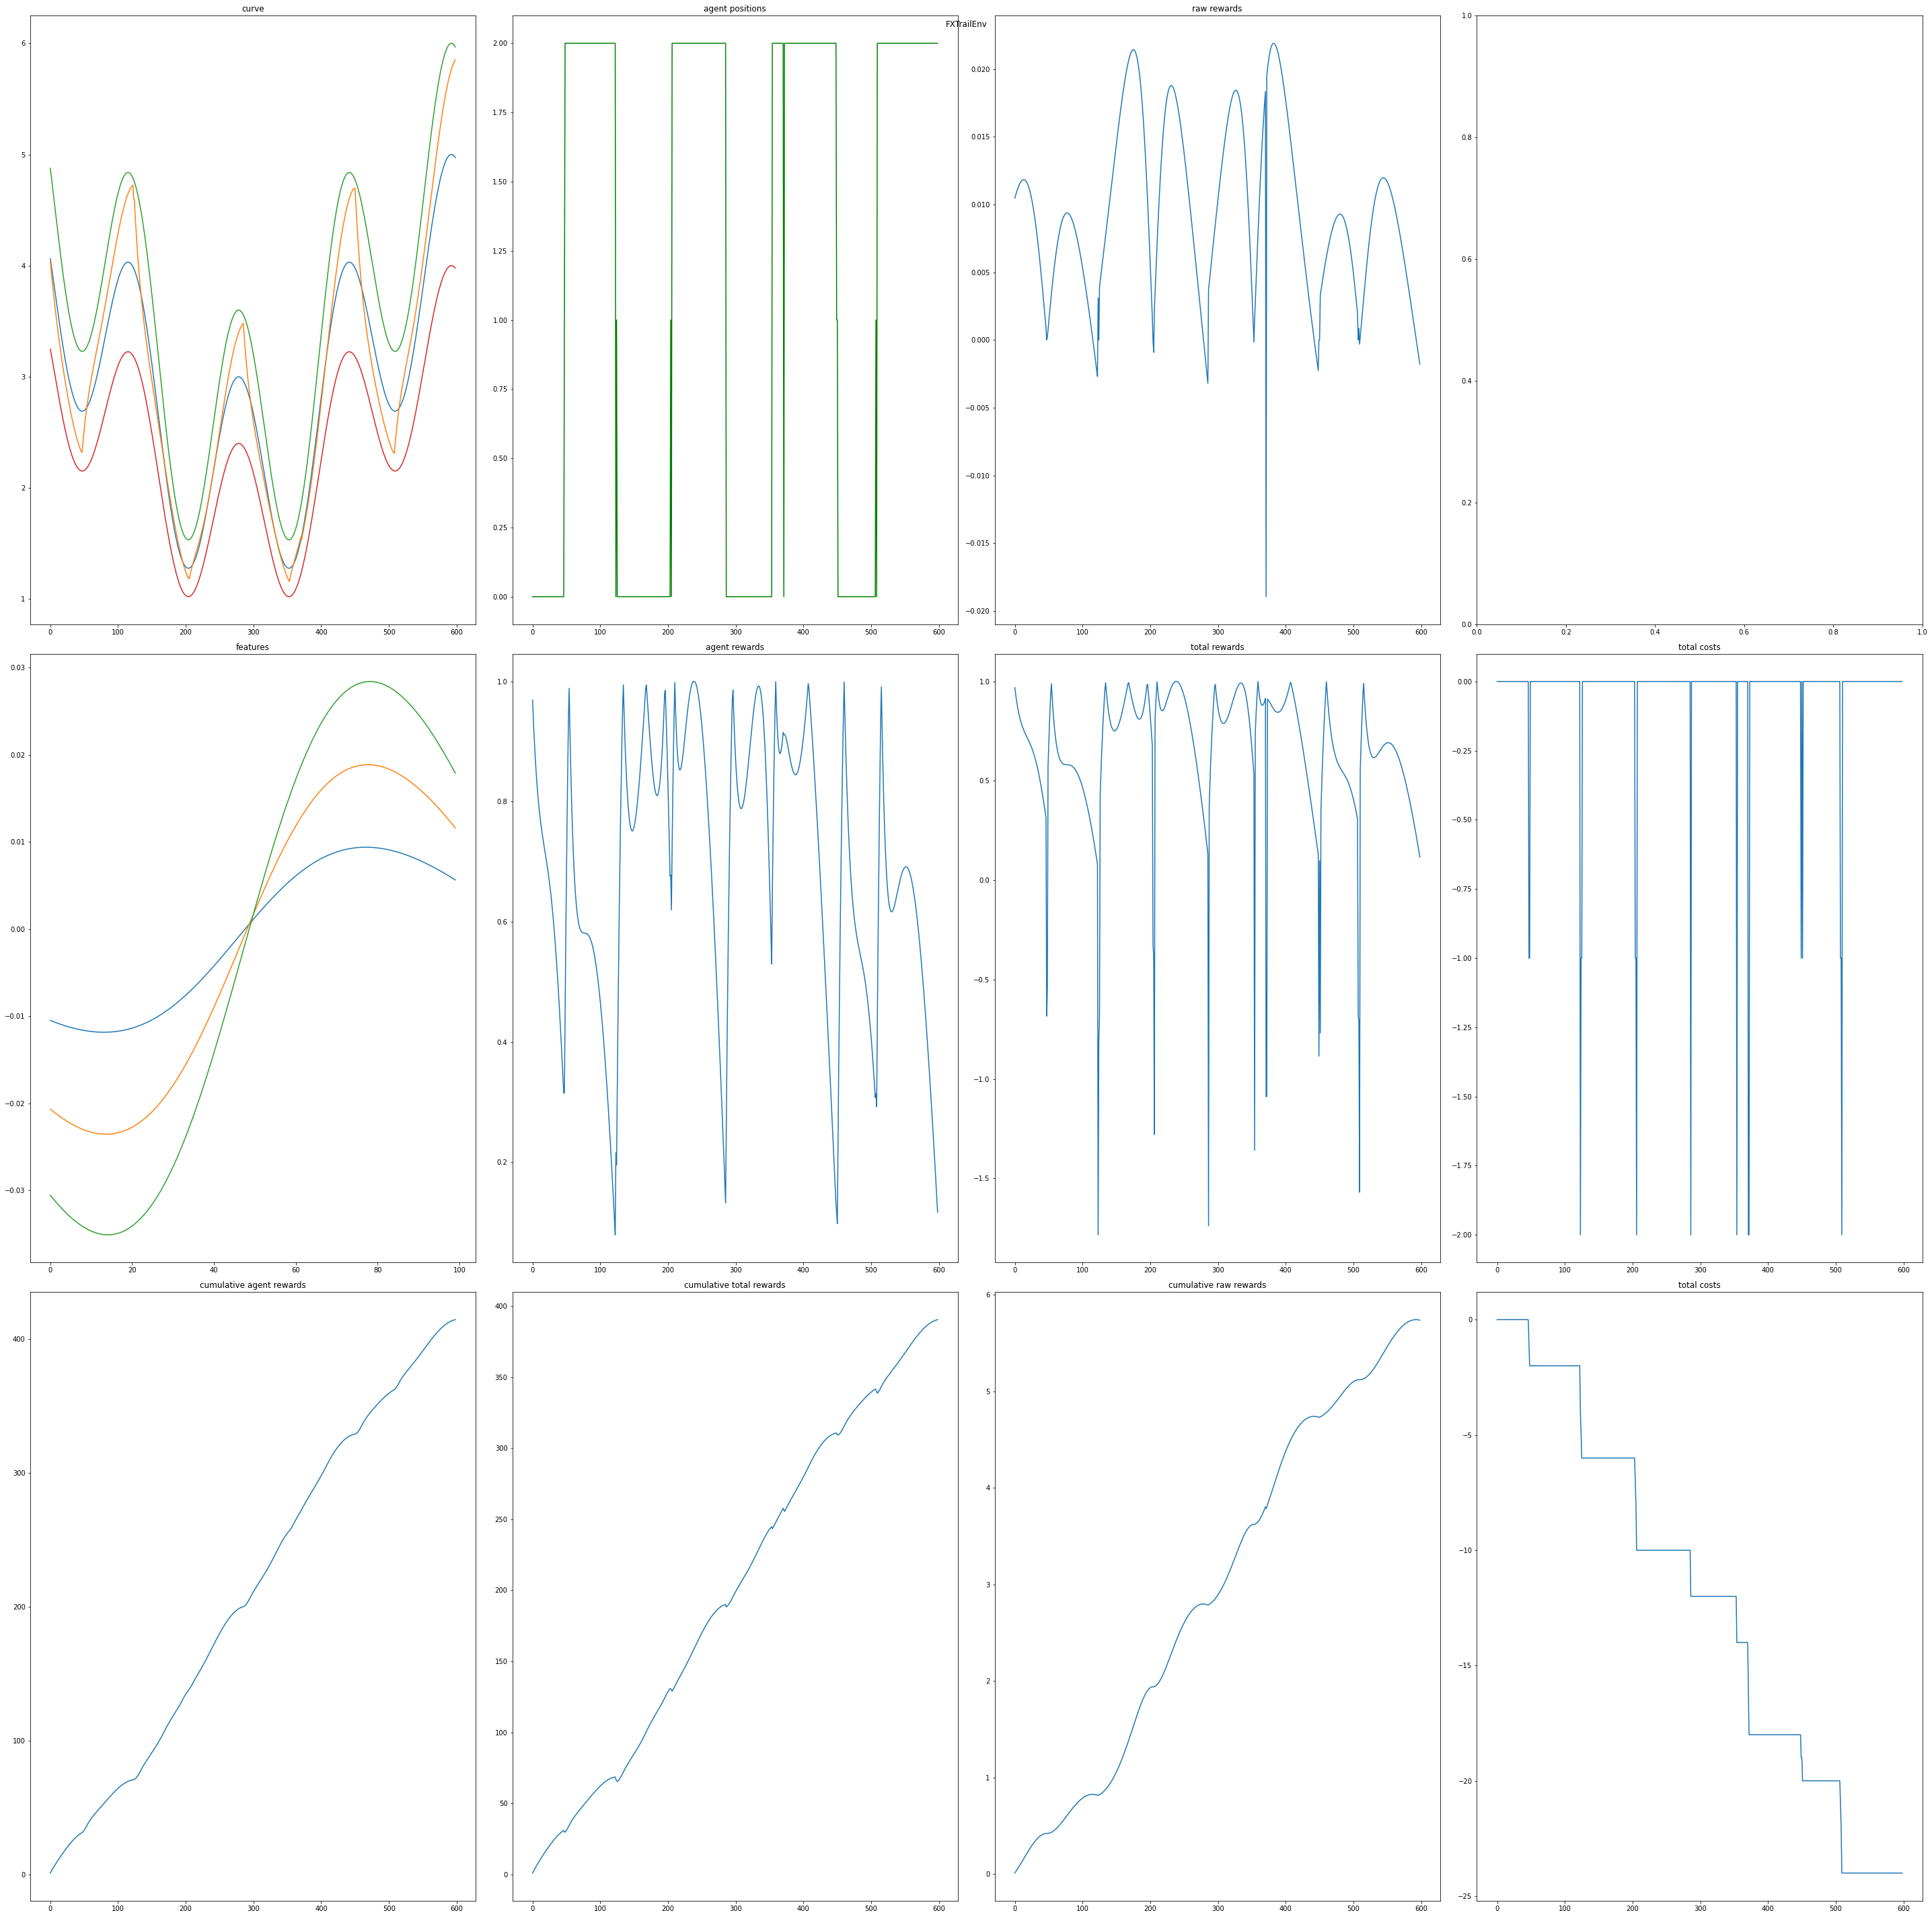

In [16]:
checkpoints = results.get_trial_checkpoints_paths(
    trial=results.get_best_trial("episode_reward_mean", mode="max"),
    metric="episode_reward_mean")

checkpoint_path = checkpoints[0][0]
trainer = PPOTrainer(config)
trainer.restore(checkpoint_path)

# Inference loop.
env = TrajectoryTrackingEnv()
obs = env.reset()
# range(2) b/c h- and c-states of the LSTM.
lstm_cell_size = 256
init_state = state = [
        np.zeros([lstm_cell_size], np.float32) for _ in range(2)
]

# Run manual inference loop for n episodes.
for _ in range(10):
    episode_reward = 0.0
    reward = 0.0
    done = False
    obs = env.reset()
    state = init_state
    prev_a = 1
    prev_r = 0.0

    while not done:
        a, state_out, _ = trainer.compute_single_action(obs, state, prev_action=prev_a, prev_reward=prev_r)
        obs, reward, done, _ = env.step(a)
        episode_reward += reward
        prev_a = a
        prev_r = reward
        state = state_out

    print(f"Episode reward={episode_reward}")
    env.render()

ray.shutdown()
